# XGBoost Wind Prediction

### Librerías

In [33]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import mean_absolute_error as mae


### Funciones

In [34]:
# Formatea las variables de tal forma que las pueda admitir la ANN
def fix_parameters(X, m, delta):
    left_stop = (m + delta)
    tam = X.size - left_stop
    i = X.size - 1
    X_fixed = []
    y_fixed = []
    while i >= left_stop:
        X_fixed = np.append(X_fixed, X[(i + 1 - left_stop):(i + 1) - delta])
        y_fixed = np.append(y_fixed, X[i])
        i = i - 1
    X_fixed = np.reshape(X_fixed, (tam, m))
  
    return X_fixed, y_fixed

In [35]:
#Obtiene los parametros optimos para nuestro algoritmo
def find_optimal_algorithm(md_values, eta_values, eval_metric, dtrain, dtest):
    # Parametros fijos del algoritmo
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    num_round = 250
    # Cuanto menor sea el valor de best_score, más preciso será nuestro algoritmo
    best_score = 100
    # Valores por defecto tanto del max_depth como del eta
    optimal_md = 6
    optimal_eta = 0.3
    # Algoritmo con la mejor puntuacion
    best_alg = 0
    for md in md_values:
        for eta in eta_values:
            # Establecemos la nueva configuracion de los parametros del algoritmo
            param = {'max_depth': md, 'eta': eta, 'eval_metric' : eval_metric}
            # Entrenemos la ANN
            aux = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=5)
            # Mostramos la informacion de la iteracion
            print("Max. Depth: ", md, ", ETA: ", eta, ",Best ", eval_metric, ": ", aux.best_score)
            # Si la puntuación es mejor que la que tenemos, la sobreescribimos
            if best_score > aux.best_score:
                best_score = aux.best_score
                optimal_md = md
                optimal_eta = eta
                best_alg = aux
    
    print("Best Max. Depth: ", optimal_md, ", Best ETA: ", optimal_eta,  ",Best ", eval_metric, ": ", best_score)
    return best_alg

In [36]:
# Obtiene los mejores resultados posibles del algoritmo para cada combinación de M y delta
def xgboost_results(time_params, alg_params, eval_metrics, data):
    # Matriz con todos los mejores resultados
    results = []
    # Dividimos los datos en un dataset para entrenar al algoritmo y otro para probar su rendimiento
    X_train, X_test = train_test_split(X, test_size=0.5, shuffle=False)
    for eval_metric in eval_metrics: 
        # Creamos la matriz de resultados con las mejores puntuaciones de cada combinacion de tiempos
        result = []
        for m in time_params['m']:
            for delta in time_params['delta']:
                # Damos formato a los datos de entrenamiento
                X_train_fixed, y_train_fixed = fix_parameters(X_train, m, delta)
                dtrain  = xgb.DMatrix(X_train_fixed, label=y_train_fixed)
                # Damos formato a los datos de prueba
                X_test_fixed, y_test_fixed = fix_parameters(X_test, m, delta)
                dtest = xgb.DMatrix(X_test_fixed, label=y_test_fixed)
                # Obtenemos el algoritmo optimo
                bst = find_optimal_algorithm(alg_params['md_values'], alg_params['eta_values'], eval_metric, dtrain, dtest)
                # Obtener las medidas de rendimiento para esta combinacion de tiempos
                print('M: ', m, ", Delta: ", delta,  ",Best ", eval_metric, ": ", bst.best_score)
                # Predecimos los resultados para mostrarlos mediante una gráfica
                y_test_predicted = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
                # Mostramos la tabla comparativa entre los valores originales y los predichos
                plt.figure(num= str(m) +", "+ str(delta), figsize=(40, 10))
                plt.suptitle("M: " + str(m) +", Delta: "+ str(delta))
                plt.plot(range(y_test_fixed.size), np.flip(y_test_fixed), c="b")
                plt.plot(range(y_test_predicted.size), np.flip(y_test_predicted), c="r")            
                plt.show()
                # Mostrar la gráfica con la evolución de los errores
                plt.figure(num= "Error: " + str(m) +", "+ str(delta), figsize=(40, 10))
                plt.suptitle("Error para M: " + str(m) +", Delta: "+ str(delta))
                plt.plot(range(y_test_fixed.size), np.flip(np.abs(np.subtract(y_test_fixed, y_test_predicted))), c="g")
                plt.show()
                # Añadimos el mejor resultado en su posicion en la matriz
                result = np.append(result, bst.best_score)
        result = np.reshape(result, (time_params['m'].size, time_params['delta'].size))
        print_plots(time_params, result, eval_metric)
        results = np.append(results, result)
    return results

In [37]:
# Generamos las tablas con los resultados obtenidos
def print_plots(time_params, results, eval_metric):
    i = 0
    for m in time_params['m']:
        # Establecemos el ancho de la figura
        plt.figure(figsize=(3, 3))
        # Añadimos las etiquetas de la figura
        plt.suptitle('M = ' + str(m))
        plt.xlabel('delta')
        plt.ylabel(eval_metric)
        # Rellenamos la figura con los datos
        plt.plot(time_params['delta'], results[i], 'bo', time_params['delta'], results[i])
        i = i + 1

### Preprocesamos los datos 

In [38]:
# Extraemos los datos del .csv
filename = 'T1.csv'
col_list = ["Date/Time", "Wind Speed (m/s)"]
# Tan solo escogemos los datos medidos cada 20 minutos
data = pd.read_csv('T1.csv', usecols=col_list, encoding='utf-8', skiprows=lambda x: (x != 0) and not x % 2)

data

Date/Time  Wind Speed (m/s)
0      01 01 2018 00:00          5.311336
1      01 01 2018 00:20          5.216037
2      01 01 2018 00:40          5.577941
3      01 01 2018 01:00          5.793008
4      01 01 2018 01:20          5.584629
...                 ...               ...
25260  31 12 2018 22:20         10.154550
25261  31 12 2018 22:40         12.195660
25262  31 12 2018 23:00         12.559170
25263  31 12 2018 23:20          7.332648
25264  31 12 2018 23:40          9.421366

[25265 rows x 2 columns]

<AxesSubplot:xlabel='Date/Time'>

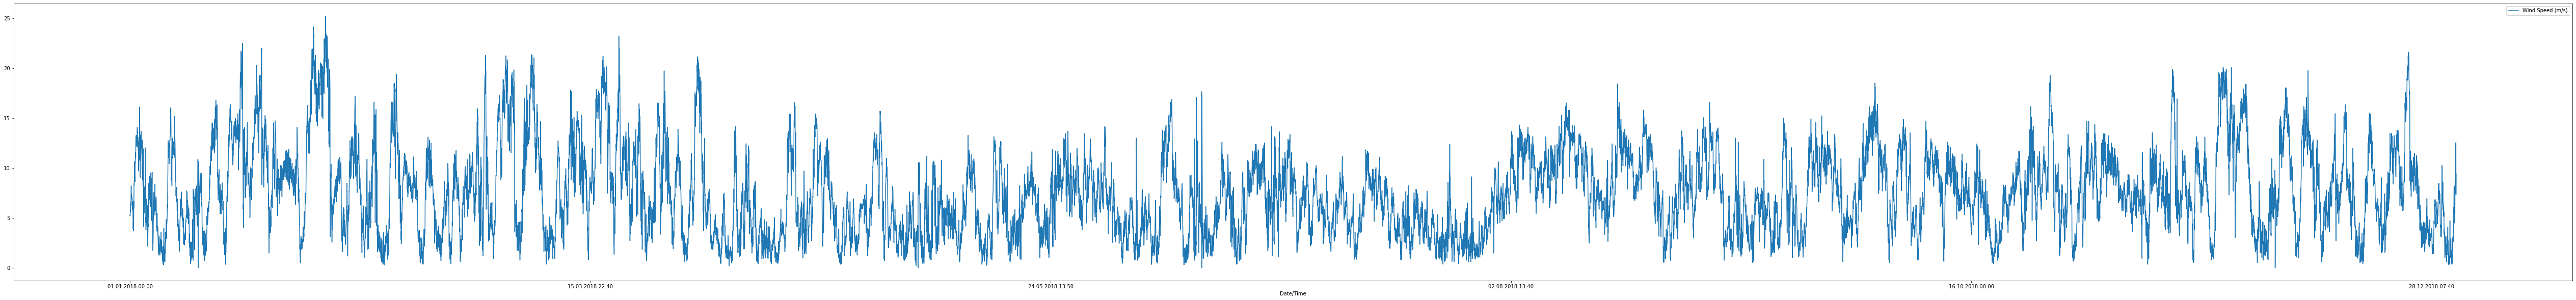

In [39]:
# Mostramos la gráfica con la tendencia anual de la velocidad del viento
plt.rcParams["figure.figsize"] = (90, 10)
data.plot(x ='Date/Time', y='Wind Speed (m/s)', kind = 'line')

In [40]:
# Ahora obtenemos el parámetro que necesitemos; en este caso, la wind speed. Ésta será nuestra variable X
np_data = data.to_numpy()
X = np_data[:,1]

X

array([5.31133604049682, 5.21603679656982, 5.57794094085693, ...,
       12.5591697692871, 7.33264780044555, 9.42136573791503], dtype=object)

### Establecemos los parámetros 

In [41]:
# Definimos los parametros de nuestra prueba
time_params = {
    'm': np.array([72, 216]), # 1, 3 días
    'delta': np.array([3, 36, 72]) # 1 hora, 12 horas y 1 días
}
alg_params = {
    'eta_values': np.arange(0, 1, 0.1),
    'md_values': np.arange(0, 6, 1)
}
eval_metrics = ['rmse', 'mae']

### Ejecutamos el algoritmo y obtenemos los resultados

[0]	train-rmse:8.32478	eval-rmse:8.14134
[1]	train-rmse:8.32478	eval-rmse:8.14134
[2]	train-rmse:8.32478	eval-rmse:8.14134
[3]	train-rmse:8.32478	eval-rmse:8.14134
[4]	train-rmse:8.32478	eval-rmse:8.14134
[5]	train-rmse:8.32478	eval-rmse:8.14134
Max. Depth:  0 , ETA:  0.0 ,Best  rmse :  8.141345
[0]	train-rmse:7.75154	eval-rmse:7.53626
[1]	train-rmse:7.25408	eval-rmse:7.00620
[2]	train-rmse:6.82460	eval-rmse:6.54377
[3]	train-rmse:6.45580	eval-rmse:6.14213
[4]	train-rmse:6.14086	eval-rmse:5.79490
[5]	train-rmse:5.87338	eval-rmse:5.49613
[6]	train-rmse:5.64744	eval-rmse:5.24027
[7]	train-rmse:5.45757	eval-rmse:5.02220
[8]	train-rmse:5.29879	eval-rmse:4.83715
[9]	train-rmse:5.16660	eval-rmse:4.68078
[10]	train-rmse:5.05699	eval-rmse:4.54914
[11]	train-rmse:4.96643	eval-rmse:4.43870
[12]	train-rmse:4.89185	eval-rmse:4.34630
[13]	train-rmse:4.83059	eval-rmse:4.26919
[14]	train-rmse:4.78040	eval-rmse:4.20495
[15]	train-rmse:4.73935	eval-rmse:4.15151
[16]	train-rmse:4.70584	eval-rmse:4.10711

[8]	train-rmse:4.56886	eval-rmse:3.90583
[9]	train-rmse:4.56445	eval-rmse:3.89647
[10]	train-rmse:4.56228	eval-rmse:3.89098
[11]	train-rmse:4.56122	eval-rmse:3.88767
[12]	train-rmse:4.56070	eval-rmse:3.88562
[13]	train-rmse:4.56044	eval-rmse:3.88430
[14]	train-rmse:4.56032	eval-rmse:3.88345
[15]	train-rmse:4.56026	eval-rmse:3.88288
[16]	train-rmse:4.56023	eval-rmse:3.88250
[17]	train-rmse:4.56021	eval-rmse:3.88224
[18]	train-rmse:4.56021	eval-rmse:3.88205
[19]	train-rmse:4.56020	eval-rmse:3.88193
[20]	train-rmse:4.56020	eval-rmse:3.88185
[21]	train-rmse:4.56020	eval-rmse:3.88179
[22]	train-rmse:4.56020	eval-rmse:3.88175
[23]	train-rmse:4.56020	eval-rmse:3.88172
[24]	train-rmse:4.56020	eval-rmse:3.88170
[25]	train-rmse:4.56020	eval-rmse:3.88168
[26]	train-rmse:4.56020	eval-rmse:3.88167
[27]	train-rmse:4.56020	eval-rmse:3.88166
[28]	train-rmse:4.56020	eval-rmse:3.88166
[29]	train-rmse:4.56020	eval-rmse:3.88166
[30]	train-rmse:4.56020	eval-rmse:3.88166
[31]	train-rmse:4.56020	eval-rmse:3.

[26]	train-rmse:1.99726	eval-rmse:1.64418
[27]	train-rmse:1.96660	eval-rmse:1.62792
[28]	train-rmse:1.93890	eval-rmse:1.59808
[29]	train-rmse:1.91487	eval-rmse:1.57842
[30]	train-rmse:1.89260	eval-rmse:1.55568
[31]	train-rmse:1.87194	eval-rmse:1.54644
[32]	train-rmse:1.85391	eval-rmse:1.52799
[33]	train-rmse:1.83770	eval-rmse:1.52058
[34]	train-rmse:1.82252	eval-rmse:1.50568
[35]	train-rmse:1.80898	eval-rmse:1.49815
[36]	train-rmse:1.79674	eval-rmse:1.48628
[37]	train-rmse:1.78561	eval-rmse:1.47501
[38]	train-rmse:1.77507	eval-rmse:1.47145
[39]	train-rmse:1.76557	eval-rmse:1.46304
[40]	train-rmse:1.75684	eval-rmse:1.45916
[41]	train-rmse:1.74902	eval-rmse:1.45206
[42]	train-rmse:1.74164	eval-rmse:1.44992
[43]	train-rmse:1.73480	eval-rmse:1.44320
[44]	train-rmse:1.72879	eval-rmse:1.43809
[45]	train-rmse:1.72302	eval-rmse:1.43441
[46]	train-rmse:1.71777	eval-rmse:1.43310
[47]	train-rmse:1.71275	eval-rmse:1.42837
[48]	train-rmse:1.70841	eval-rmse:1.42568
[49]	train-rmse:1.70432	eval-rmse:

[35]	train-rmse:1.68162	eval-rmse:1.45913
[36]	train-rmse:1.68074	eval-rmse:1.45916
[37]	train-rmse:1.67978	eval-rmse:1.45913
[38]	train-rmse:1.67904	eval-rmse:1.45913
[39]	train-rmse:1.67835	eval-rmse:1.45914
[40]	train-rmse:1.67771	eval-rmse:1.45916
[41]	train-rmse:1.67705	eval-rmse:1.45840
[42]	train-rmse:1.67625	eval-rmse:1.45770
[43]	train-rmse:1.67567	eval-rmse:1.45749
[44]	train-rmse:1.67499	eval-rmse:1.45674
[45]	train-rmse:1.67436	eval-rmse:1.45615
[46]	train-rmse:1.67372	eval-rmse:1.45614
[47]	train-rmse:1.67314	eval-rmse:1.45551
[48]	train-rmse:1.67251	eval-rmse:1.45506
[49]	train-rmse:1.67191	eval-rmse:1.45496
[50]	train-rmse:1.67138	eval-rmse:1.45498
[51]	train-rmse:1.67087	eval-rmse:1.45460
[52]	train-rmse:1.67032	eval-rmse:1.45459
[53]	train-rmse:1.66986	eval-rmse:1.45460
[54]	train-rmse:1.66937	eval-rmse:1.45460
[55]	train-rmse:1.66894	eval-rmse:1.45415
[56]	train-rmse:1.66831	eval-rmse:1.45340
[57]	train-rmse:1.66788	eval-rmse:1.45296
[58]	train-rmse:1.66731	eval-rmse:

[103]	train-rmse:1.66378	eval-rmse:1.43772
[104]	train-rmse:1.66319	eval-rmse:1.43703
[105]	train-rmse:1.66256	eval-rmse:1.43640
[106]	train-rmse:1.66195	eval-rmse:1.43522
[107]	train-rmse:1.66139	eval-rmse:1.43506
[108]	train-rmse:1.66085	eval-rmse:1.43441
[109]	train-rmse:1.66033	eval-rmse:1.43393
[110]	train-rmse:1.65982	eval-rmse:1.43362
[111]	train-rmse:1.65926	eval-rmse:1.43365
[112]	train-rmse:1.65882	eval-rmse:1.43364
[113]	train-rmse:1.65827	eval-rmse:1.43408
[114]	train-rmse:1.65780	eval-rmse:1.43310
[115]	train-rmse:1.65732	eval-rmse:1.43284
[116]	train-rmse:1.65687	eval-rmse:1.43344
[117]	train-rmse:1.65643	eval-rmse:1.43339
[118]	train-rmse:1.65600	eval-rmse:1.43342
[119]	train-rmse:1.65556	eval-rmse:1.43339
[120]	train-rmse:1.65511	eval-rmse:1.43340
Max. Depth:  1 , ETA:  0.5 ,Best  rmse :  1.432836
[0]	train-rmse:4.28388	eval-rmse:3.90452
[1]	train-rmse:2.87647	eval-rmse:2.63681
[2]	train-rmse:2.26574	eval-rmse:1.94463
[3]	train-rmse:2.08528	eval-rmse:1.85444
[4]	train-r

[6]	train-rmse:1.96942	eval-rmse:1.74375
[7]	train-rmse:1.93510	eval-rmse:1.71606
[8]	train-rmse:1.91093	eval-rmse:1.69579
[9]	train-rmse:1.88613	eval-rmse:1.66041
[10]	train-rmse:1.86850	eval-rmse:1.64082
[11]	train-rmse:1.85672	eval-rmse:1.62406
[12]	train-rmse:1.84005	eval-rmse:1.61054
[13]	train-rmse:1.83108	eval-rmse:1.61079
[14]	train-rmse:1.82164	eval-rmse:1.59852
[15]	train-rmse:1.81210	eval-rmse:1.58748
[16]	train-rmse:1.80550	eval-rmse:1.57938
[17]	train-rmse:1.79720	eval-rmse:1.58110
[18]	train-rmse:1.79002	eval-rmse:1.56512
[19]	train-rmse:1.78001	eval-rmse:1.55378
[20]	train-rmse:1.77526	eval-rmse:1.54824
[21]	train-rmse:1.76948	eval-rmse:1.54232
[22]	train-rmse:1.76400	eval-rmse:1.52923
[23]	train-rmse:1.75571	eval-rmse:1.52677
[24]	train-rmse:1.75139	eval-rmse:1.51733
[25]	train-rmse:1.74706	eval-rmse:1.51601
[26]	train-rmse:1.74277	eval-rmse:1.51591
[27]	train-rmse:1.73900	eval-rmse:1.51508
[28]	train-rmse:1.73581	eval-rmse:1.51309
[29]	train-rmse:1.73256	eval-rmse:1.50

[6]	train-rmse:2.47003	eval-rmse:2.24635
[7]	train-rmse:2.22776	eval-rmse:1.99587
[8]	train-rmse:2.05143	eval-rmse:1.81400
[9]	train-rmse:1.92850	eval-rmse:1.68621
[10]	train-rmse:1.84238	eval-rmse:1.59556
[11]	train-rmse:1.78219	eval-rmse:1.52783
[12]	train-rmse:1.74164	eval-rmse:1.48635
[13]	train-rmse:1.71189	eval-rmse:1.45731
[14]	train-rmse:1.69220	eval-rmse:1.43805
[15]	train-rmse:1.67839	eval-rmse:1.42540
[16]	train-rmse:1.66714	eval-rmse:1.41626
[17]	train-rmse:1.65885	eval-rmse:1.41094
[18]	train-rmse:1.65216	eval-rmse:1.40924
[19]	train-rmse:1.64766	eval-rmse:1.40709
[20]	train-rmse:1.64317	eval-rmse:1.40453
[21]	train-rmse:1.64022	eval-rmse:1.40282
[22]	train-rmse:1.63822	eval-rmse:1.40235
[23]	train-rmse:1.63543	eval-rmse:1.40112
[24]	train-rmse:1.63354	eval-rmse:1.40086
[25]	train-rmse:1.63184	eval-rmse:1.40033
[26]	train-rmse:1.62962	eval-rmse:1.40040
[27]	train-rmse:1.62773	eval-rmse:1.40026
[28]	train-rmse:1.62673	eval-rmse:1.39987
[29]	train-rmse:1.62544	eval-rmse:1.39

Max. Depth:  3 , ETA:  0.0 ,Best  rmse :  8.141345
[0]	train-rmse:7.53275	eval-rmse:7.35820
[1]	train-rmse:6.82360	eval-rmse:6.65609
[2]	train-rmse:6.18875	eval-rmse:6.02772
[3]	train-rmse:5.62147	eval-rmse:5.46375
[4]	train-rmse:5.11484	eval-rmse:4.95941
[5]	train-rmse:4.66347	eval-rmse:4.50886
[6]	train-rmse:4.26262	eval-rmse:4.10745
[7]	train-rmse:3.90697	eval-rmse:3.75038
[8]	train-rmse:3.59289	eval-rmse:3.43318
[9]	train-rmse:3.31615	eval-rmse:3.15257
[10]	train-rmse:3.07314	eval-rmse:2.90451
[11]	train-rmse:2.86051	eval-rmse:2.68675
[12]	train-rmse:2.67482	eval-rmse:2.49562
[13]	train-rmse:2.51410	eval-rmse:2.32834
[14]	train-rmse:2.37528	eval-rmse:2.18314
[15]	train-rmse:2.25630	eval-rmse:2.05863
[16]	train-rmse:2.15445	eval-rmse:1.95077
[17]	train-rmse:2.06785	eval-rmse:1.85927
[18]	train-rmse:1.99405	eval-rmse:1.78081
[19]	train-rmse:1.93138	eval-rmse:1.71473
[20]	train-rmse:1.87806	eval-rmse:1.65864
[21]	train-rmse:1.83374	eval-rmse:1.61203
[22]	train-rmse:1.79701	eval-rmse:1

Max. Depth:  3 , ETA:  0.8 ,Best  rmse :  1.46963
[0]	train-rmse:1.95232	eval-rmse:1.72778
[1]	train-rmse:1.72507	eval-rmse:1.49365
[2]	train-rmse:1.70138	eval-rmse:1.49155
[3]	train-rmse:1.68151	eval-rmse:1.48690
[4]	train-rmse:1.65990	eval-rmse:1.46581
[5]	train-rmse:1.64639	eval-rmse:1.46484
[6]	train-rmse:1.62096	eval-rmse:1.44003
[7]	train-rmse:1.60962	eval-rmse:1.44034
[8]	train-rmse:1.59752	eval-rmse:1.43264
[9]	train-rmse:1.58950	eval-rmse:1.43522
[10]	train-rmse:1.58557	eval-rmse:1.43518
[11]	train-rmse:1.57962	eval-rmse:1.43802
[12]	train-rmse:1.56981	eval-rmse:1.43916
[13]	train-rmse:1.56193	eval-rmse:1.44174
Max. Depth:  3 , ETA:  0.9 ,Best  rmse :  1.432638
[0]	train-rmse:8.32478	eval-rmse:8.14134
[1]	train-rmse:8.32478	eval-rmse:8.14134
[2]	train-rmse:8.32478	eval-rmse:8.14134
[3]	train-rmse:8.32478	eval-rmse:8.14134
[4]	train-rmse:8.32478	eval-rmse:8.14134
[5]	train-rmse:8.32478	eval-rmse:8.14134
Max. Depth:  4 , ETA:  0.0 ,Best  rmse :  8.141345
[0]	train-rmse:7.52965	e

[0]	train-rmse:2.35462	eval-rmse:2.16781
[1]	train-rmse:1.67773	eval-rmse:1.45684
[2]	train-rmse:1.61824	eval-rmse:1.42589
[3]	train-rmse:1.60422	eval-rmse:1.42883
[4]	train-rmse:1.58728	eval-rmse:1.43675
[5]	train-rmse:1.57175	eval-rmse:1.44114
[6]	train-rmse:1.56026	eval-rmse:1.44537
[7]	train-rmse:1.55217	eval-rmse:1.44853
Max. Depth:  4 , ETA:  0.8 ,Best  rmse :  1.425889
[0]	train-rmse:1.88039	eval-rmse:1.65787
[1]	train-rmse:1.64315	eval-rmse:1.43693
[2]	train-rmse:1.62593	eval-rmse:1.43593
[3]	train-rmse:1.60962	eval-rmse:1.44275
[4]	train-rmse:1.60367	eval-rmse:1.44288
[5]	train-rmse:1.59270	eval-rmse:1.44335
[6]	train-rmse:1.57520	eval-rmse:1.44690
[7]	train-rmse:1.56136	eval-rmse:1.45553
Max. Depth:  4 , ETA:  0.9 ,Best  rmse :  1.435932
[0]	train-rmse:8.32478	eval-rmse:8.14134
[1]	train-rmse:8.32478	eval-rmse:8.14134
[2]	train-rmse:8.32478	eval-rmse:8.14134
[3]	train-rmse:8.32478	eval-rmse:8.14134
[4]	train-rmse:8.32478	eval-rmse:8.14134
[5]	train-rmse:8.32478	eval-rmse:8.14

[2]	train-rmse:1.55439	eval-rmse:1.44708
[3]	train-rmse:1.52522	eval-rmse:1.45391
[4]	train-rmse:1.50374	eval-rmse:1.46376
[5]	train-rmse:1.48534	eval-rmse:1.47237
[6]	train-rmse:1.47236	eval-rmse:1.47656
[7]	train-rmse:1.45410	eval-rmse:1.47978
Max. Depth:  5 , ETA:  0.8 ,Best  rmse :  1.447079
[0]	train-rmse:1.84234	eval-rmse:1.65639
[1]	train-rmse:1.59344	eval-rmse:1.44438
[2]	train-rmse:1.57173	eval-rmse:1.44589
[3]	train-rmse:1.55178	eval-rmse:1.45312
[4]	train-rmse:1.53890	eval-rmse:1.45387
[5]	train-rmse:1.51379	eval-rmse:1.47304
[6]	train-rmse:1.49767	eval-rmse:1.47718
Max. Depth:  5 , ETA:  0.9 ,Best  rmse :  1.444381
Best Max. Depth:  3 , Best ETA:  0.1 ,Best  rmse :  1.388195
M:  72 , Delta:  3 ,Best  rmse :  1.388195


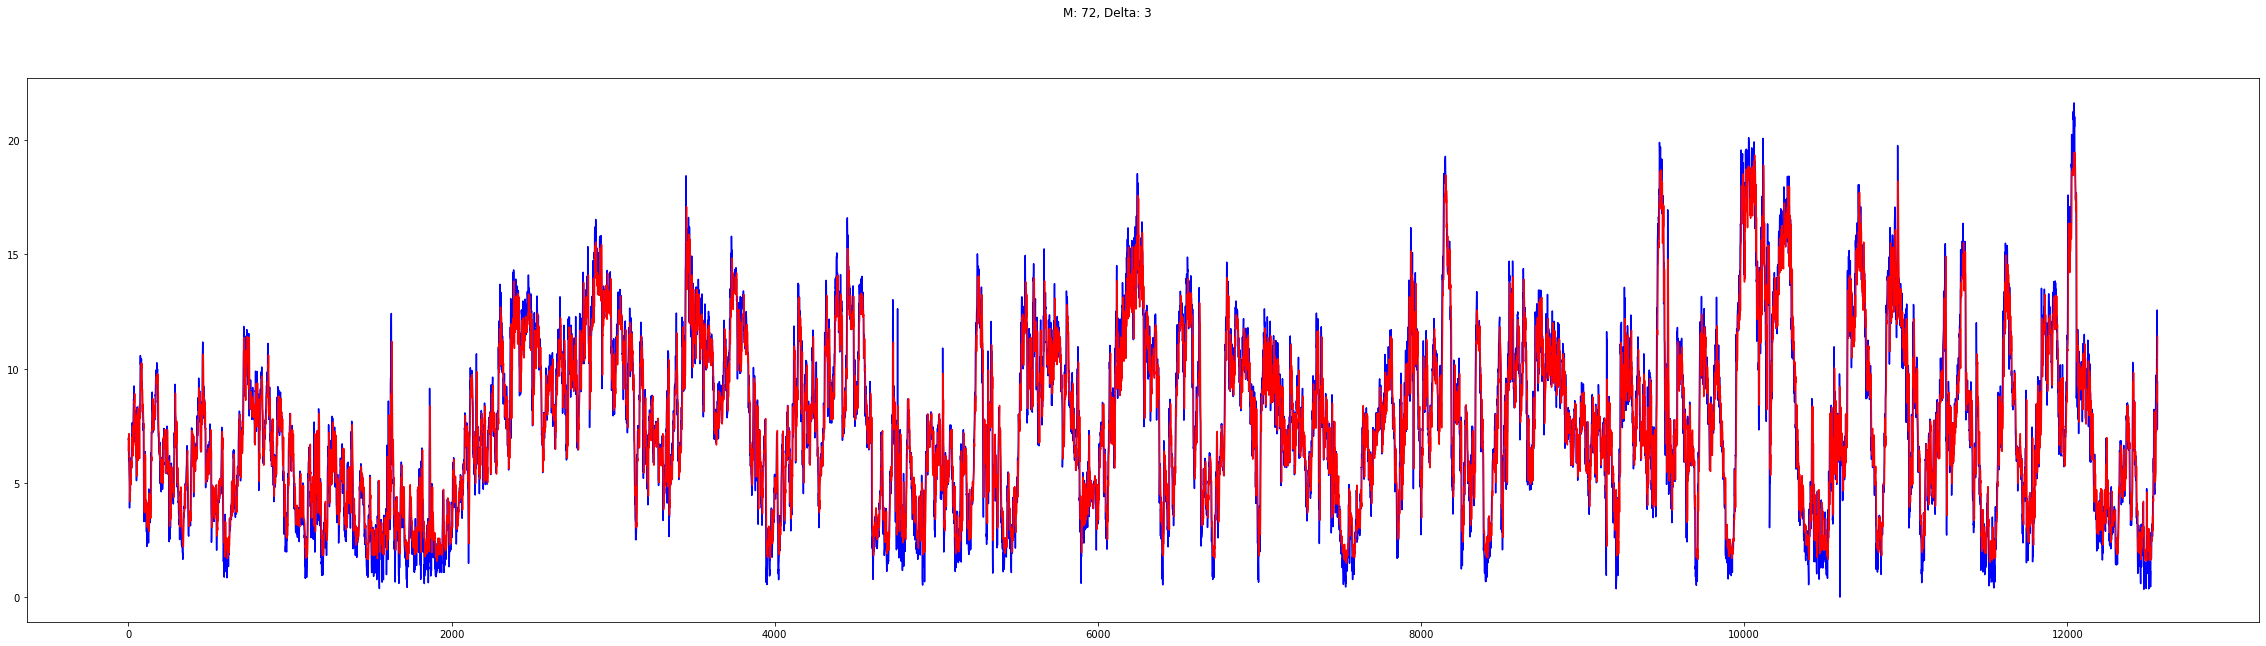

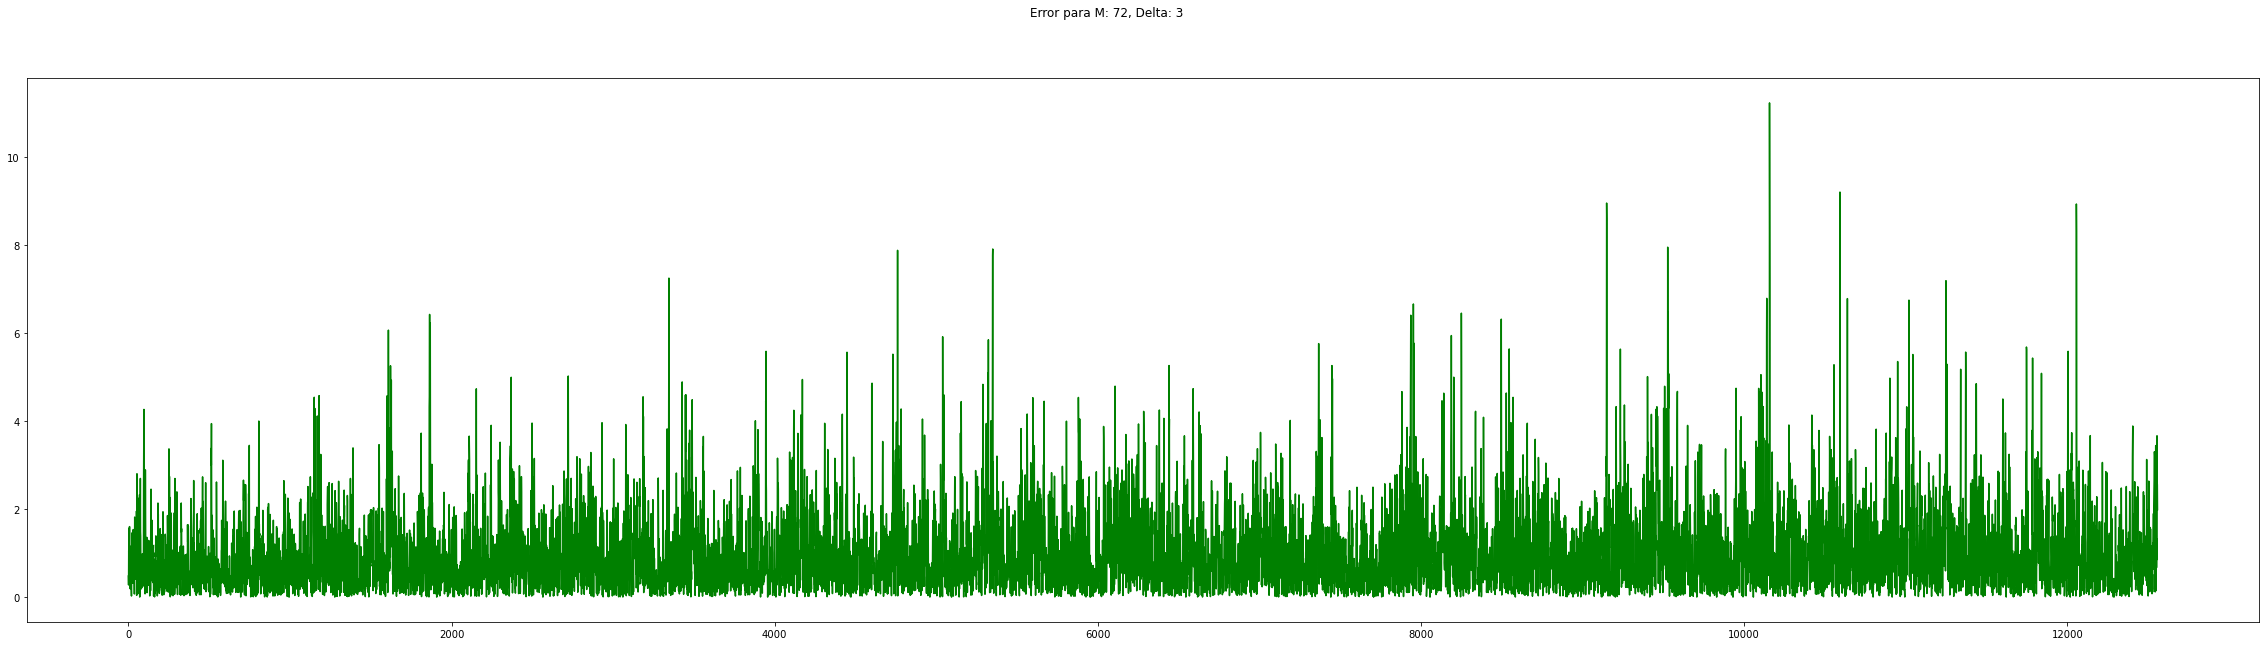

[0]	train-rmse:8.31156	eval-rmse:8.14664
[1]	train-rmse:8.31156	eval-rmse:8.14664
[2]	train-rmse:8.31156	eval-rmse:8.14664
[3]	train-rmse:8.31156	eval-rmse:8.14664
[4]	train-rmse:8.31156	eval-rmse:8.14664
Max. Depth:  0 , ETA:  0.0 ,Best  rmse :  8.146641
[0]	train-rmse:7.73974	eval-rmse:7.54282
[1]	train-rmse:7.24354	eval-rmse:7.01383
[2]	train-rmse:6.81518	eval-rmse:6.55230
[3]	train-rmse:6.44738	eval-rmse:6.15137
[4]	train-rmse:6.13330	eval-rmse:5.80469
[5]	train-rmse:5.86658	eval-rmse:5.50632
[6]	train-rmse:5.64129	eval-rmse:5.25073
[7]	train-rmse:5.45199	eval-rmse:5.03279
[8]	train-rmse:5.29369	eval-rmse:4.84777
[9]	train-rmse:5.16191	eval-rmse:4.69134
[10]	train-rmse:5.05265	eval-rmse:4.55957
[11]	train-rmse:4.96238	eval-rmse:4.44893
[12]	train-rmse:4.88804	eval-rmse:4.35630
[13]	train-rmse:4.82698	eval-rmse:4.27892
[14]	train-rmse:4.77696	eval-rmse:4.21440
[15]	train-rmse:4.73604	eval-rmse:4.16068
[16]	train-rmse:4.70264	eval-rmse:4.11598
[17]	train-rmse:4.67542	eval-rmse:4.0788

[9]	train-rmse:4.56173	eval-rmse:3.90216
[10]	train-rmse:4.55957	eval-rmse:3.89643
[11]	train-rmse:4.55851	eval-rmse:3.89294
[12]	train-rmse:4.55800	eval-rmse:3.89076
[13]	train-rmse:4.55774	eval-rmse:3.88936
[14]	train-rmse:4.55762	eval-rmse:3.88844
[15]	train-rmse:4.55756	eval-rmse:3.88783
[16]	train-rmse:4.55753	eval-rmse:3.88741
[17]	train-rmse:4.55751	eval-rmse:3.88713
[18]	train-rmse:4.55750	eval-rmse:3.88694
[19]	train-rmse:4.55750	eval-rmse:3.88680
[20]	train-rmse:4.55750	eval-rmse:3.88671
[21]	train-rmse:4.55750	eval-rmse:3.88665
[22]	train-rmse:4.55750	eval-rmse:3.88660
[23]	train-rmse:4.55750	eval-rmse:3.88657
[24]	train-rmse:4.55750	eval-rmse:3.88655
[25]	train-rmse:4.55750	eval-rmse:3.88653
[26]	train-rmse:4.55750	eval-rmse:3.88652
[27]	train-rmse:4.55750	eval-rmse:3.88652
[28]	train-rmse:4.55750	eval-rmse:3.88651
[29]	train-rmse:4.55750	eval-rmse:3.88651
[30]	train-rmse:4.55750	eval-rmse:3.88650
[31]	train-rmse:4.55750	eval-rmse:3.88650
[32]	train-rmse:4.55750	eval-rmse:3

[18]	train-rmse:4.01278	eval-rmse:3.50779
[19]	train-rmse:3.98230	eval-rmse:3.46270
[20]	train-rmse:3.95625	eval-rmse:3.43812
[21]	train-rmse:3.93449	eval-rmse:3.41798
[22]	train-rmse:3.91576	eval-rmse:3.38874
[23]	train-rmse:3.89972	eval-rmse:3.37290
[24]	train-rmse:3.88628	eval-rmse:3.35098
[25]	train-rmse:3.87465	eval-rmse:3.34114
[26]	train-rmse:3.86468	eval-rmse:3.33134
[27]	train-rmse:3.85603	eval-rmse:3.31701
[28]	train-rmse:3.84877	eval-rmse:3.30959
[29]	train-rmse:3.84233	eval-rmse:3.29785
[30]	train-rmse:3.83671	eval-rmse:3.29405
[31]	train-rmse:3.83190	eval-rmse:3.28475
[32]	train-rmse:3.82761	eval-rmse:3.28237
[33]	train-rmse:3.82391	eval-rmse:3.28094
[34]	train-rmse:3.82040	eval-rmse:3.27863
[35]	train-rmse:3.81726	eval-rmse:3.27223
[36]	train-rmse:3.81439	eval-rmse:3.27173
[37]	train-rmse:3.81162	eval-rmse:3.27132
[38]	train-rmse:3.80906	eval-rmse:3.26585
[39]	train-rmse:3.80674	eval-rmse:3.26594
[40]	train-rmse:3.80456	eval-rmse:3.26541
[41]	train-rmse:3.80256	eval-rmse:

[27]	train-rmse:3.75483	eval-rmse:3.29422
[28]	train-rmse:3.75326	eval-rmse:3.29060
Max. Depth:  1 , ETA:  0.6000000000000001 ,Best  rmse :  3.282281
[0]	train-rmse:4.62167	eval-rmse:4.24763
[1]	train-rmse:4.00960	eval-rmse:3.43793
[2]	train-rmse:3.90531	eval-rmse:3.37183
[3]	train-rmse:3.87550	eval-rmse:3.36252
[4]	train-rmse:3.85834	eval-rmse:3.32620
[5]	train-rmse:3.84348	eval-rmse:3.33617
[6]	train-rmse:3.83569	eval-rmse:3.31812
[7]	train-rmse:3.82653	eval-rmse:3.32923
[8]	train-rmse:3.81919	eval-rmse:3.32858
[9]	train-rmse:3.81370	eval-rmse:3.31257
[10]	train-rmse:3.80625	eval-rmse:3.31856
[11]	train-rmse:3.80181	eval-rmse:3.32377
[12]	train-rmse:3.79652	eval-rmse:3.31279
[13]	train-rmse:3.79180	eval-rmse:3.29844
[14]	train-rmse:3.78818	eval-rmse:3.29810
[15]	train-rmse:3.78525	eval-rmse:3.30536
[16]	train-rmse:3.78114	eval-rmse:3.29058
[17]	train-rmse:3.77862	eval-rmse:3.29686
[18]	train-rmse:3.77533	eval-rmse:3.29013
[19]	train-rmse:3.77282	eval-rmse:3.29144
[20]	train-rmse:3.77

[10]	train-rmse:3.71691	eval-rmse:3.27303
[11]	train-rmse:3.70777	eval-rmse:3.28097
[12]	train-rmse:3.70405	eval-rmse:3.28058
Max. Depth:  2 , ETA:  0.4 ,Best  rmse :  3.27104
[0]	train-rmse:5.34096	eval-rmse:5.03701
[1]	train-rmse:4.25538	eval-rmse:3.84991
[2]	train-rmse:3.91688	eval-rmse:3.44321
[3]	train-rmse:3.81243	eval-rmse:3.34525
[4]	train-rmse:3.77405	eval-rmse:3.29588
[5]	train-rmse:3.75334	eval-rmse:3.28765
[6]	train-rmse:3.73534	eval-rmse:3.27310
[7]	train-rmse:3.72307	eval-rmse:3.27652
[8]	train-rmse:3.71517	eval-rmse:3.28176
[9]	train-rmse:3.71055	eval-rmse:3.28141
[10]	train-rmse:3.70100	eval-rmse:3.27677
[11]	train-rmse:3.69652	eval-rmse:3.27621
Max. Depth:  2 , ETA:  0.5 ,Best  rmse :  3.273096
[0]	train-rmse:4.86384	eval-rmse:4.51727
[1]	train-rmse:4.00649	eval-rmse:3.55930
[2]	train-rmse:3.82761	eval-rmse:3.34194
[3]	train-rmse:3.77652	eval-rmse:3.28505
[4]	train-rmse:3.75407	eval-rmse:3.28834
[5]	train-rmse:3.74281	eval-rmse:3.29133
[6]	train-rmse:3.72925	eval-rmse:

[2]	train-rmse:3.84270	eval-rmse:3.47199
[3]	train-rmse:3.73146	eval-rmse:3.35864
[4]	train-rmse:3.68052	eval-rmse:3.32849
[5]	train-rmse:3.65089	eval-rmse:3.31269
[6]	train-rmse:3.63856	eval-rmse:3.30443
[7]	train-rmse:3.62015	eval-rmse:3.29826
[8]	train-rmse:3.59918	eval-rmse:3.30301
[9]	train-rmse:3.58074	eval-rmse:3.31508
[10]	train-rmse:3.56761	eval-rmse:3.32036
[11]	train-rmse:3.56067	eval-rmse:3.32064
[12]	train-rmse:3.55503	eval-rmse:3.31721
Max. Depth:  3 , ETA:  0.5 ,Best  rmse :  3.298261
[0]	train-rmse:4.82399	eval-rmse:4.48848
[1]	train-rmse:3.93857	eval-rmse:3.57118
[2]	train-rmse:3.75236	eval-rmse:3.34107
[3]	train-rmse:3.69571	eval-rmse:3.28950
[4]	train-rmse:3.67011	eval-rmse:3.29451
[5]	train-rmse:3.65603	eval-rmse:3.28563
[6]	train-rmse:3.63431	eval-rmse:3.29995
[7]	train-rmse:3.62493	eval-rmse:3.30550
[8]	train-rmse:3.61568	eval-rmse:3.30070
[9]	train-rmse:3.60410	eval-rmse:3.30638
[10]	train-rmse:3.58853	eval-rmse:3.31078
Max. Depth:  3 , ETA:  0.6000000000000001 ,

[3]	train-rmse:3.61647	eval-rmse:3.38689
[4]	train-rmse:3.56933	eval-rmse:3.35057
[5]	train-rmse:3.54550	eval-rmse:3.33359
[6]	train-rmse:3.52060	eval-rmse:3.33725
[7]	train-rmse:3.49068	eval-rmse:3.33873
[8]	train-rmse:3.46590	eval-rmse:3.34449
[9]	train-rmse:3.45166	eval-rmse:3.34304
[10]	train-rmse:3.42817	eval-rmse:3.34894
Max. Depth:  4 , ETA:  0.5 ,Best  rmse :  3.333593
[0]	train-rmse:4.78349	eval-rmse:4.53501
[1]	train-rmse:3.86681	eval-rmse:3.59180
[2]	train-rmse:3.64777	eval-rmse:3.37705
[3]	train-rmse:3.58899	eval-rmse:3.34659
[4]	train-rmse:3.56166	eval-rmse:3.33344
[5]	train-rmse:3.54367	eval-rmse:3.32508
[6]	train-rmse:3.51492	eval-rmse:3.33618
[7]	train-rmse:3.48425	eval-rmse:3.35653
[8]	train-rmse:3.44813	eval-rmse:3.36713
[9]	train-rmse:3.42554	eval-rmse:3.38087
[10]	train-rmse:3.41211	eval-rmse:3.38152
Max. Depth:  4 , ETA:  0.6000000000000001 ,Best  rmse :  3.325077
[0]	train-rmse:4.36158	eval-rmse:4.08122
[1]	train-rmse:3.71922	eval-rmse:3.43334
[2]	train-rmse:3.604

[8]	train-rmse:3.28741	eval-rmse:3.42288
Max. Depth:  5 , ETA:  0.6000000000000001 ,Best  rmse :  3.416179
[0]	train-rmse:4.30902	eval-rmse:4.08098
[1]	train-rmse:3.60491	eval-rmse:3.48339
[2]	train-rmse:3.47384	eval-rmse:3.42676
[3]	train-rmse:3.40315	eval-rmse:3.43313
[4]	train-rmse:3.37192	eval-rmse:3.43299
[5]	train-rmse:3.35602	eval-rmse:3.43434
[6]	train-rmse:3.30535	eval-rmse:3.46015
[7]	train-rmse:3.25821	eval-rmse:3.47210
Max. Depth:  5 , ETA:  0.7000000000000001 ,Best  rmse :  3.426761
[0]	train-rmse:3.97179	eval-rmse:3.72437
[1]	train-rmse:3.55054	eval-rmse:3.41142
[2]	train-rmse:3.47147	eval-rmse:3.42787
[3]	train-rmse:3.42640	eval-rmse:3.44058
[4]	train-rmse:3.38189	eval-rmse:3.46444
[5]	train-rmse:3.33023	eval-rmse:3.47400
[6]	train-rmse:3.28209	eval-rmse:3.48585
Max. Depth:  5 , ETA:  0.8 ,Best  rmse :  3.411423
[0]	train-rmse:3.75348	eval-rmse:3.48813
[1]	train-rmse:3.52637	eval-rmse:3.45055
[2]	train-rmse:3.48535	eval-rmse:3.46711
[3]	train-rmse:3.43188	eval-rmse:3.504

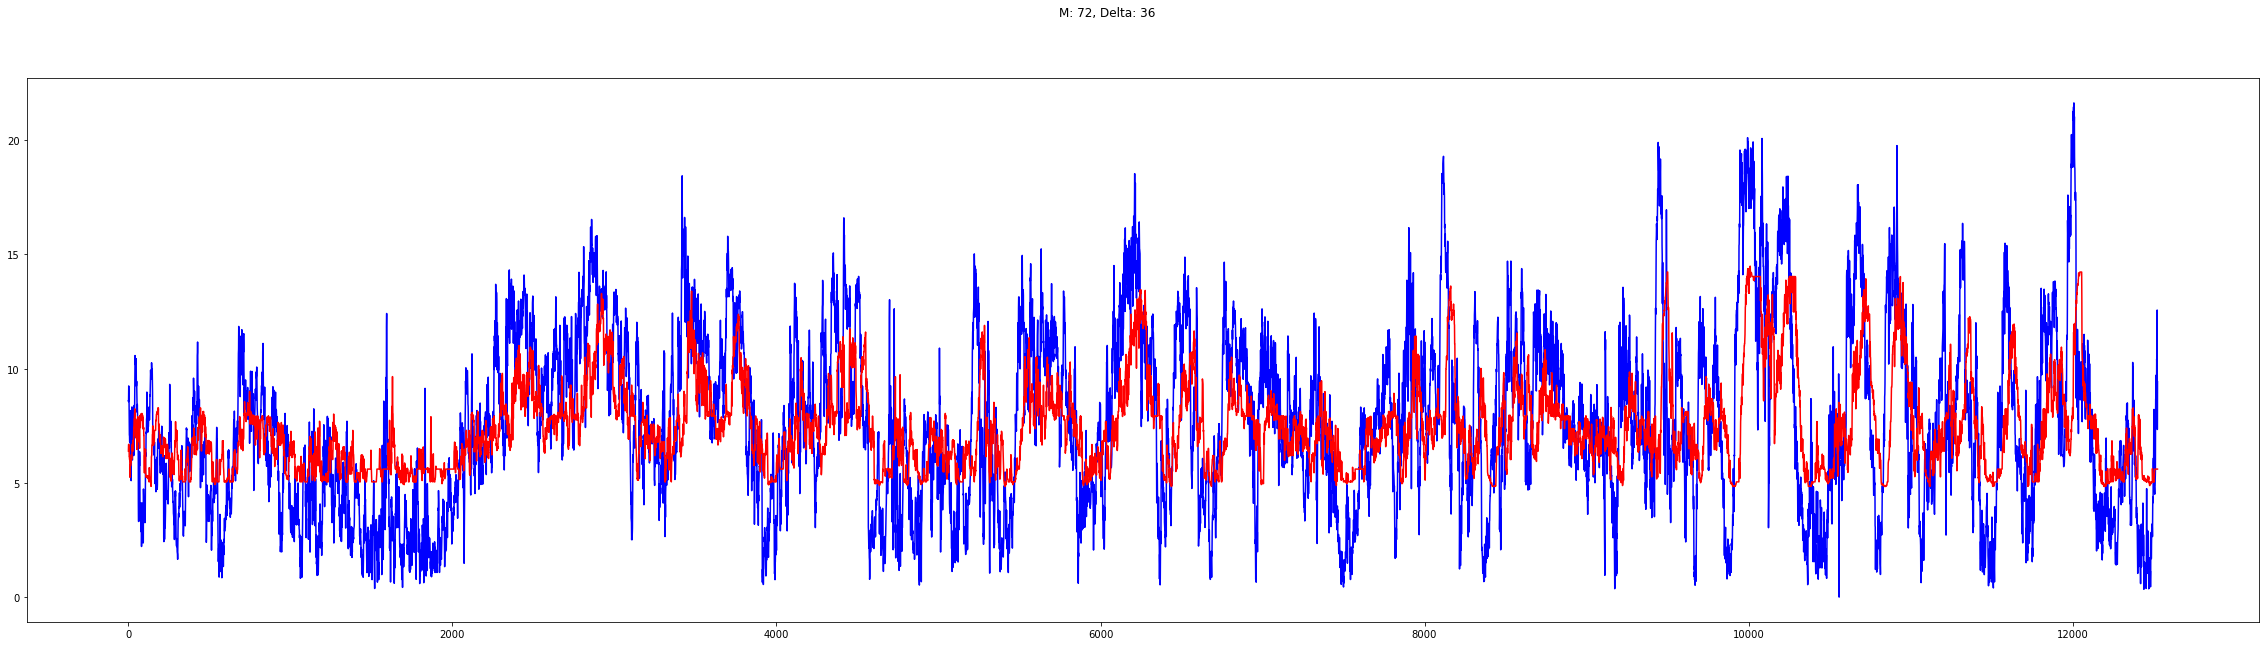

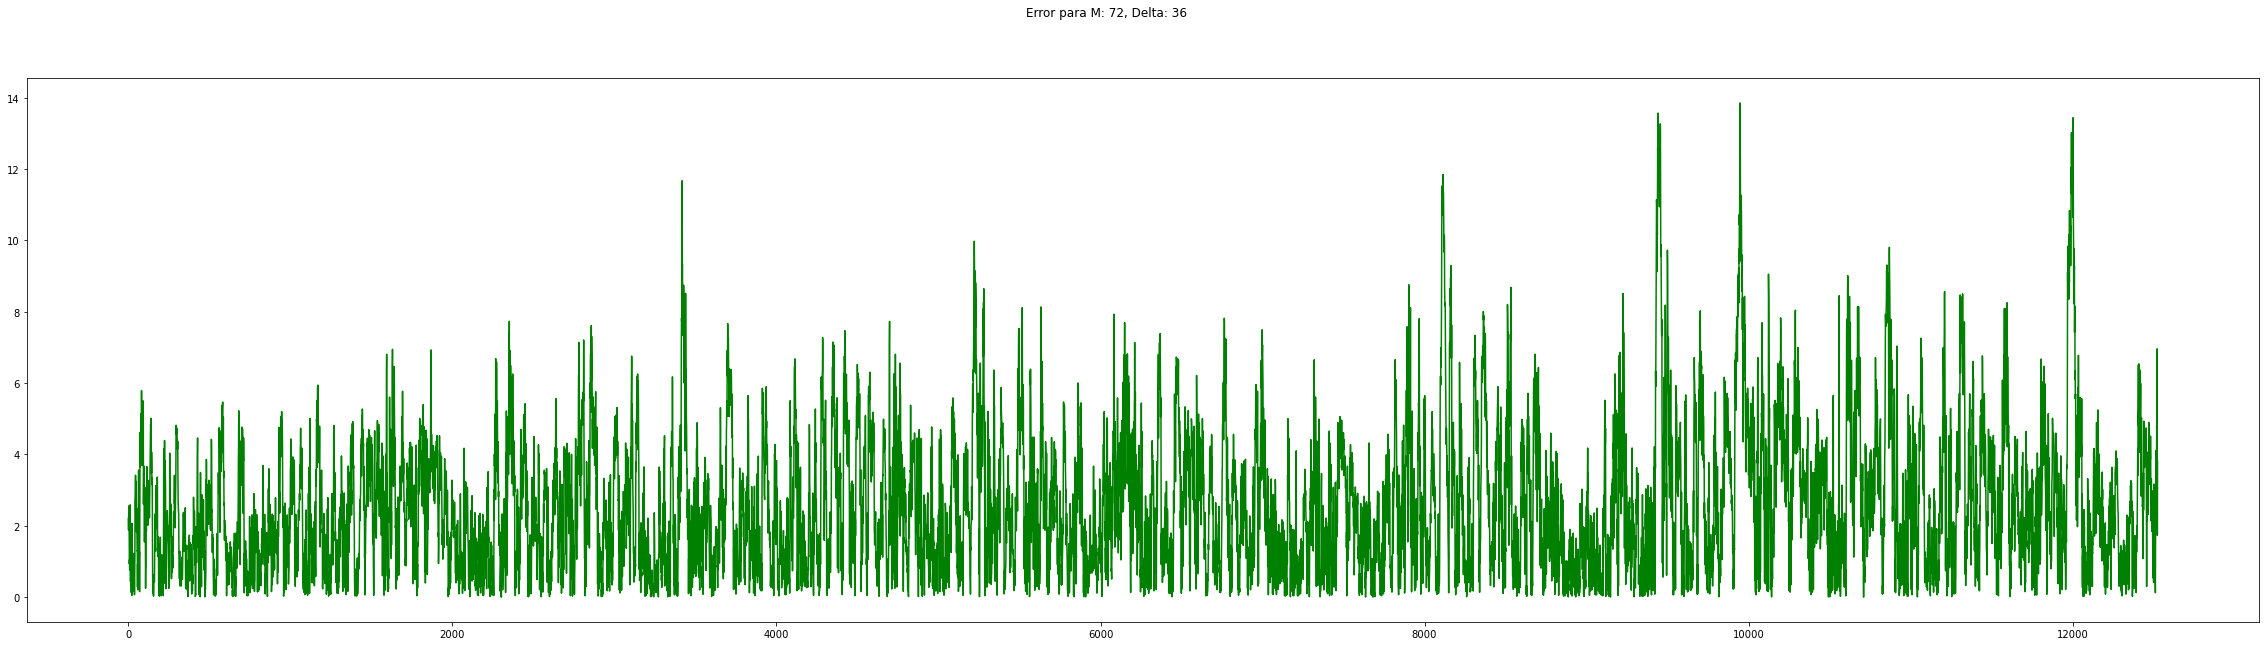

[0]	train-rmse:8.30326	eval-rmse:8.15022
[1]	train-rmse:8.30326	eval-rmse:8.15022
[2]	train-rmse:8.30326	eval-rmse:8.15022
[3]	train-rmse:8.30326	eval-rmse:8.15022
[4]	train-rmse:8.30326	eval-rmse:8.15022
[5]	train-rmse:8.30326	eval-rmse:8.15022
Max. Depth:  0 , ETA:  0.0 ,Best  rmse :  8.150221
[0]	train-rmse:7.73266	eval-rmse:7.54749
[1]	train-rmse:7.23758	eval-rmse:7.01946
[2]	train-rmse:6.81022	eval-rmse:6.55873
[3]	train-rmse:6.44330	eval-rmse:6.15849
[4]	train-rmse:6.13002	eval-rmse:5.81237
[5]	train-rmse:5.86400	eval-rmse:5.51444
[6]	train-rmse:5.63932	eval-rmse:5.25919
[7]	train-rmse:5.45055	eval-rmse:5.04148
[8]	train-rmse:5.29271	eval-rmse:4.85662
[9]	train-rmse:5.16131	eval-rmse:4.70026
[10]	train-rmse:5.05238	eval-rmse:4.56851
[11]	train-rmse:4.96239	eval-rmse:4.45784
[12]	train-rmse:4.88828	eval-rmse:4.36512
[13]	train-rmse:4.82742	eval-rmse:4.28763
[14]	train-rmse:4.77755	eval-rmse:4.22298
[15]	train-rmse:4.73677	eval-rmse:4.16911
[16]	train-rmse:4.70348	eval-rmse:4.12425

[2]	train-rmse:5.14297	eval-rmse:4.67823
[3]	train-rmse:4.85386	eval-rmse:4.32148
[4]	train-rmse:4.70571	eval-rmse:4.12729
[5]	train-rmse:4.63139	eval-rmse:4.02286
[6]	train-rmse:4.59452	eval-rmse:3.96653
[7]	train-rmse:4.57635	eval-rmse:3.93570
[8]	train-rmse:4.56742	eval-rmse:3.91845
[9]	train-rmse:4.56304	eval-rmse:3.90851
[10]	train-rmse:4.56089	eval-rmse:3.90262
[11]	train-rmse:4.55983	eval-rmse:3.89902
[12]	train-rmse:4.55932	eval-rmse:3.89676
[13]	train-rmse:4.55907	eval-rmse:3.89530
[14]	train-rmse:4.55894	eval-rmse:3.89434
[15]	train-rmse:4.55888	eval-rmse:3.89370
[16]	train-rmse:4.55885	eval-rmse:3.89326
[17]	train-rmse:4.55884	eval-rmse:3.89297
[18]	train-rmse:4.55883	eval-rmse:3.89277
[19]	train-rmse:4.55882	eval-rmse:3.89262
[20]	train-rmse:4.55882	eval-rmse:3.89253
[21]	train-rmse:4.55882	eval-rmse:3.89246
[22]	train-rmse:4.55882	eval-rmse:3.89241
[23]	train-rmse:4.55882	eval-rmse:3.89238
[24]	train-rmse:4.55882	eval-rmse:3.89235
[25]	train-rmse:4.55882	eval-rmse:3.89234


[33]	train-rmse:4.27111	eval-rmse:3.65234
[34]	train-rmse:4.26882	eval-rmse:3.65140
[35]	train-rmse:4.26670	eval-rmse:3.64975
[36]	train-rmse:4.26482	eval-rmse:3.64420
[37]	train-rmse:4.26302	eval-rmse:3.64464
[38]	train-rmse:4.26132	eval-rmse:3.64350
[39]	train-rmse:4.25974	eval-rmse:3.64326
[40]	train-rmse:4.25830	eval-rmse:3.64239
[41]	train-rmse:4.25690	eval-rmse:3.64351
[42]	train-rmse:4.25554	eval-rmse:3.63895
[43]	train-rmse:4.25431	eval-rmse:3.63949
[44]	train-rmse:4.25312	eval-rmse:3.63836
[45]	train-rmse:4.25195	eval-rmse:3.63800
[46]	train-rmse:4.25086	eval-rmse:3.63933
[47]	train-rmse:4.24976	eval-rmse:3.63674
[48]	train-rmse:4.24872	eval-rmse:3.63653
[49]	train-rmse:4.24774	eval-rmse:3.63344
[50]	train-rmse:4.24676	eval-rmse:3.63499
[51]	train-rmse:4.24579	eval-rmse:3.63484
[52]	train-rmse:4.24488	eval-rmse:3.63535
[53]	train-rmse:4.24398	eval-rmse:3.63523
Max. Depth:  1 , ETA:  0.1 ,Best  rmse :  3.633439
[0]	train-rmse:7.13726	eval-rmse:6.93219
[1]	train-rmse:6.27636	eva

[32]	train-rmse:4.18409	eval-rmse:3.66761
[33]	train-rmse:4.18123	eval-rmse:3.66452
[34]	train-rmse:4.17788	eval-rmse:3.66222
[35]	train-rmse:4.17478	eval-rmse:3.65833
[36]	train-rmse:4.17262	eval-rmse:3.65749
[37]	train-rmse:4.17002	eval-rmse:3.65747
[38]	train-rmse:4.16745	eval-rmse:3.65650
[39]	train-rmse:4.16381	eval-rmse:3.65408
[40]	train-rmse:4.16092	eval-rmse:3.65151
[41]	train-rmse:4.15919	eval-rmse:3.65061
[42]	train-rmse:4.15700	eval-rmse:3.64830
[43]	train-rmse:4.15506	eval-rmse:3.64789
[44]	train-rmse:4.15276	eval-rmse:3.64666
[45]	train-rmse:4.15121	eval-rmse:3.64600
[46]	train-rmse:4.14989	eval-rmse:3.64555
[47]	train-rmse:4.14813	eval-rmse:3.64473
[48]	train-rmse:4.14625	eval-rmse:3.64467
[49]	train-rmse:4.14442	eval-rmse:3.64395
[50]	train-rmse:4.14300	eval-rmse:3.64415
[51]	train-rmse:4.14145	eval-rmse:3.64444
[52]	train-rmse:4.13886	eval-rmse:3.64181
[53]	train-rmse:4.13734	eval-rmse:3.64242
[54]	train-rmse:4.13623	eval-rmse:3.64217
[55]	train-rmse:4.13509	eval-rmse:

[26]	train-rmse:4.12575	eval-rmse:3.72824
[27]	train-rmse:4.11639	eval-rmse:3.71794
[28]	train-rmse:4.10928	eval-rmse:3.71373
[29]	train-rmse:4.10410	eval-rmse:3.70811
[30]	train-rmse:4.09959	eval-rmse:3.70275
[31]	train-rmse:4.09300	eval-rmse:3.69962
[32]	train-rmse:4.08927	eval-rmse:3.69561
[33]	train-rmse:4.08356	eval-rmse:3.68956
[34]	train-rmse:4.08060	eval-rmse:3.68639
[35]	train-rmse:4.07563	eval-rmse:3.68496
[36]	train-rmse:4.07221	eval-rmse:3.68324
[37]	train-rmse:4.06650	eval-rmse:3.68166
[38]	train-rmse:4.06410	eval-rmse:3.68000
[39]	train-rmse:4.05912	eval-rmse:3.67822
[40]	train-rmse:4.05445	eval-rmse:3.67738
[41]	train-rmse:4.05194	eval-rmse:3.67589
[42]	train-rmse:4.04789	eval-rmse:3.67389
[43]	train-rmse:4.04400	eval-rmse:3.67191
[44]	train-rmse:4.04193	eval-rmse:3.67095
[45]	train-rmse:4.03929	eval-rmse:3.66993
[46]	train-rmse:4.03760	eval-rmse:3.66922
[47]	train-rmse:4.03312	eval-rmse:3.66817
[48]	train-rmse:4.03089	eval-rmse:3.66841
[49]	train-rmse:4.02697	eval-rmse:

[36]	train-rmse:3.93023	eval-rmse:3.69868
[37]	train-rmse:3.92069	eval-rmse:3.69539
[38]	train-rmse:3.91690	eval-rmse:3.69362
[39]	train-rmse:3.91433	eval-rmse:3.69210
[40]	train-rmse:3.90769	eval-rmse:3.69165
[41]	train-rmse:3.89975	eval-rmse:3.68986
[42]	train-rmse:3.89529	eval-rmse:3.68824
[43]	train-rmse:3.89263	eval-rmse:3.68771
[44]	train-rmse:3.88775	eval-rmse:3.68615
[45]	train-rmse:3.88424	eval-rmse:3.68567
[46]	train-rmse:3.88104	eval-rmse:3.68287
[47]	train-rmse:3.87454	eval-rmse:3.68364
[48]	train-rmse:3.86733	eval-rmse:3.68243
[49]	train-rmse:3.86475	eval-rmse:3.68166
[50]	train-rmse:3.85773	eval-rmse:3.68120
[51]	train-rmse:3.85588	eval-rmse:3.68173
[52]	train-rmse:3.85273	eval-rmse:3.68193
[53]	train-rmse:3.84684	eval-rmse:3.68062
[54]	train-rmse:3.84220	eval-rmse:3.68147
[55]	train-rmse:3.83904	eval-rmse:3.68213
[56]	train-rmse:3.83493	eval-rmse:3.68239
[57]	train-rmse:3.83216	eval-rmse:3.68201
Max. Depth:  4 , ETA:  0.1 ,Best  rmse :  3.680616
[0]	train-rmse:7.09964	ev

[48]	train-rmse:3.63718	eval-rmse:3.71968
[49]	train-rmse:3.63018	eval-rmse:3.71861
[50]	train-rmse:3.62652	eval-rmse:3.71823
[51]	train-rmse:3.62387	eval-rmse:3.71782
[52]	train-rmse:3.61150	eval-rmse:3.71766
[53]	train-rmse:3.60548	eval-rmse:3.71729
[54]	train-rmse:3.59796	eval-rmse:3.71984
[55]	train-rmse:3.59477	eval-rmse:3.72074
[56]	train-rmse:3.58758	eval-rmse:3.72059
[57]	train-rmse:3.57942	eval-rmse:3.72132
Max. Depth:  5 , ETA:  0.1 ,Best  rmse :  3.71729
[0]	train-rmse:7.08824	eval-rmse:6.94083
[1]	train-rmse:6.17872	eval-rmse:6.03564
[2]	train-rmse:5.50458	eval-rmse:5.36617
[3]	train-rmse:5.01722	eval-rmse:4.86703
[4]	train-rmse:4.67516	eval-rmse:4.52234
[5]	train-rmse:4.42294	eval-rmse:4.28247
[6]	train-rmse:4.24577	eval-rmse:4.11291
[7]	train-rmse:4.12555	eval-rmse:3.99109
[8]	train-rmse:4.02587	eval-rmse:3.90469
[9]	train-rmse:3.95676	eval-rmse:3.84946
[10]	train-rmse:3.90717	eval-rmse:3.81381
[11]	train-rmse:3.86446	eval-rmse:3.79107
[12]	train-rmse:3.82380	eval-rmse:3.

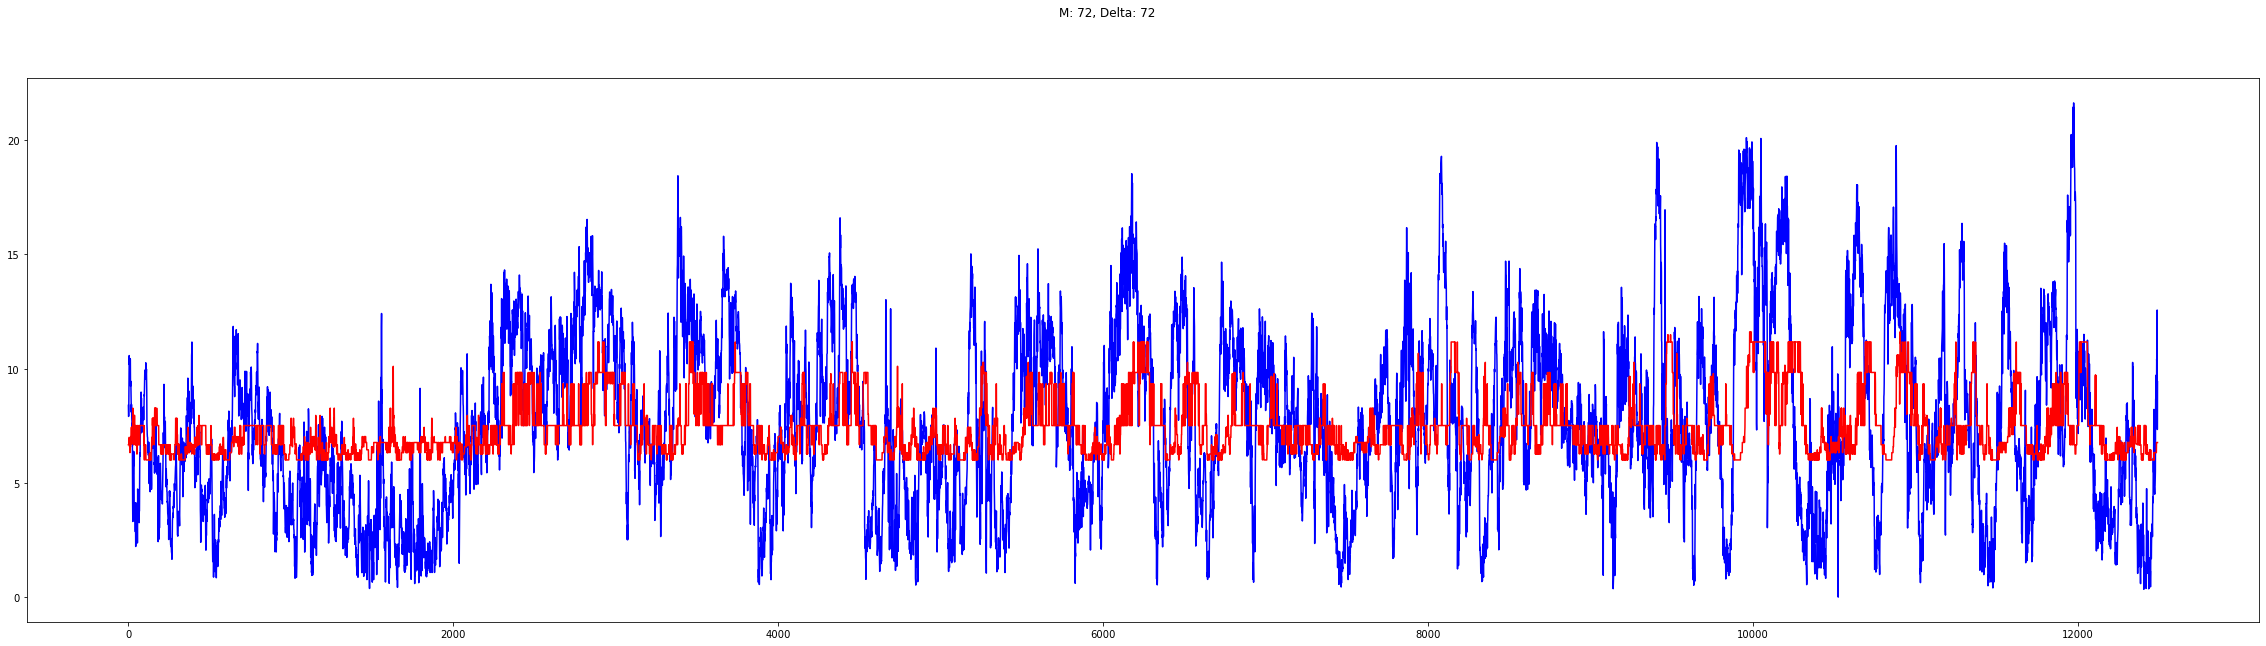

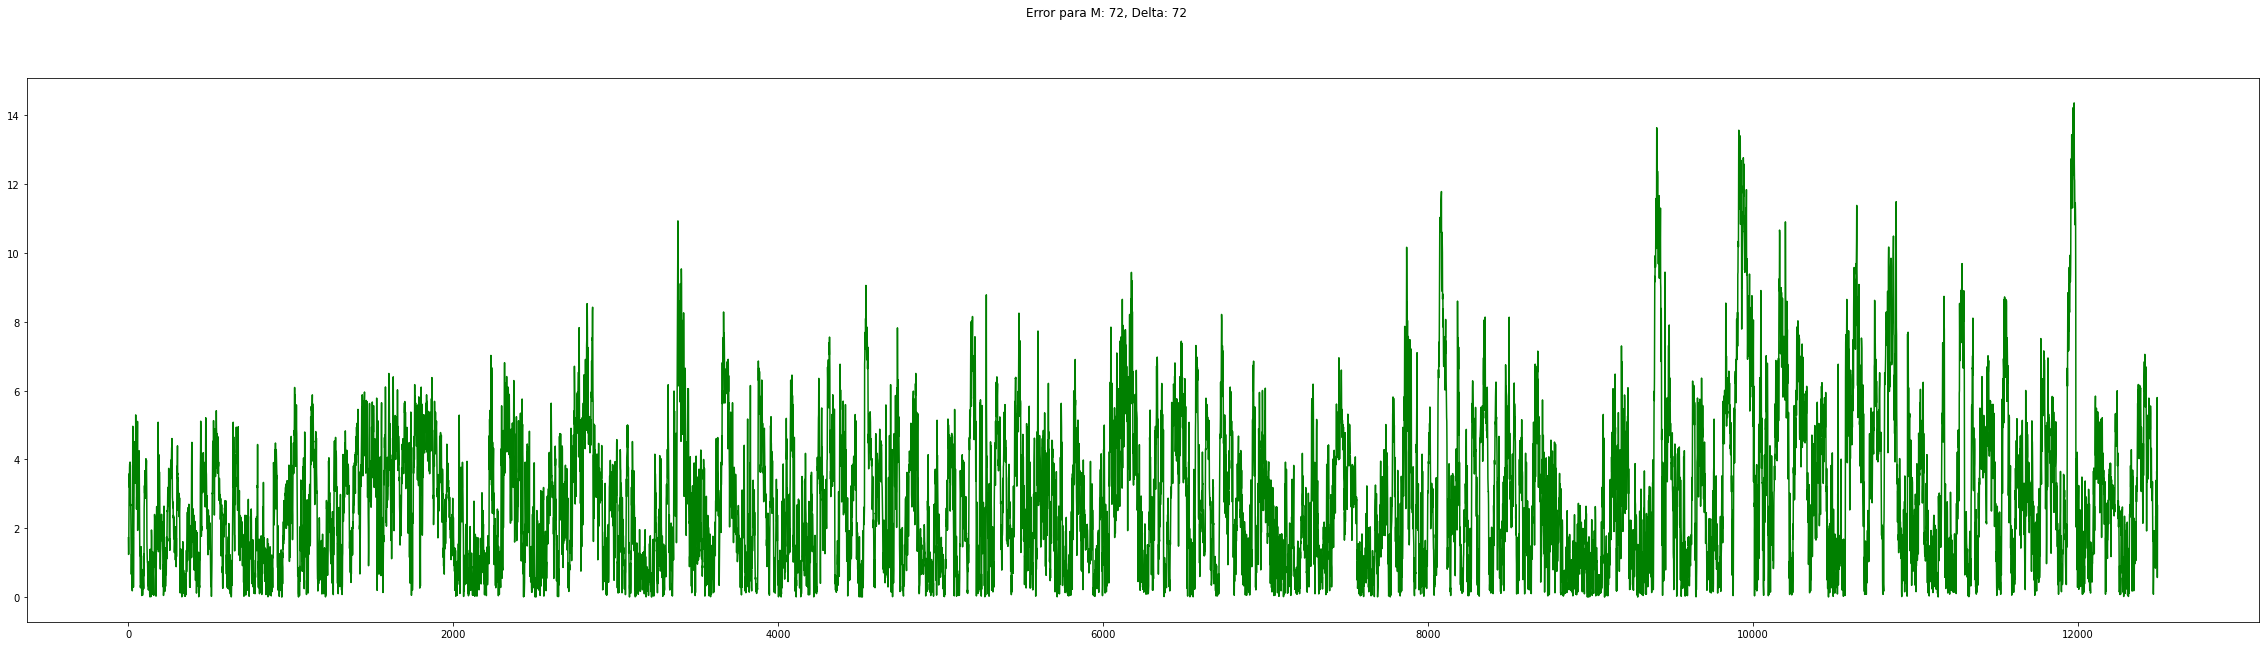

[0]	train-rmse:8.31299	eval-rmse:8.16188
[1]	train-rmse:8.31299	eval-rmse:8.16188
[2]	train-rmse:8.31299	eval-rmse:8.16188
[3]	train-rmse:8.31299	eval-rmse:8.16188
[4]	train-rmse:8.31299	eval-rmse:8.16188
Max. Depth:  0 , ETA:  0.0 ,Best  rmse :  8.161878
[0]	train-rmse:7.74231	eval-rmse:7.55866
[1]	train-rmse:7.24718	eval-rmse:7.03016
[2]	train-rmse:6.81982	eval-rmse:6.56901
[3]	train-rmse:6.45294	eval-rmse:6.16837
[4]	train-rmse:6.13971	eval-rmse:5.82186
[5]	train-rmse:5.87376	eval-rmse:5.52357
[6]	train-rmse:5.64916	eval-rmse:5.26797
[7]	train-rmse:5.46046	eval-rmse:5.04993
[8]	train-rmse:5.30270	eval-rmse:4.86475
[9]	train-rmse:5.17138	eval-rmse:4.70810
[10]	train-rmse:5.06251	eval-rmse:4.57606
[11]	train-rmse:4.97258	eval-rmse:4.46512
[12]	train-rmse:4.89852	eval-rmse:4.37216
[13]	train-rmse:4.83771	eval-rmse:4.29444
[14]	train-rmse:4.78788	eval-rmse:4.22957
[15]	train-rmse:4.74713	eval-rmse:4.17549
[16]	train-rmse:4.71387	eval-rmse:4.13045
[17]	train-rmse:4.68675	eval-rmse:4.0929

[5]	train-rmse:4.64183	eval-rmse:4.02855
[6]	train-rmse:4.60500	eval-rmse:3.97185
[7]	train-rmse:4.58685	eval-rmse:3.94075
[8]	train-rmse:4.57792	eval-rmse:3.92330
[9]	train-rmse:4.57355	eval-rmse:3.91323
[10]	train-rmse:4.57140	eval-rmse:3.90725
[11]	train-rmse:4.57034	eval-rmse:3.90358
[12]	train-rmse:4.56983	eval-rmse:3.90127
[13]	train-rmse:4.56958	eval-rmse:3.89978
[14]	train-rmse:4.56945	eval-rmse:3.89880
[15]	train-rmse:4.56939	eval-rmse:3.89814
[16]	train-rmse:4.56936	eval-rmse:3.89769
[17]	train-rmse:4.56935	eval-rmse:3.89739
[18]	train-rmse:4.56934	eval-rmse:3.89718
[19]	train-rmse:4.56934	eval-rmse:3.89704
[20]	train-rmse:4.56934	eval-rmse:3.89694
[21]	train-rmse:4.56933	eval-rmse:3.89687
[22]	train-rmse:4.56933	eval-rmse:3.89682
[23]	train-rmse:4.56933	eval-rmse:3.89678
[24]	train-rmse:4.56933	eval-rmse:3.89676
[25]	train-rmse:4.56933	eval-rmse:3.89674
[26]	train-rmse:4.56933	eval-rmse:3.89673
[27]	train-rmse:4.56933	eval-rmse:3.89672
[28]	train-rmse:4.56933	eval-rmse:3.896

[32]	train-rmse:1.85208	eval-rmse:1.53456
[33]	train-rmse:1.83593	eval-rmse:1.51847
[34]	train-rmse:1.82086	eval-rmse:1.51246
[35]	train-rmse:1.80735	eval-rmse:1.49870
[36]	train-rmse:1.79519	eval-rmse:1.48965
[37]	train-rmse:1.78387	eval-rmse:1.47905
[38]	train-rmse:1.77348	eval-rmse:1.47555
[39]	train-rmse:1.76407	eval-rmse:1.46717
[40]	train-rmse:1.75538	eval-rmse:1.46331
[41]	train-rmse:1.74729	eval-rmse:1.45542
[42]	train-rmse:1.74009	eval-rmse:1.45335
[43]	train-rmse:1.73347	eval-rmse:1.44728
[44]	train-rmse:1.72732	eval-rmse:1.44339
[45]	train-rmse:1.72169	eval-rmse:1.43862
[46]	train-rmse:1.71644	eval-rmse:1.43732
[47]	train-rmse:1.71144	eval-rmse:1.43241
[48]	train-rmse:1.70713	eval-rmse:1.42843
[49]	train-rmse:1.70300	eval-rmse:1.42723
[50]	train-rmse:1.69918	eval-rmse:1.42441
[51]	train-rmse:1.69554	eval-rmse:1.42220
[52]	train-rmse:1.69232	eval-rmse:1.42152
[53]	train-rmse:1.68922	eval-rmse:1.41910
[54]	train-rmse:1.68637	eval-rmse:1.41855
[55]	train-rmse:1.68375	eval-rmse:

[15]	train-rmse:1.74750	eval-rmse:1.51667
[16]	train-rmse:1.74417	eval-rmse:1.51534
[17]	train-rmse:1.74136	eval-rmse:1.51530
[18]	train-rmse:1.73895	eval-rmse:1.51392
[19]	train-rmse:1.73677	eval-rmse:1.51473
[20]	train-rmse:1.73452	eval-rmse:1.51418
[21]	train-rmse:1.73253	eval-rmse:1.51463
[22]	train-rmse:1.73026	eval-rmse:1.51191
[23]	train-rmse:1.72784	eval-rmse:1.50946
[24]	train-rmse:1.72598	eval-rmse:1.50722
[25]	train-rmse:1.72372	eval-rmse:1.50435
[26]	train-rmse:1.72194	eval-rmse:1.50431
[27]	train-rmse:1.72037	eval-rmse:1.50246
[28]	train-rmse:1.71812	eval-rmse:1.50012
[29]	train-rmse:1.71665	eval-rmse:1.49838
[30]	train-rmse:1.71470	eval-rmse:1.49659
[31]	train-rmse:1.71328	eval-rmse:1.49655
[32]	train-rmse:1.71192	eval-rmse:1.49615
[33]	train-rmse:1.71060	eval-rmse:1.49620
[34]	train-rmse:1.70941	eval-rmse:1.49645
[35]	train-rmse:1.70817	eval-rmse:1.49734
[36]	train-rmse:1.70683	eval-rmse:1.49590
[37]	train-rmse:1.70526	eval-rmse:1.49403
[38]	train-rmse:1.70406	eval-rmse:

[29]	train-rmse:1.74579	eval-rmse:1.53178
[30]	train-rmse:1.74210	eval-rmse:1.52708
[31]	train-rmse:1.73904	eval-rmse:1.52028
[32]	train-rmse:1.73565	eval-rmse:1.51937
[33]	train-rmse:1.73271	eval-rmse:1.51869
[34]	train-rmse:1.72999	eval-rmse:1.51863
[35]	train-rmse:1.72778	eval-rmse:1.51679
[36]	train-rmse:1.72454	eval-rmse:1.51218
[37]	train-rmse:1.72241	eval-rmse:1.50724
[38]	train-rmse:1.71970	eval-rmse:1.50772
[39]	train-rmse:1.71774	eval-rmse:1.50633
[40]	train-rmse:1.71479	eval-rmse:1.50232
[41]	train-rmse:1.71277	eval-rmse:1.49773
[42]	train-rmse:1.71073	eval-rmse:1.49552
[43]	train-rmse:1.70834	eval-rmse:1.49333
[44]	train-rmse:1.70645	eval-rmse:1.49073
[45]	train-rmse:1.70432	eval-rmse:1.48918
[46]	train-rmse:1.70241	eval-rmse:1.48923
[47]	train-rmse:1.70067	eval-rmse:1.48908
[48]	train-rmse:1.69892	eval-rmse:1.48840
[49]	train-rmse:1.69711	eval-rmse:1.48979
[50]	train-rmse:1.69554	eval-rmse:1.49022
[51]	train-rmse:1.69390	eval-rmse:1.49017
[52]	train-rmse:1.69251	eval-rmse:

[34]	train-rmse:1.70203	eval-rmse:1.49013
[35]	train-rmse:1.69958	eval-rmse:1.49031
[36]	train-rmse:1.69761	eval-rmse:1.48972
[37]	train-rmse:1.69444	eval-rmse:1.48706
[38]	train-rmse:1.69198	eval-rmse:1.48379
[39]	train-rmse:1.68959	eval-rmse:1.47903
[40]	train-rmse:1.68577	eval-rmse:1.47327
[41]	train-rmse:1.68342	eval-rmse:1.46858
[42]	train-rmse:1.68135	eval-rmse:1.46836
[43]	train-rmse:1.67927	eval-rmse:1.46708
[44]	train-rmse:1.67709	eval-rmse:1.46545
[45]	train-rmse:1.67512	eval-rmse:1.46542
[46]	train-rmse:1.67290	eval-rmse:1.46539
[47]	train-rmse:1.67140	eval-rmse:1.46623
[48]	train-rmse:1.66988	eval-rmse:1.46627
[49]	train-rmse:1.66851	eval-rmse:1.46693
[50]	train-rmse:1.66707	eval-rmse:1.46688
Max. Depth:  1 , ETA:  0.9 ,Best  rmse :  1.465394
[0]	train-rmse:8.31299	eval-rmse:8.16188
[1]	train-rmse:8.31299	eval-rmse:8.16188
[2]	train-rmse:8.31299	eval-rmse:8.16188
[3]	train-rmse:8.31299	eval-rmse:8.16188
[4]	train-rmse:8.31299	eval-rmse:8.16188
[5]	train-rmse:8.31299	eval-rm

[11]	train-rmse:1.65578	eval-rmse:1.44409
[12]	train-rmse:1.65065	eval-rmse:1.44613
[13]	train-rmse:1.64538	eval-rmse:1.44845
[14]	train-rmse:1.63712	eval-rmse:1.44296
[15]	train-rmse:1.63068	eval-rmse:1.44502
[16]	train-rmse:1.62812	eval-rmse:1.44526
[17]	train-rmse:1.62575	eval-rmse:1.44486
[18]	train-rmse:1.62161	eval-rmse:1.44477
Max. Depth:  2 , ETA:  0.6000000000000001 ,Best  rmse :  1.442963
[0]	train-rmse:3.18119	eval-rmse:2.98517
[1]	train-rmse:1.99366	eval-rmse:1.77567
[2]	train-rmse:1.81617	eval-rmse:1.59956
[3]	train-rmse:1.77918	eval-rmse:1.54101
[4]	train-rmse:1.75674	eval-rmse:1.53260
[5]	train-rmse:1.74764	eval-rmse:1.53226
[6]	train-rmse:1.73457	eval-rmse:1.52857
[7]	train-rmse:1.71491	eval-rmse:1.50155
[8]	train-rmse:1.68891	eval-rmse:1.47654
[9]	train-rmse:1.67927	eval-rmse:1.47727
[10]	train-rmse:1.66983	eval-rmse:1.47638
[11]	train-rmse:1.66558	eval-rmse:1.47622
[12]	train-rmse:1.66010	eval-rmse:1.47572
[13]	train-rmse:1.65380	eval-rmse:1.47977
[14]	train-rmse:1.63

[9]	train-rmse:1.63187	eval-rmse:1.42419
[10]	train-rmse:1.61505	eval-rmse:1.41094
[11]	train-rmse:1.60241	eval-rmse:1.40723
[12]	train-rmse:1.59364	eval-rmse:1.40583
[13]	train-rmse:1.58545	eval-rmse:1.40471
[14]	train-rmse:1.58130	eval-rmse:1.40313
[15]	train-rmse:1.57383	eval-rmse:1.40400
[16]	train-rmse:1.56771	eval-rmse:1.40380
[17]	train-rmse:1.56180	eval-rmse:1.40319
[18]	train-rmse:1.55902	eval-rmse:1.40275
[19]	train-rmse:1.55459	eval-rmse:1.40352
[20]	train-rmse:1.54894	eval-rmse:1.40436
[21]	train-rmse:1.54593	eval-rmse:1.40447
[22]	train-rmse:1.54422	eval-rmse:1.40435
[23]	train-rmse:1.54133	eval-rmse:1.40431
Max. Depth:  3 , ETA:  0.30000000000000004 ,Best  rmse :  1.402755
[0]	train-rmse:5.18798	eval-rmse:5.05131
[1]	train-rmse:3.40413	eval-rmse:3.25610
[2]	train-rmse:2.44284	eval-rmse:2.26763
[3]	train-rmse:1.97548	eval-rmse:1.77382
[4]	train-rmse:1.77070	eval-rmse:1.55440
[5]	train-rmse:1.68214	eval-rmse:1.46945
[6]	train-rmse:1.64135	eval-rmse:1.43189
[7]	train-rmse:1.

[5]	train-rmse:1.87426	eval-rmse:1.70707
[6]	train-rmse:1.73001	eval-rmse:1.56800
[7]	train-rmse:1.64584	eval-rmse:1.48867
[8]	train-rmse:1.59949	eval-rmse:1.44647
[9]	train-rmse:1.56961	eval-rmse:1.42724
[10]	train-rmse:1.54883	eval-rmse:1.41935
[11]	train-rmse:1.53589	eval-rmse:1.41404
[12]	train-rmse:1.52172	eval-rmse:1.41394
[13]	train-rmse:1.51235	eval-rmse:1.41083
[14]	train-rmse:1.50582	eval-rmse:1.41111
[15]	train-rmse:1.49539	eval-rmse:1.41046
[16]	train-rmse:1.48652	eval-rmse:1.41024
[17]	train-rmse:1.48429	eval-rmse:1.41040
[18]	train-rmse:1.47778	eval-rmse:1.41122
[19]	train-rmse:1.47227	eval-rmse:1.41209
[20]	train-rmse:1.46719	eval-rmse:1.41263
Max. Depth:  4 , ETA:  0.30000000000000004 ,Best  rmse :  1.410245
[0]	train-rmse:5.17149	eval-rmse:5.03909
[1]	train-rmse:3.37527	eval-rmse:3.23354
[2]	train-rmse:2.40956	eval-rmse:2.24570
[3]	train-rmse:1.93420	eval-rmse:1.76471
[4]	train-rmse:1.71848	eval-rmse:1.55364
[5]	train-rmse:1.61983	eval-rmse:1.46224
[6]	train-rmse:1.575

[2]	train-rmse:2.37836	eval-rmse:2.25163
[3]	train-rmse:1.89019	eval-rmse:1.76583
[4]	train-rmse:1.66058	eval-rmse:1.55654
[5]	train-rmse:1.55328	eval-rmse:1.47220
[6]	train-rmse:1.50044	eval-rmse:1.43782
[7]	train-rmse:1.46841	eval-rmse:1.42836
[8]	train-rmse:1.44889	eval-rmse:1.42271
[9]	train-rmse:1.42448	eval-rmse:1.42495
[10]	train-rmse:1.40980	eval-rmse:1.42880
[11]	train-rmse:1.39259	eval-rmse:1.43044
[12]	train-rmse:1.38612	eval-rmse:1.43118
Max. Depth:  5 , ETA:  0.4 ,Best  rmse :  1.422709
[0]	train-rmse:4.40054	eval-rmse:4.27643
[1]	train-rmse:2.60219	eval-rmse:2.46903
[2]	train-rmse:1.87896	eval-rmse:1.74580
[3]	train-rmse:1.61997	eval-rmse:1.50856
[4]	train-rmse:1.52463	eval-rmse:1.44699
[5]	train-rmse:1.47923	eval-rmse:1.43431
[6]	train-rmse:1.45504	eval-rmse:1.43158
[7]	train-rmse:1.43259	eval-rmse:1.43407
[8]	train-rmse:1.42062	eval-rmse:1.43530
[9]	train-rmse:1.40516	eval-rmse:1.43752
[10]	train-rmse:1.39423	eval-rmse:1.43904
[11]	train-rmse:1.38233	eval-rmse:1.44005
M

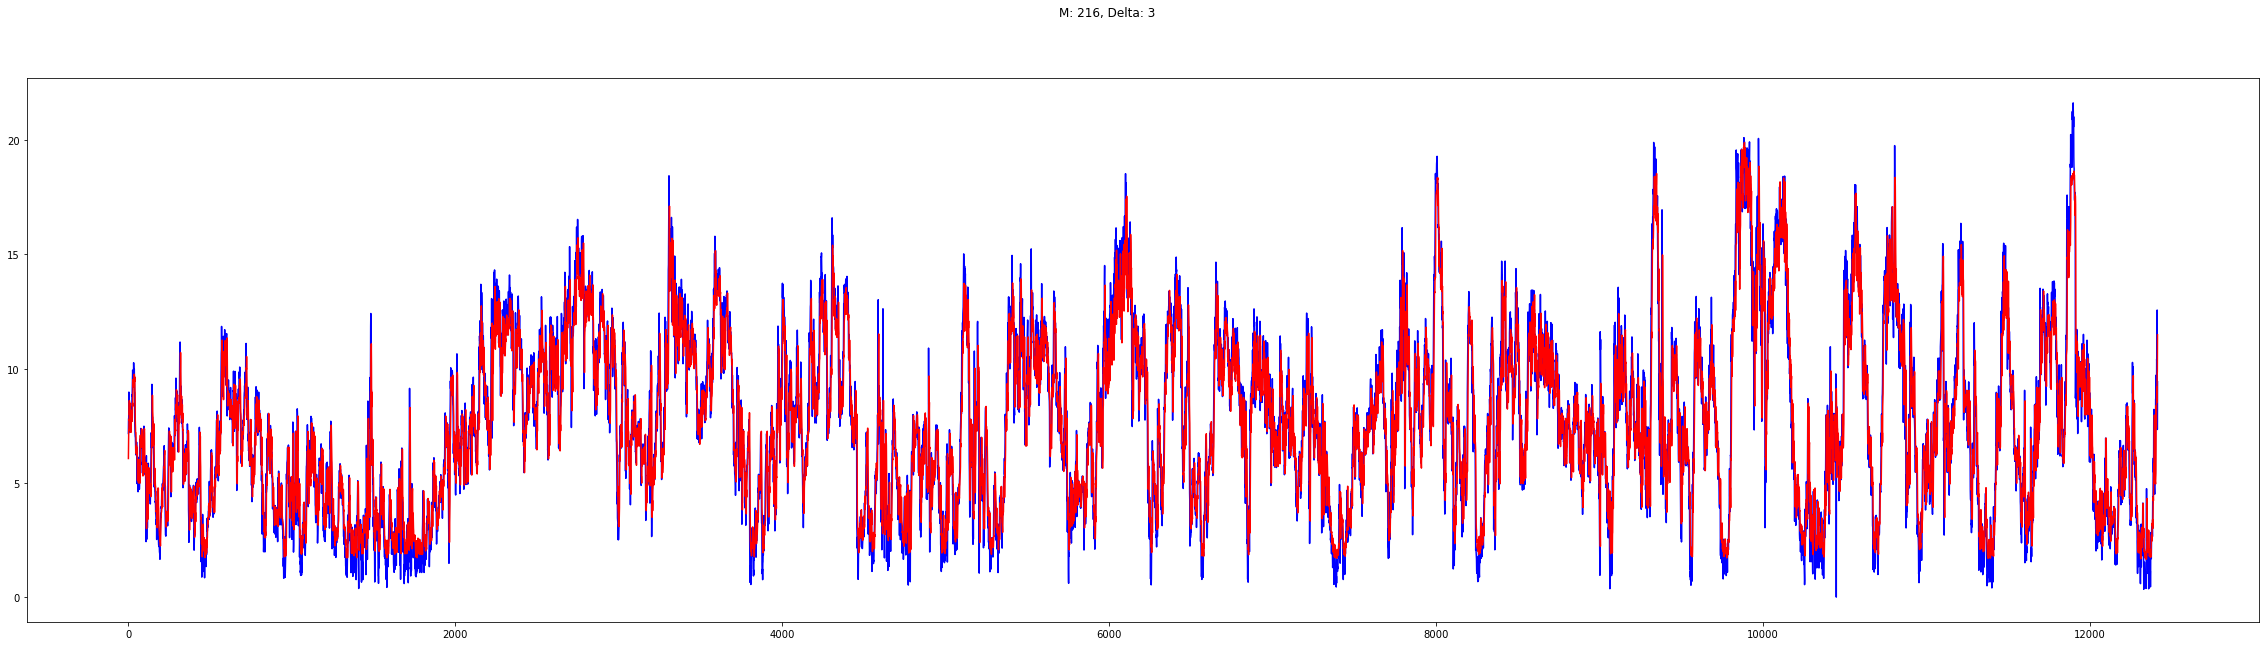

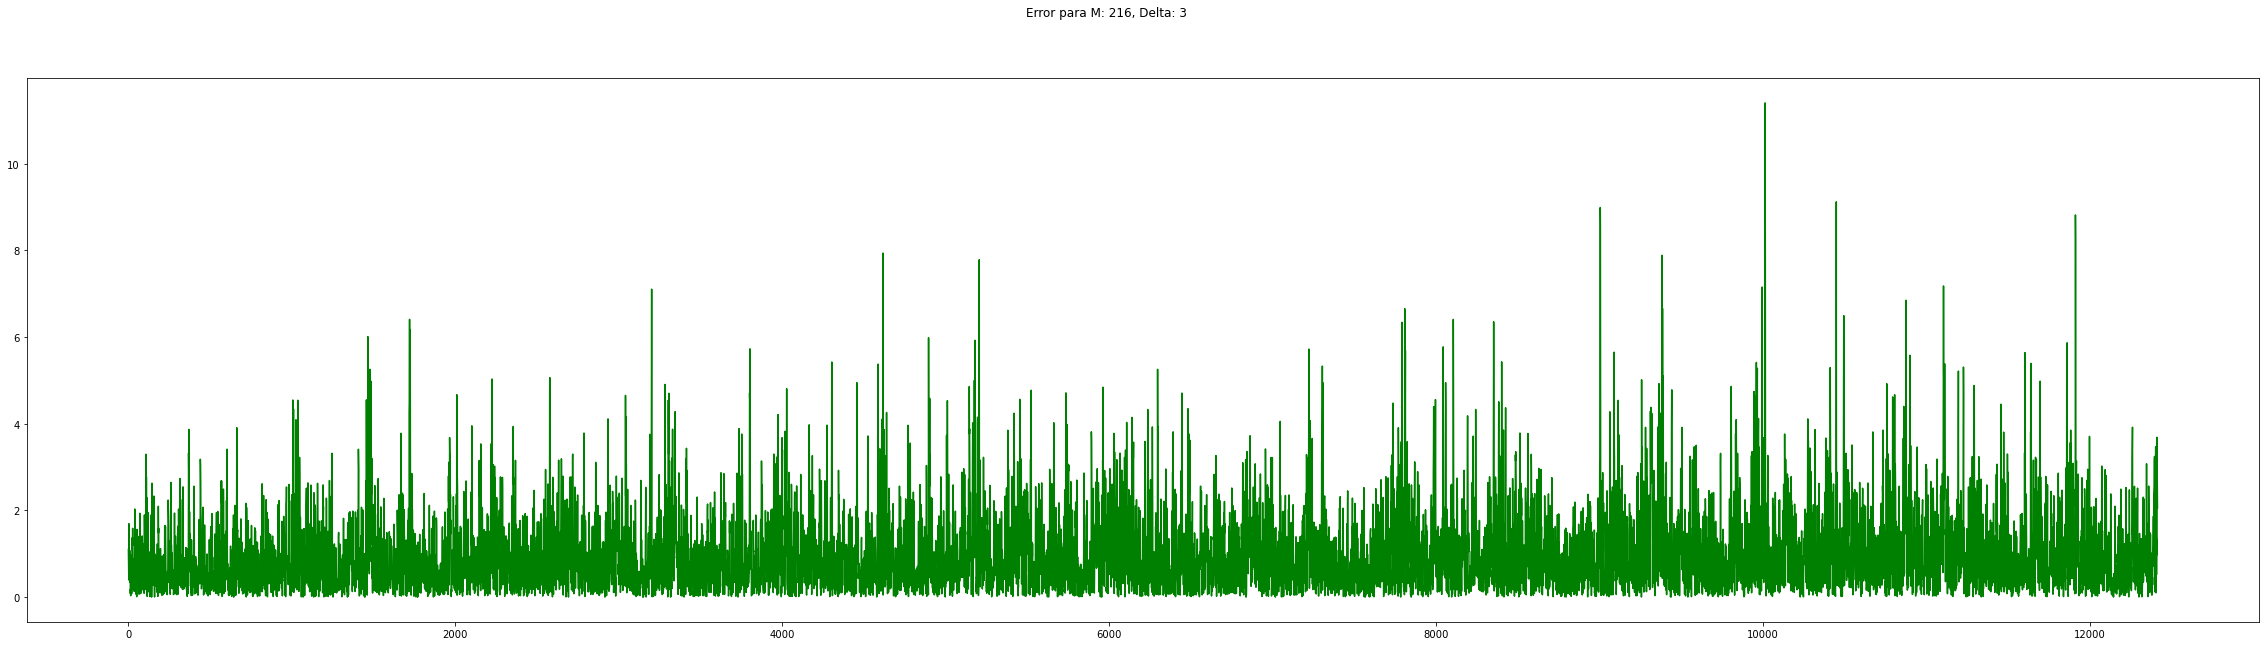

[0]	train-rmse:8.31799	eval-rmse:8.16227
[1]	train-rmse:8.31799	eval-rmse:8.16227
[2]	train-rmse:8.31799	eval-rmse:8.16227
[3]	train-rmse:8.31799	eval-rmse:8.16227
[4]	train-rmse:8.31799	eval-rmse:8.16227
Max. Depth:  0 , ETA:  0.0 ,Best  rmse :  8.162272
[0]	train-rmse:7.74715	eval-rmse:7.55901
[1]	train-rmse:7.25190	eval-rmse:7.03052
[2]	train-rmse:6.82443	eval-rmse:6.56942
[3]	train-rmse:6.45747	eval-rmse:6.16887
[4]	train-rmse:6.14419	eval-rmse:5.82249
[5]	train-rmse:5.87819	eval-rmse:5.52435
[6]	train-rmse:5.65357	eval-rmse:5.26893
[7]	train-rmse:5.46485	eval-rmse:5.05109
[8]	train-rmse:5.30707	eval-rmse:4.86611
[9]	train-rmse:5.17575	eval-rmse:4.70966
[10]	train-rmse:5.06687	eval-rmse:4.57783
[11]	train-rmse:4.97694	eval-rmse:4.46709
[12]	train-rmse:4.90288	eval-rmse:4.37432
[13]	train-rmse:4.84206	eval-rmse:4.29678
[14]	train-rmse:4.79224	eval-rmse:4.23209
[15]	train-rmse:4.75149	eval-rmse:4.17818
[16]	train-rmse:4.71823	eval-rmse:4.13330
[17]	train-rmse:4.69111	eval-rmse:4.0959

[2]	train-rmse:5.15741	eval-rmse:4.68761
[3]	train-rmse:4.86849	eval-rmse:4.33065
[4]	train-rmse:4.72046	eval-rmse:4.13634
[5]	train-rmse:4.64620	eval-rmse:4.03183
[6]	train-rmse:4.60937	eval-rmse:3.97545
[7]	train-rmse:4.59122	eval-rmse:3.94458
[8]	train-rmse:4.58229	eval-rmse:3.92729
[9]	train-rmse:4.57791	eval-rmse:3.91734
[10]	train-rmse:4.57577	eval-rmse:3.91144
[11]	train-rmse:4.57472	eval-rmse:3.90783
[12]	train-rmse:4.57420	eval-rmse:3.90556
[13]	train-rmse:4.57395	eval-rmse:3.90410
[14]	train-rmse:4.57382	eval-rmse:3.90313
[15]	train-rmse:4.57376	eval-rmse:3.90249
[16]	train-rmse:4.57373	eval-rmse:3.90205
[17]	train-rmse:4.57372	eval-rmse:3.90176
[18]	train-rmse:4.57371	eval-rmse:3.90155
[19]	train-rmse:4.57371	eval-rmse:3.90141
[20]	train-rmse:4.57371	eval-rmse:3.90131
[21]	train-rmse:4.57370	eval-rmse:3.90124
[22]	train-rmse:4.57371	eval-rmse:3.90120
[23]	train-rmse:4.57370	eval-rmse:3.90116
[24]	train-rmse:4.57370	eval-rmse:3.90114
[25]	train-rmse:4.57371	eval-rmse:3.90112


[22]	train-rmse:3.92636	eval-rmse:3.38974
[23]	train-rmse:3.91003	eval-rmse:3.37056
[24]	train-rmse:3.89574	eval-rmse:3.35899
[25]	train-rmse:3.88354	eval-rmse:3.35008
[26]	train-rmse:3.87267	eval-rmse:3.33181
[27]	train-rmse:3.86321	eval-rmse:3.32083
[28]	train-rmse:3.85455	eval-rmse:3.31281
[29]	train-rmse:3.84703	eval-rmse:3.30789
[30]	train-rmse:3.84035	eval-rmse:3.30545
[31]	train-rmse:3.83416	eval-rmse:3.29480
[32]	train-rmse:3.82864	eval-rmse:3.28826
[33]	train-rmse:3.82354	eval-rmse:3.27884
[34]	train-rmse:3.81892	eval-rmse:3.27664
[35]	train-rmse:3.81476	eval-rmse:3.27252
[36]	train-rmse:3.81094	eval-rmse:3.27133
[37]	train-rmse:3.80742	eval-rmse:3.26451
[38]	train-rmse:3.80399	eval-rmse:3.26416
[39]	train-rmse:3.80063	eval-rmse:3.26460
[40]	train-rmse:3.79759	eval-rmse:3.26274
[41]	train-rmse:3.79458	eval-rmse:3.26297
[42]	train-rmse:3.79171	eval-rmse:3.26115
[43]	train-rmse:3.78911	eval-rmse:3.26156
[44]	train-rmse:3.78648	eval-rmse:3.25648
[45]	train-rmse:3.78401	eval-rmse:

[6]	train-rmse:5.22133	eval-rmse:4.90615
[7]	train-rmse:4.98600	eval-rmse:4.64725
[8]	train-rmse:4.78618	eval-rmse:4.42748
[9]	train-rmse:4.61606	eval-rmse:4.23288
[10]	train-rmse:4.47206	eval-rmse:4.08870
[11]	train-rmse:4.34974	eval-rmse:3.95494
[12]	train-rmse:4.24759	eval-rmse:3.83943
[13]	train-rmse:4.16154	eval-rmse:3.73898
[14]	train-rmse:4.08778	eval-rmse:3.66277
[15]	train-rmse:4.02593	eval-rmse:3.60395
[16]	train-rmse:3.97445	eval-rmse:3.55089
[17]	train-rmse:3.93095	eval-rmse:3.50008
[18]	train-rmse:3.89378	eval-rmse:3.45871
[19]	train-rmse:3.86223	eval-rmse:3.42651
[20]	train-rmse:3.83559	eval-rmse:3.40593
[21]	train-rmse:3.81195	eval-rmse:3.37829
[22]	train-rmse:3.79146	eval-rmse:3.36357
[23]	train-rmse:3.77330	eval-rmse:3.34444
[24]	train-rmse:3.75746	eval-rmse:3.33605
[25]	train-rmse:3.74313	eval-rmse:3.32086
[26]	train-rmse:3.73112	eval-rmse:3.31489
[27]	train-rmse:3.72072	eval-rmse:3.30523
[28]	train-rmse:3.71033	eval-rmse:3.29734
[29]	train-rmse:3.70141	eval-rmse:3.29

[14]	train-rmse:3.95261	eval-rmse:3.68962
[15]	train-rmse:3.88568	eval-rmse:3.62185
[16]	train-rmse:3.82620	eval-rmse:3.56608
[17]	train-rmse:3.77470	eval-rmse:3.51623
[18]	train-rmse:3.73240	eval-rmse:3.47877
[19]	train-rmse:3.69755	eval-rmse:3.44634
[20]	train-rmse:3.66441	eval-rmse:3.41717
[21]	train-rmse:3.63679	eval-rmse:3.39312
[22]	train-rmse:3.61459	eval-rmse:3.37952
[23]	train-rmse:3.59115	eval-rmse:3.36367
[24]	train-rmse:3.57204	eval-rmse:3.34696
[25]	train-rmse:3.55485	eval-rmse:3.34082
[26]	train-rmse:3.53778	eval-rmse:3.32619
[27]	train-rmse:3.52583	eval-rmse:3.32033
[28]	train-rmse:3.50972	eval-rmse:3.31692
[29]	train-rmse:3.49757	eval-rmse:3.31027
[30]	train-rmse:3.48451	eval-rmse:3.30810
[31]	train-rmse:3.47332	eval-rmse:3.30133
[32]	train-rmse:3.46498	eval-rmse:3.29824
[33]	train-rmse:3.45543	eval-rmse:3.29617
[34]	train-rmse:3.44566	eval-rmse:3.29118
[35]	train-rmse:3.43710	eval-rmse:3.29012
[36]	train-rmse:3.43165	eval-rmse:3.28857
[37]	train-rmse:3.42325	eval-rmse:

[18]	train-rmse:3.55430	eval-rmse:3.53836
[19]	train-rmse:3.51483	eval-rmse:3.50780
[20]	train-rmse:3.47695	eval-rmse:3.47980
[21]	train-rmse:3.44498	eval-rmse:3.45627
[22]	train-rmse:3.41359	eval-rmse:3.43757
[23]	train-rmse:3.38440	eval-rmse:3.41684
[24]	train-rmse:3.36265	eval-rmse:3.40434
[25]	train-rmse:3.34267	eval-rmse:3.39491
[26]	train-rmse:3.31894	eval-rmse:3.38848
[27]	train-rmse:3.29467	eval-rmse:3.38387
[28]	train-rmse:3.27597	eval-rmse:3.37590
[29]	train-rmse:3.25899	eval-rmse:3.36793
[30]	train-rmse:3.24266	eval-rmse:3.36246
[31]	train-rmse:3.22590	eval-rmse:3.35597
[32]	train-rmse:3.21665	eval-rmse:3.35380
[33]	train-rmse:3.20062	eval-rmse:3.34903
[34]	train-rmse:3.19191	eval-rmse:3.34716
[35]	train-rmse:3.17770	eval-rmse:3.34293
[36]	train-rmse:3.16454	eval-rmse:3.33881
[37]	train-rmse:3.15220	eval-rmse:3.33702
[38]	train-rmse:3.14449	eval-rmse:3.33737
[39]	train-rmse:3.13205	eval-rmse:3.33304
[40]	train-rmse:3.12153	eval-rmse:3.33297
[41]	train-rmse:3.11410	eval-rmse:

[33]	train-rmse:2.89370	eval-rmse:3.38550
[34]	train-rmse:2.87618	eval-rmse:3.38367
[35]	train-rmse:2.85780	eval-rmse:3.37834
[36]	train-rmse:2.84563	eval-rmse:3.37784
[37]	train-rmse:2.83136	eval-rmse:3.37479
[38]	train-rmse:2.81148	eval-rmse:3.37165
[39]	train-rmse:2.79468	eval-rmse:3.37543
[40]	train-rmse:2.78132	eval-rmse:3.37455
[41]	train-rmse:2.77444	eval-rmse:3.37333
[42]	train-rmse:2.76292	eval-rmse:3.37253
Max. Depth:  5 , ETA:  0.1 ,Best  rmse :  3.371652
[0]	train-rmse:6.99332	eval-rmse:6.87053
[1]	train-rmse:5.97611	eval-rmse:5.89122
[2]	train-rmse:5.21245	eval-rmse:5.16226
[3]	train-rmse:4.63856	eval-rmse:4.62625
[4]	train-rmse:4.21491	eval-rmse:4.23888
[5]	train-rmse:3.90130	eval-rmse:3.97308
[6]	train-rmse:3.66703	eval-rmse:3.80373
[7]	train-rmse:3.48952	eval-rmse:3.68399
[8]	train-rmse:3.36037	eval-rmse:3.60489
[9]	train-rmse:3.26123	eval-rmse:3.55036
[10]	train-rmse:3.18555	eval-rmse:3.51050
[11]	train-rmse:3.13009	eval-rmse:3.46935
[12]	train-rmse:3.08090	eval-rmse:3

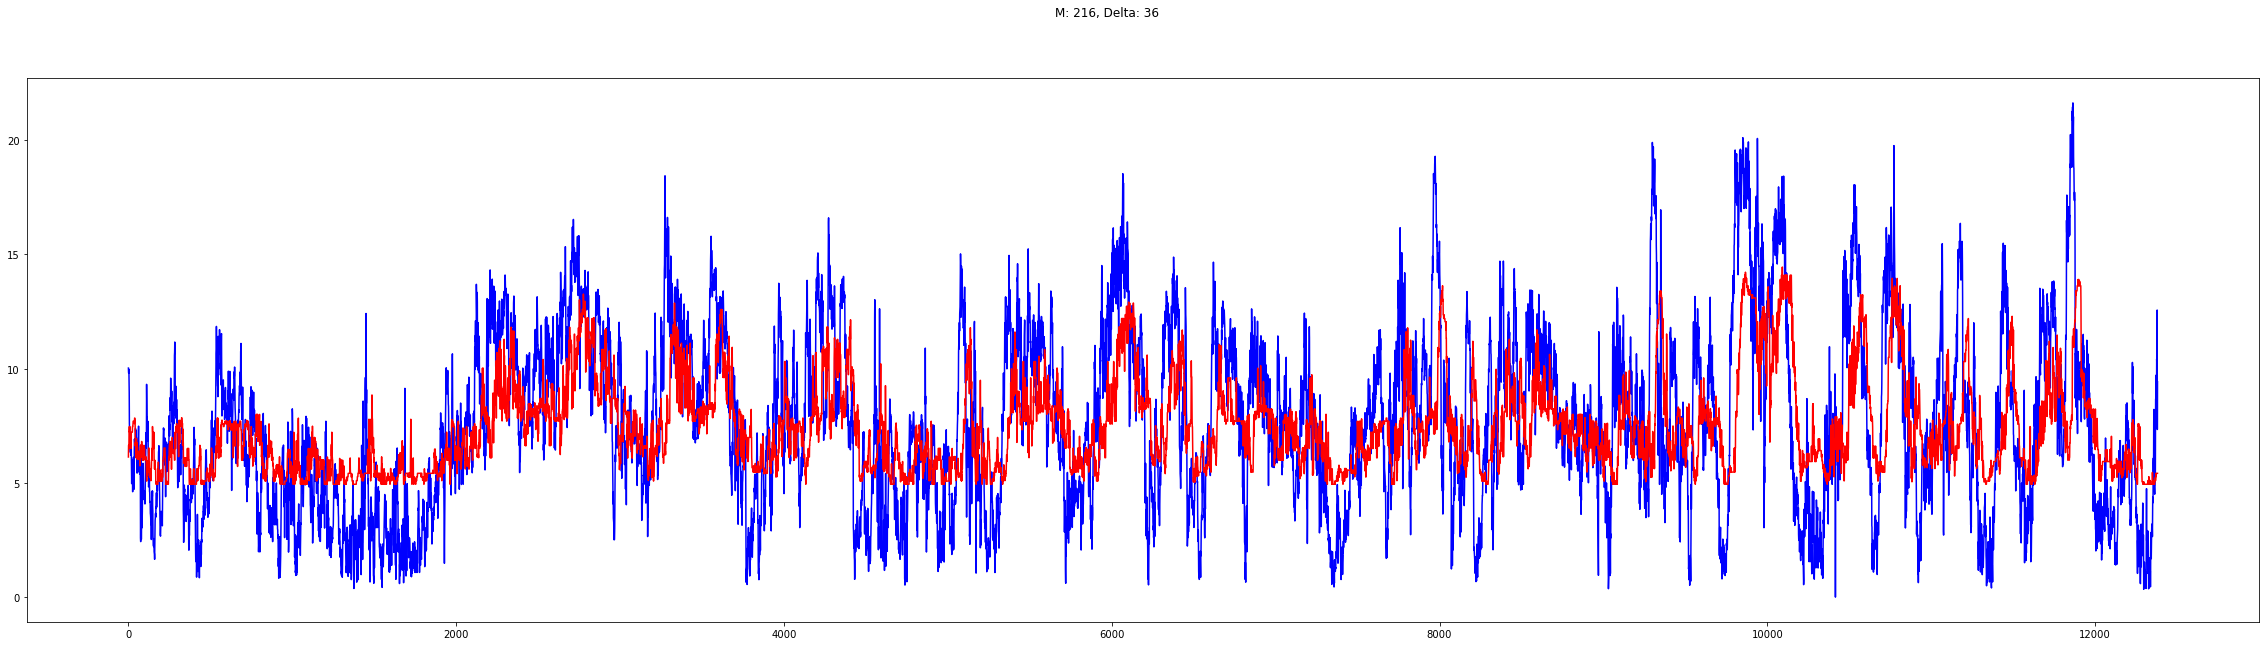

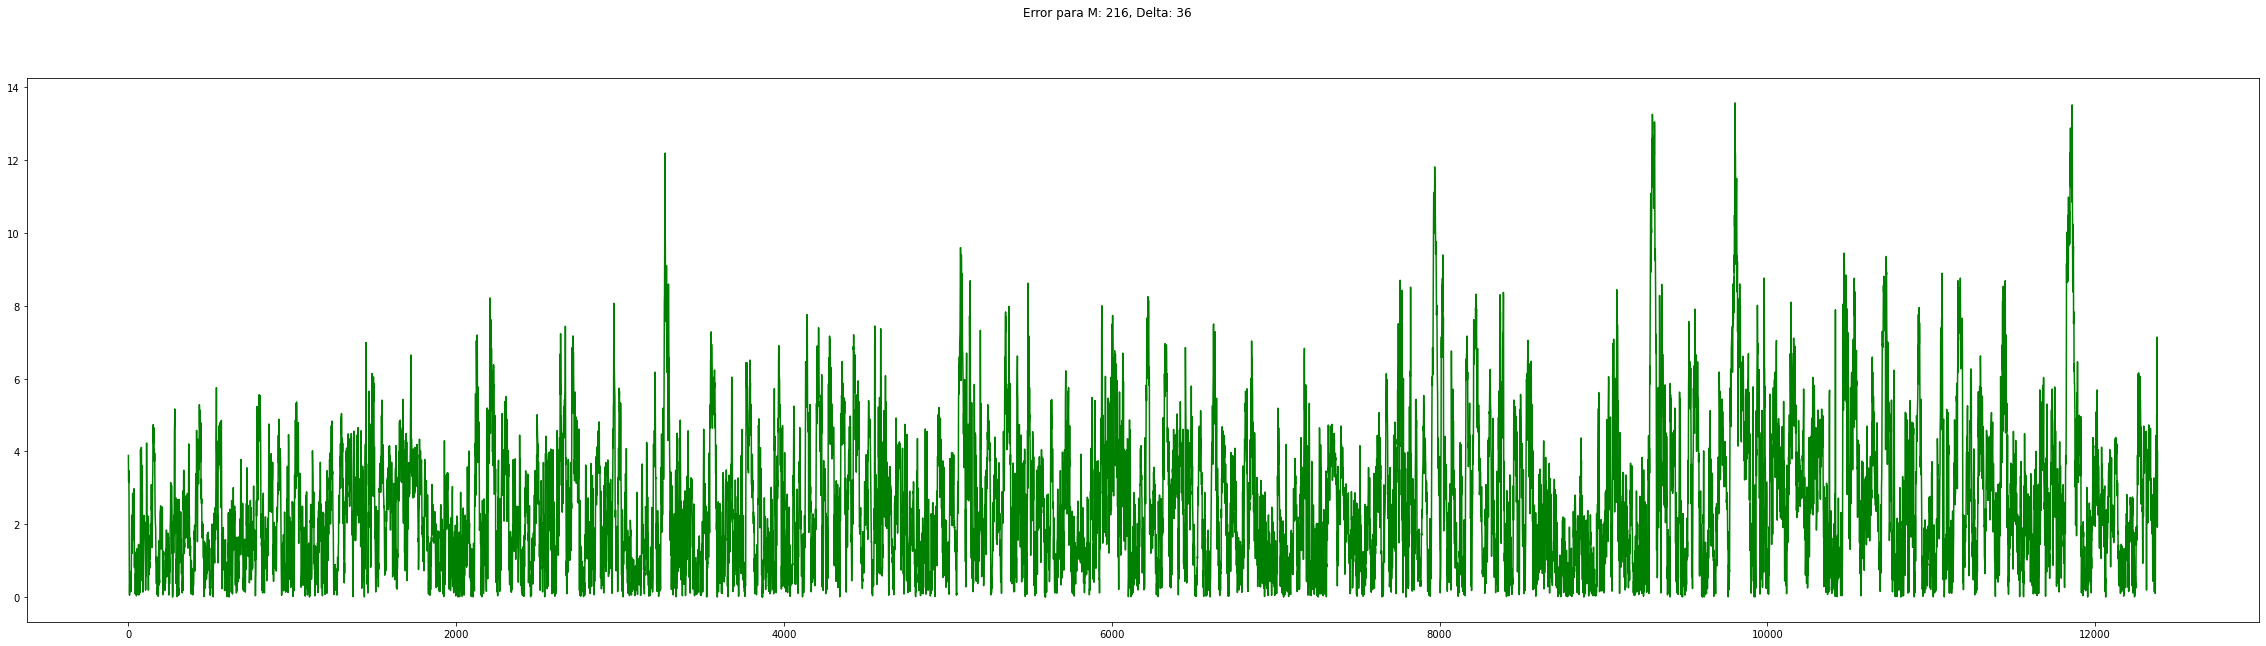

[0]	train-rmse:8.32416	eval-rmse:8.16704
[1]	train-rmse:8.32416	eval-rmse:8.16704
[2]	train-rmse:8.32416	eval-rmse:8.16704
[3]	train-rmse:8.32416	eval-rmse:8.16704
[4]	train-rmse:8.32416	eval-rmse:8.16704
Max. Depth:  0 , ETA:  0.0 ,Best  rmse :  8.16704
[0]	train-rmse:7.75318	eval-rmse:7.56358
[1]	train-rmse:7.25783	eval-rmse:7.03494
[2]	train-rmse:6.83031	eval-rmse:6.57372
[3]	train-rmse:6.46331	eval-rmse:6.17308
[4]	train-rmse:6.15000	eval-rmse:5.82664
[5]	train-rmse:5.88400	eval-rmse:5.52846
[6]	train-rmse:5.65937	eval-rmse:5.27301
[7]	train-rmse:5.47067	eval-rmse:5.05516
[8]	train-rmse:5.31291	eval-rmse:4.87017
[9]	train-rmse:5.18159	eval-rmse:4.71373
[10]	train-rmse:5.07274	eval-rmse:4.58191
[11]	train-rmse:4.98282	eval-rmse:4.47119
[12]	train-rmse:4.90878	eval-rmse:4.37844
[13]	train-rmse:4.84797	eval-rmse:4.30092
[14]	train-rmse:4.79816	eval-rmse:4.23624
[15]	train-rmse:4.75742	eval-rmse:4.18235
[16]	train-rmse:4.72417	eval-rmse:4.13748
[17]	train-rmse:4.69706	eval-rmse:4.10014

[1]	train-rmse:5.70757	eval-rmse:5.32813
[2]	train-rmse:5.16326	eval-rmse:4.69168
[3]	train-rmse:4.87439	eval-rmse:4.33477
[4]	train-rmse:4.72640	eval-rmse:4.14052
[5]	train-rmse:4.65216	eval-rmse:4.03606
[6]	train-rmse:4.61534	eval-rmse:3.97971
[7]	train-rmse:4.59719	eval-rmse:3.94887
[8]	train-rmse:4.58827	eval-rmse:3.93160
[9]	train-rmse:4.58390	eval-rmse:3.92166
[10]	train-rmse:4.58175	eval-rmse:3.91577
[11]	train-rmse:4.58070	eval-rmse:3.91216
[12]	train-rmse:4.58018	eval-rmse:3.90989
[13]	train-rmse:4.57993	eval-rmse:3.90843
[14]	train-rmse:4.57981	eval-rmse:3.90747
[15]	train-rmse:4.57974	eval-rmse:3.90683
[16]	train-rmse:4.57972	eval-rmse:3.90640
[17]	train-rmse:4.57970	eval-rmse:3.90610
[18]	train-rmse:4.57969	eval-rmse:3.90590
[19]	train-rmse:4.57969	eval-rmse:3.90576
[20]	train-rmse:4.57969	eval-rmse:3.90566
[21]	train-rmse:4.57969	eval-rmse:3.90559
[22]	train-rmse:4.57969	eval-rmse:3.90554
[23]	train-rmse:4.57969	eval-rmse:3.90551
[24]	train-rmse:4.57968	eval-rmse:3.90548
[

[31]	train-rmse:4.25572	eval-rmse:3.67153
[32]	train-rmse:4.25182	eval-rmse:3.66929
[33]	train-rmse:4.24824	eval-rmse:3.66775
[34]	train-rmse:4.24497	eval-rmse:3.66688
[35]	train-rmse:4.24181	eval-rmse:3.65917
[36]	train-rmse:4.23897	eval-rmse:3.65660
[37]	train-rmse:4.23631	eval-rmse:3.65662
[38]	train-rmse:4.23380	eval-rmse:3.65437
[39]	train-rmse:4.23148	eval-rmse:3.65409
[40]	train-rmse:4.22930	eval-rmse:3.65512
[41]	train-rmse:4.22718	eval-rmse:3.65566
[42]	train-rmse:4.22505	eval-rmse:3.65027
[43]	train-rmse:4.22314	eval-rmse:3.65172
[44]	train-rmse:4.22126	eval-rmse:3.65124
[45]	train-rmse:4.21942	eval-rmse:3.64712
[46]	train-rmse:4.21769	eval-rmse:3.64705
[47]	train-rmse:4.21600	eval-rmse:3.64781
[48]	train-rmse:4.21434	eval-rmse:3.64831
[49]	train-rmse:4.21278	eval-rmse:3.64786
[50]	train-rmse:4.21125	eval-rmse:3.64950
[51]	train-rmse:4.20966	eval-rmse:3.64487
[52]	train-rmse:4.20819	eval-rmse:3.64382
[53]	train-rmse:4.20675	eval-rmse:3.64356
[54]	train-rmse:4.20534	eval-rmse:

[35]	train-rmse:4.08121	eval-rmse:3.69294
[36]	train-rmse:4.07286	eval-rmse:3.68922
[37]	train-rmse:4.06903	eval-rmse:3.68778
[38]	train-rmse:4.06530	eval-rmse:3.68690
[39]	train-rmse:4.06264	eval-rmse:3.68768
[40]	train-rmse:4.05873	eval-rmse:3.68940
[41]	train-rmse:4.05137	eval-rmse:3.68868
[42]	train-rmse:4.04781	eval-rmse:3.69093
[43]	train-rmse:4.04101	eval-rmse:3.68884
Max. Depth:  2 , ETA:  0.1 ,Best  rmse :  3.6869
[0]	train-rmse:7.13874	eval-rmse:6.91753
[1]	train-rmse:6.25949	eval-rmse:6.02127
[2]	train-rmse:5.62008	eval-rmse:5.33657
[3]	train-rmse:5.16193	eval-rmse:4.84150
[4]	train-rmse:4.84469	eval-rmse:4.48031
[5]	train-rmse:4.62757	eval-rmse:4.23888
[6]	train-rmse:4.47579	eval-rmse:4.07275
[7]	train-rmse:4.36943	eval-rmse:3.94264
[8]	train-rmse:4.29783	eval-rmse:3.86738
[9]	train-rmse:4.24613	eval-rmse:3.80409
[10]	train-rmse:4.20395	eval-rmse:3.76280
[11]	train-rmse:4.17181	eval-rmse:3.74541
[12]	train-rmse:4.14930	eval-rmse:3.73136
[13]	train-rmse:4.12543	eval-rmse:3.7

Max. Depth:  3 , ETA:  0.2 ,Best  rmse :  3.740838
[0]	train-rmse:6.55711	eval-rmse:6.31854
[1]	train-rmse:5.46769	eval-rmse:5.19614
[2]	train-rmse:4.81993	eval-rmse:4.56160
[3]	train-rmse:4.45597	eval-rmse:4.18723
[4]	train-rmse:4.24256	eval-rmse:4.00112
[5]	train-rmse:4.12193	eval-rmse:3.87468
[6]	train-rmse:4.03676	eval-rmse:3.80600
[7]	train-rmse:3.98334	eval-rmse:3.79289
[8]	train-rmse:3.94390	eval-rmse:3.77398
[9]	train-rmse:3.92096	eval-rmse:3.76654
[10]	train-rmse:3.89935	eval-rmse:3.75831
[11]	train-rmse:3.86492	eval-rmse:3.74453
[12]	train-rmse:3.84028	eval-rmse:3.73867
[13]	train-rmse:3.81065	eval-rmse:3.73557
[14]	train-rmse:3.79402	eval-rmse:3.73695
[15]	train-rmse:3.78383	eval-rmse:3.73848
[16]	train-rmse:3.77081	eval-rmse:3.74295
[17]	train-rmse:3.75642	eval-rmse:3.75547
[18]	train-rmse:3.74209	eval-rmse:3.75422
Max. Depth:  3 , ETA:  0.30000000000000004 ,Best  rmse :  3.735575
[0]	train-rmse:6.02412	eval-rmse:5.75097
[1]	train-rmse:4.90780	eval-rmse:4.59501
[2]	train-rm

[7]	train-rmse:3.56871	eval-rmse:3.84397
[8]	train-rmse:3.51779	eval-rmse:3.86496
[9]	train-rmse:3.47437	eval-rmse:3.86866
Max. Depth:  4 , ETA:  0.5 ,Best  rmse :  3.833169
[0]	train-rmse:5.02689	eval-rmse:4.82672
[1]	train-rmse:4.16840	eval-rmse:4.02158
[2]	train-rmse:3.94916	eval-rmse:3.90953
[3]	train-rmse:3.81952	eval-rmse:3.85633
[4]	train-rmse:3.75047	eval-rmse:3.87903
[5]	train-rmse:3.64857	eval-rmse:3.88633
[6]	train-rmse:3.58706	eval-rmse:3.89803
[7]	train-rmse:3.53519	eval-rmse:3.94506
Max. Depth:  4 , ETA:  0.6000000000000001 ,Best  rmse :  3.856325
[0]	train-rmse:4.64640	eval-rmse:4.42413
[1]	train-rmse:4.03703	eval-rmse:3.89845
[2]	train-rmse:3.89327	eval-rmse:3.84501
[3]	train-rmse:3.79336	eval-rmse:3.87107
[4]	train-rmse:3.69454	eval-rmse:3.92660
[5]	train-rmse:3.61793	eval-rmse:3.92659
[6]	train-rmse:3.57215	eval-rmse:3.94981
Max. Depth:  4 , ETA:  0.7000000000000001 ,Best  rmse :  3.845006
[0]	train-rmse:4.35353	eval-rmse:4.10504
[1]	train-rmse:3.99112	eval-rmse:3.856

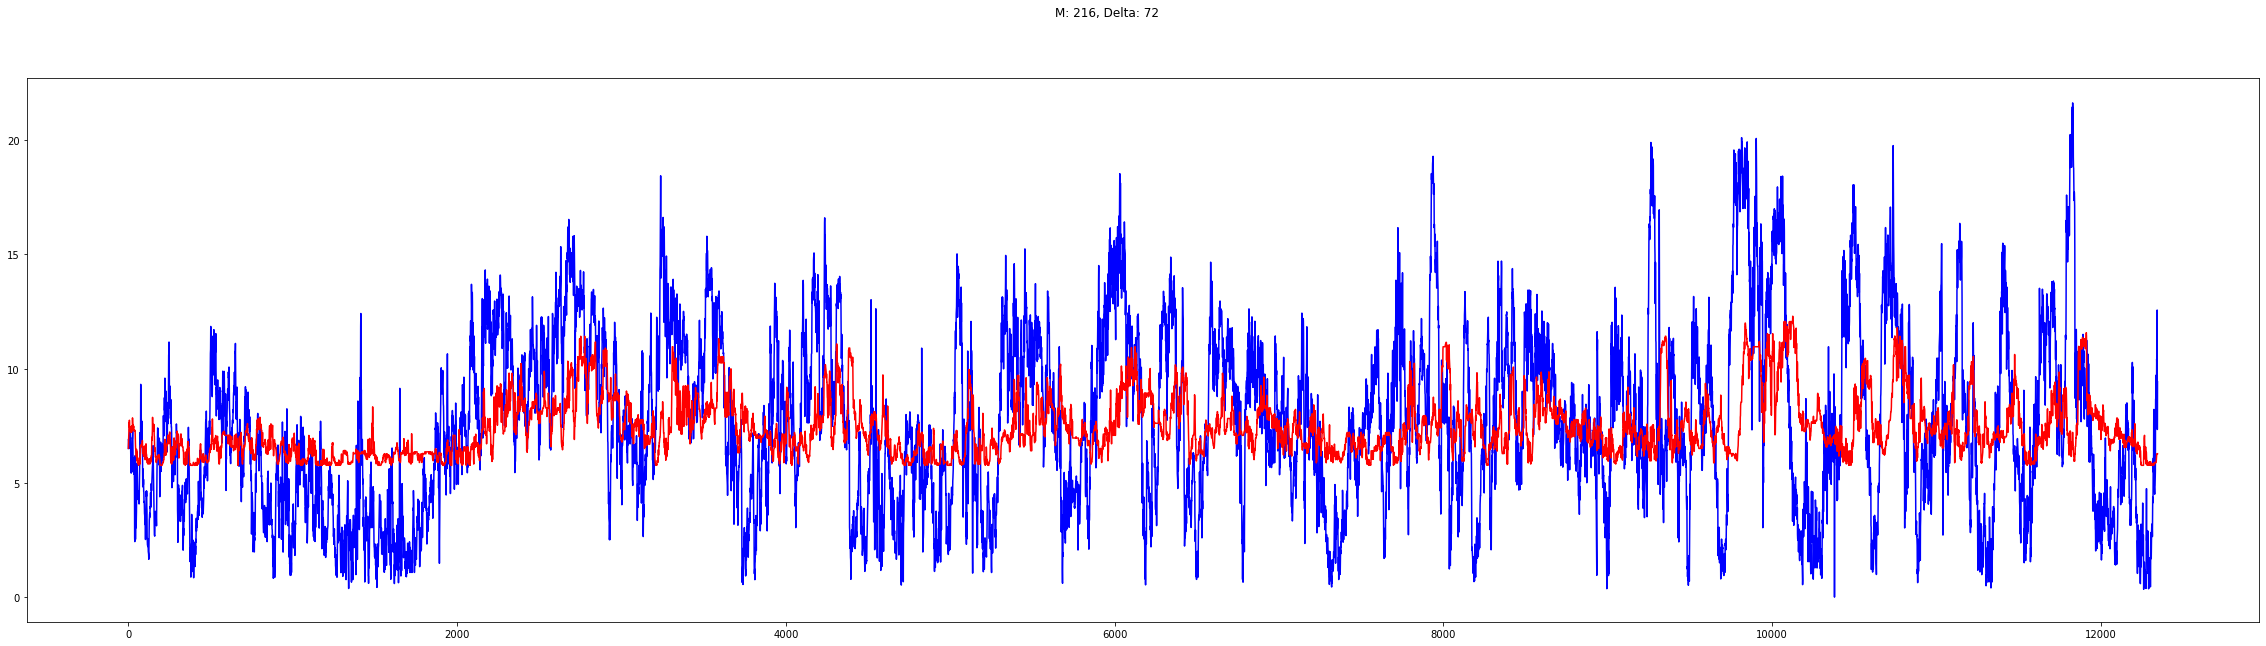

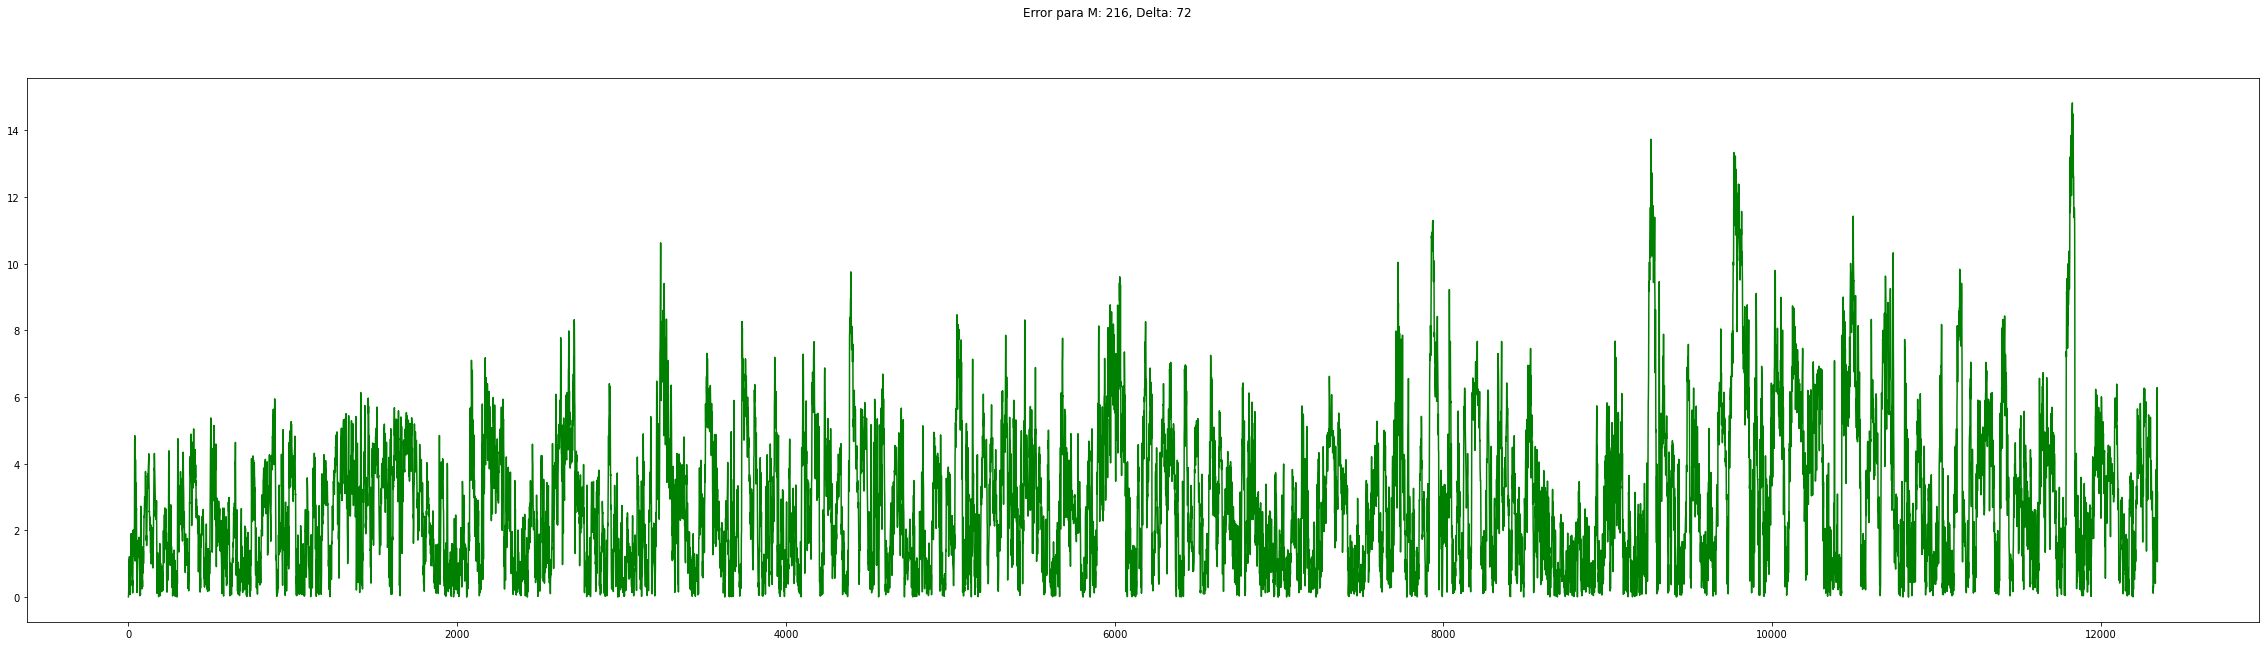

[0]	train-mae:6.96562	eval-mae:7.15931
[1]	train-mae:6.96562	eval-mae:7.15931
[2]	train-mae:6.96562	eval-mae:7.15931
[3]	train-mae:6.96562	eval-mae:7.15931
[4]	train-mae:6.96562	eval-mae:7.15931
[5]	train-mae:6.96562	eval-mae:7.15931
Max. Depth:  0 , ETA:  0.0 ,Best  mae :  7.159307
[0]	train-mae:6.29201	eval-mae:6.47363
[1]	train-mae:5.72914	eval-mae:5.88485
[2]	train-mae:5.27328	eval-mae:5.39074
[3]	train-mae:4.91288	eval-mae:4.98412
[4]	train-mae:4.63354	eval-mae:4.65073
[5]	train-mae:4.41504	eval-mae:4.37719
[6]	train-mae:4.24154	eval-mae:4.15087
[7]	train-mae:4.10598	eval-mae:3.96420
[8]	train-mae:3.99957	eval-mae:3.81110
[9]	train-mae:3.91492	eval-mae:3.68564
[10]	train-mae:3.84793	eval-mae:3.58131
[11]	train-mae:3.79559	eval-mae:3.49436
[12]	train-mae:3.75454	eval-mae:3.42293
[13]	train-mae:3.72350	eval-mae:3.36465
[14]	train-mae:3.69989	eval-mae:3.31758
[15]	train-mae:3.68247	eval-mae:3.27953
[16]	train-mae:3.66939	eval-mae:3.24933
[17]	train-mae:3.66009	eval-mae:3.22542
[18]	t

[50]	train-mae:1.25855	eval-mae:1.07212
[51]	train-mae:1.25421	eval-mae:1.06883
[52]	train-mae:1.25183	eval-mae:1.06818
[53]	train-mae:1.24823	eval-mae:1.06452
[54]	train-mae:1.24614	eval-mae:1.06417
[55]	train-mae:1.24247	eval-mae:1.06174
[56]	train-mae:1.23924	eval-mae:1.05942
[57]	train-mae:1.23764	eval-mae:1.05903
[58]	train-mae:1.23615	eval-mae:1.05884
[59]	train-mae:1.23352	eval-mae:1.05681
[60]	train-mae:1.23140	eval-mae:1.05496
[61]	train-mae:1.23065	eval-mae:1.05495
[62]	train-mae:1.22805	eval-mae:1.05325
[63]	train-mae:1.22704	eval-mae:1.05310
[64]	train-mae:1.22474	eval-mae:1.05175
[65]	train-mae:1.22353	eval-mae:1.05153
[66]	train-mae:1.22179	eval-mae:1.04992
[67]	train-mae:1.22114	eval-mae:1.04992
[68]	train-mae:1.22010	eval-mae:1.04918
[69]	train-mae:1.21839	eval-mae:1.04812
[70]	train-mae:1.21757	eval-mae:1.04801
[71]	train-mae:1.21592	eval-mae:1.04715
[72]	train-mae:1.21516	eval-mae:1.04706
[73]	train-mae:1.21461	eval-mae:1.04706
[74]	train-mae:1.21338	eval-mae:1.04616


[16]	train-mae:1.28155	eval-mae:1.11505
[17]	train-mae:1.27487	eval-mae:1.11260
[18]	train-mae:1.26735	eval-mae:1.10647
[19]	train-mae:1.26511	eval-mae:1.10647
[20]	train-mae:1.25889	eval-mae:1.10276
[21]	train-mae:1.25633	eval-mae:1.10250
[22]	train-mae:1.25398	eval-mae:1.10216
[23]	train-mae:1.24995	eval-mae:1.10012
[24]	train-mae:1.24802	eval-mae:1.09914
[25]	train-mae:1.24815	eval-mae:1.09913
[26]	train-mae:1.24718	eval-mae:1.09918
[27]	train-mae:1.24677	eval-mae:1.09905
[28]	train-mae:1.24450	eval-mae:1.09778
[29]	train-mae:1.24416	eval-mae:1.09777
[30]	train-mae:1.24332	eval-mae:1.09779
[31]	train-mae:1.24277	eval-mae:1.09780
[32]	train-mae:1.24287	eval-mae:1.09779
[33]	train-mae:1.24153	eval-mae:1.09677
[34]	train-mae:1.24121	eval-mae:1.09667
[35]	train-mae:1.23958	eval-mae:1.09630
[36]	train-mae:1.23891	eval-mae:1.09631
[37]	train-mae:1.23882	eval-mae:1.09630
[38]	train-mae:1.23870	eval-mae:1.09630
[39]	train-mae:1.23832	eval-mae:1.09630
[40]	train-mae:1.23796	eval-mae:1.09632


[57]	train-mae:1.25096	eval-mae:1.09385
[58]	train-mae:1.25151	eval-mae:1.09257
[59]	train-mae:1.24905	eval-mae:1.09136
[60]	train-mae:1.24951	eval-mae:1.09087
[61]	train-mae:1.24720	eval-mae:1.08958
[62]	train-mae:1.24673	eval-mae:1.08943
[63]	train-mae:1.24685	eval-mae:1.08943
[64]	train-mae:1.24762	eval-mae:1.08985
[65]	train-mae:1.24520	eval-mae:1.08828
[66]	train-mae:1.24566	eval-mae:1.08785
[67]	train-mae:1.24325	eval-mae:1.08617
[68]	train-mae:1.24375	eval-mae:1.08492
[69]	train-mae:1.24144	eval-mae:1.08396
[70]	train-mae:1.24101	eval-mae:1.08398
[71]	train-mae:1.24163	eval-mae:1.08299
[72]	train-mae:1.23982	eval-mae:1.08232
[73]	train-mae:1.24034	eval-mae:1.08211
[74]	train-mae:1.23800	eval-mae:1.08066
[75]	train-mae:1.23881	eval-mae:1.08115
[76]	train-mae:1.23707	eval-mae:1.08034
[77]	train-mae:1.23690	eval-mae:1.08034
[78]	train-mae:1.23628	eval-mae:1.08036
[79]	train-mae:1.23604	eval-mae:1.08088
[80]	train-mae:1.23588	eval-mae:1.08088
[81]	train-mae:1.23433	eval-mae:1.08001


[65]	train-mae:1.23171	eval-mae:1.09042
[66]	train-mae:1.23239	eval-mae:1.09083
[67]	train-mae:1.22952	eval-mae:1.08806
[68]	train-mae:1.23027	eval-mae:1.08852
[69]	train-mae:1.22802	eval-mae:1.08634
[70]	train-mae:1.22952	eval-mae:1.08727
[71]	train-mae:1.22717	eval-mae:1.08523
[72]	train-mae:1.22709	eval-mae:1.08665
[73]	train-mae:1.22681	eval-mae:1.08692
[74]	train-mae:1.22646	eval-mae:1.08691
[75]	train-mae:1.22551	eval-mae:1.08555
[76]	train-mae:1.22496	eval-mae:1.08667
Max. Depth:  1 , ETA:  0.7000000000000001 ,Best  mae :  1.085231
[0]	train-mae:2.48747	eval-mae:2.28521
[1]	train-mae:2.01769	eval-mae:1.86137
[2]	train-mae:1.69369	eval-mae:1.55847
[3]	train-mae:1.63300	eval-mae:1.54192
[4]	train-mae:1.60455	eval-mae:1.47419
[5]	train-mae:1.52236	eval-mae:1.39141
[6]	train-mae:1.50563	eval-mae:1.35421
[7]	train-mae:1.45563	eval-mae:1.31504
[8]	train-mae:1.42583	eval-mae:1.29498
[9]	train-mae:1.41646	eval-mae:1.27219
[10]	train-mae:1.38712	eval-mae:1.24617
[11]	train-mae:1.38416	ev

[55]	train-mae:1.19040	eval-mae:1.03568
[56]	train-mae:1.18957	eval-mae:1.03537
[57]	train-mae:1.18934	eval-mae:1.03533
[58]	train-mae:1.18858	eval-mae:1.03512
[59]	train-mae:1.18797	eval-mae:1.03504
[60]	train-mae:1.18762	eval-mae:1.03502
[61]	train-mae:1.18712	eval-mae:1.03493
[62]	train-mae:1.18692	eval-mae:1.03491
[63]	train-mae:1.18642	eval-mae:1.03478
[64]	train-mae:1.18561	eval-mae:1.03420
[65]	train-mae:1.18533	eval-mae:1.03413
[66]	train-mae:1.18513	eval-mae:1.03412
[67]	train-mae:1.18473	eval-mae:1.03405
[68]	train-mae:1.18456	eval-mae:1.03404
[69]	train-mae:1.18431	eval-mae:1.03403
[70]	train-mae:1.18396	eval-mae:1.03398
[71]	train-mae:1.18364	eval-mae:1.03398
[72]	train-mae:1.18308	eval-mae:1.03381
[73]	train-mae:1.18278	eval-mae:1.03374
[74]	train-mae:1.18263	eval-mae:1.03373
[75]	train-mae:1.18219	eval-mae:1.03381
[76]	train-mae:1.18186	eval-mae:1.03393
[77]	train-mae:1.18163	eval-mae:1.03396
[78]	train-mae:1.18132	eval-mae:1.03389
Max. Depth:  2 , ETA:  0.1 ,Best  mae : 

[20]	train-mae:1.20098	eval-mae:1.08925
[21]	train-mae:1.19850	eval-mae:1.08845
Max. Depth:  2 , ETA:  0.8 ,Best  mae :  1.085747
[0]	train-mae:1.66219	eval-mae:1.52957
[1]	train-mae:1.45645	eval-mae:1.32599
[2]	train-mae:1.41286	eval-mae:1.28947
[3]	train-mae:1.33520	eval-mae:1.18687
[4]	train-mae:1.31108	eval-mae:1.17195
[5]	train-mae:1.28189	eval-mae:1.14761
[6]	train-mae:1.26632	eval-mae:1.13821
[7]	train-mae:1.25178	eval-mae:1.12131
[8]	train-mae:1.25187	eval-mae:1.12185
[9]	train-mae:1.24348	eval-mae:1.10917
[10]	train-mae:1.24039	eval-mae:1.11071
[11]	train-mae:1.23628	eval-mae:1.11070
[12]	train-mae:1.23367	eval-mae:1.10933
[13]	train-mae:1.22591	eval-mae:1.10417
[14]	train-mae:1.22128	eval-mae:1.10102
[15]	train-mae:1.21279	eval-mae:1.09550
[16]	train-mae:1.20335	eval-mae:1.08255
[17]	train-mae:1.20080	eval-mae:1.08401
[18]	train-mae:1.19799	eval-mae:1.08642
[19]	train-mae:1.19668	eval-mae:1.08904
[20]	train-mae:1.19496	eval-mae:1.08985
[21]	train-mae:1.19265	eval-mae:1.08989


[6]	train-mae:1.20280	eval-mae:1.06790
[7]	train-mae:1.19861	eval-mae:1.06590
[8]	train-mae:1.19410	eval-mae:1.06790
[9]	train-mae:1.18943	eval-mae:1.06890
[10]	train-mae:1.18585	eval-mae:1.06909
[11]	train-mae:1.18059	eval-mae:1.07143
[12]	train-mae:1.17666	eval-mae:1.07393
Max. Depth:  3 , ETA:  0.6000000000000001 ,Best  mae :  1.065897
[0]	train-mae:2.34952	eval-mae:2.33696
[1]	train-mae:1.38667	eval-mae:1.25454
[2]	train-mae:1.24781	eval-mae:1.10246
[3]	train-mae:1.22623	eval-mae:1.08648
[4]	train-mae:1.21812	eval-mae:1.07976
[5]	train-mae:1.20778	eval-mae:1.07324
[6]	train-mae:1.20211	eval-mae:1.07633
[7]	train-mae:1.19809	eval-mae:1.07911
[8]	train-mae:1.19158	eval-mae:1.07859
[9]	train-mae:1.18697	eval-mae:1.08144
[10]	train-mae:1.18328	eval-mae:1.08058
Max. Depth:  3 , ETA:  0.7000000000000001 ,Best  mae :  1.073237
[0]	train-mae:1.83380	eval-mae:1.75929
[1]	train-mae:1.28557	eval-mae:1.14460
[2]	train-mae:1.24266	eval-mae:1.10590
[3]	train-mae:1.23138	eval-mae:1.10291
[4]	trai

[13]	train-mae:1.12586	eval-mae:1.04570
[14]	train-mae:1.12092	eval-mae:1.04605
Max. Depth:  4 , ETA:  0.4 ,Best  mae :  1.045358
[0]	train-mae:3.56324	eval-mae:3.64362
[1]	train-mae:2.04029	eval-mae:2.00965
[2]	train-mae:1.45261	eval-mae:1.35015
[3]	train-mae:1.25556	eval-mae:1.13582
[4]	train-mae:1.19206	eval-mae:1.07190
[5]	train-mae:1.17024	eval-mae:1.05190
[6]	train-mae:1.16060	eval-mae:1.04869
[7]	train-mae:1.15034	eval-mae:1.04909
[8]	train-mae:1.14668	eval-mae:1.04833
[9]	train-mae:1.14392	eval-mae:1.04839
[10]	train-mae:1.14122	eval-mae:1.04930
[11]	train-mae:1.13535	eval-mae:1.04964
[12]	train-mae:1.13036	eval-mae:1.05054
Max. Depth:  4 , ETA:  0.5 ,Best  mae :  1.048327
[0]	train-mae:2.92620	eval-mae:2.96919
[1]	train-mae:1.60036	eval-mae:1.51405
[2]	train-mae:1.26657	eval-mae:1.14108
[3]	train-mae:1.19455	eval-mae:1.06612
[4]	train-mae:1.17296	eval-mae:1.04980
[5]	train-mae:1.15789	eval-mae:1.04767
[6]	train-mae:1.15225	eval-mae:1.04869
[7]	train-mae:1.14600	eval-mae:1.0493

[4]	train-mae:1.15664	eval-mae:1.08166
[5]	train-mae:1.12520	eval-mae:1.06643
[6]	train-mae:1.10900	eval-mae:1.06331
[7]	train-mae:1.09722	eval-mae:1.06503
[8]	train-mae:1.09257	eval-mae:1.06481
[9]	train-mae:1.08103	eval-mae:1.06608
[10]	train-mae:1.07401	eval-mae:1.06688
Max. Depth:  5 , ETA:  0.5 ,Best  mae :  1.063311
[0]	train-mae:2.92157	eval-mae:2.96917
[1]	train-mae:1.58055	eval-mae:1.51937
[2]	train-mae:1.23218	eval-mae:1.14695
[3]	train-mae:1.14864	eval-mae:1.07551
[4]	train-mae:1.12463	eval-mae:1.06216
[5]	train-mae:1.10716	eval-mae:1.06259
[6]	train-mae:1.09253	eval-mae:1.06901
[7]	train-mae:1.08068	eval-mae:1.06999
[8]	train-mae:1.07394	eval-mae:1.07093
Max. Depth:  5 , ETA:  0.6000000000000001 ,Best  mae :  1.062156
[0]	train-mae:2.31698	eval-mae:2.32054
[1]	train-mae:1.32154	eval-mae:1.22033
[2]	train-mae:1.17057	eval-mae:1.07546
[3]	train-mae:1.14202	eval-mae:1.06510
[4]	train-mae:1.12574	eval-mae:1.06783
[5]	train-mae:1.11342	eval-mae:1.06947
[6]	train-mae:1.10210	eval

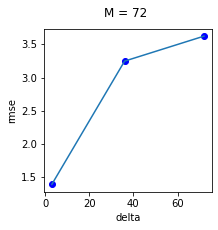

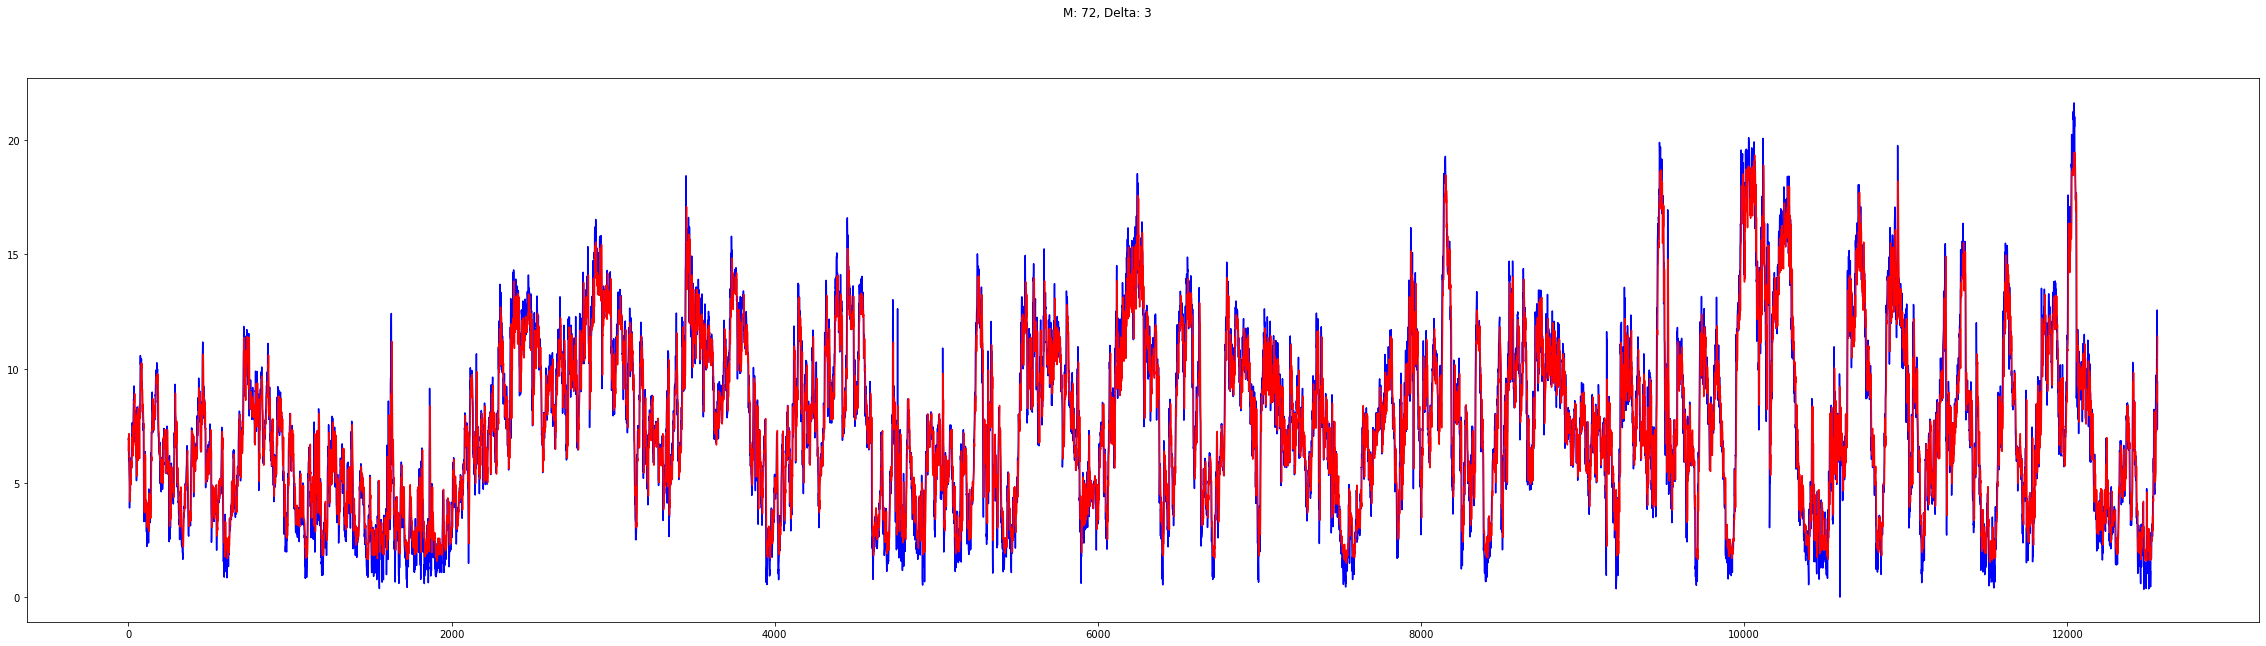

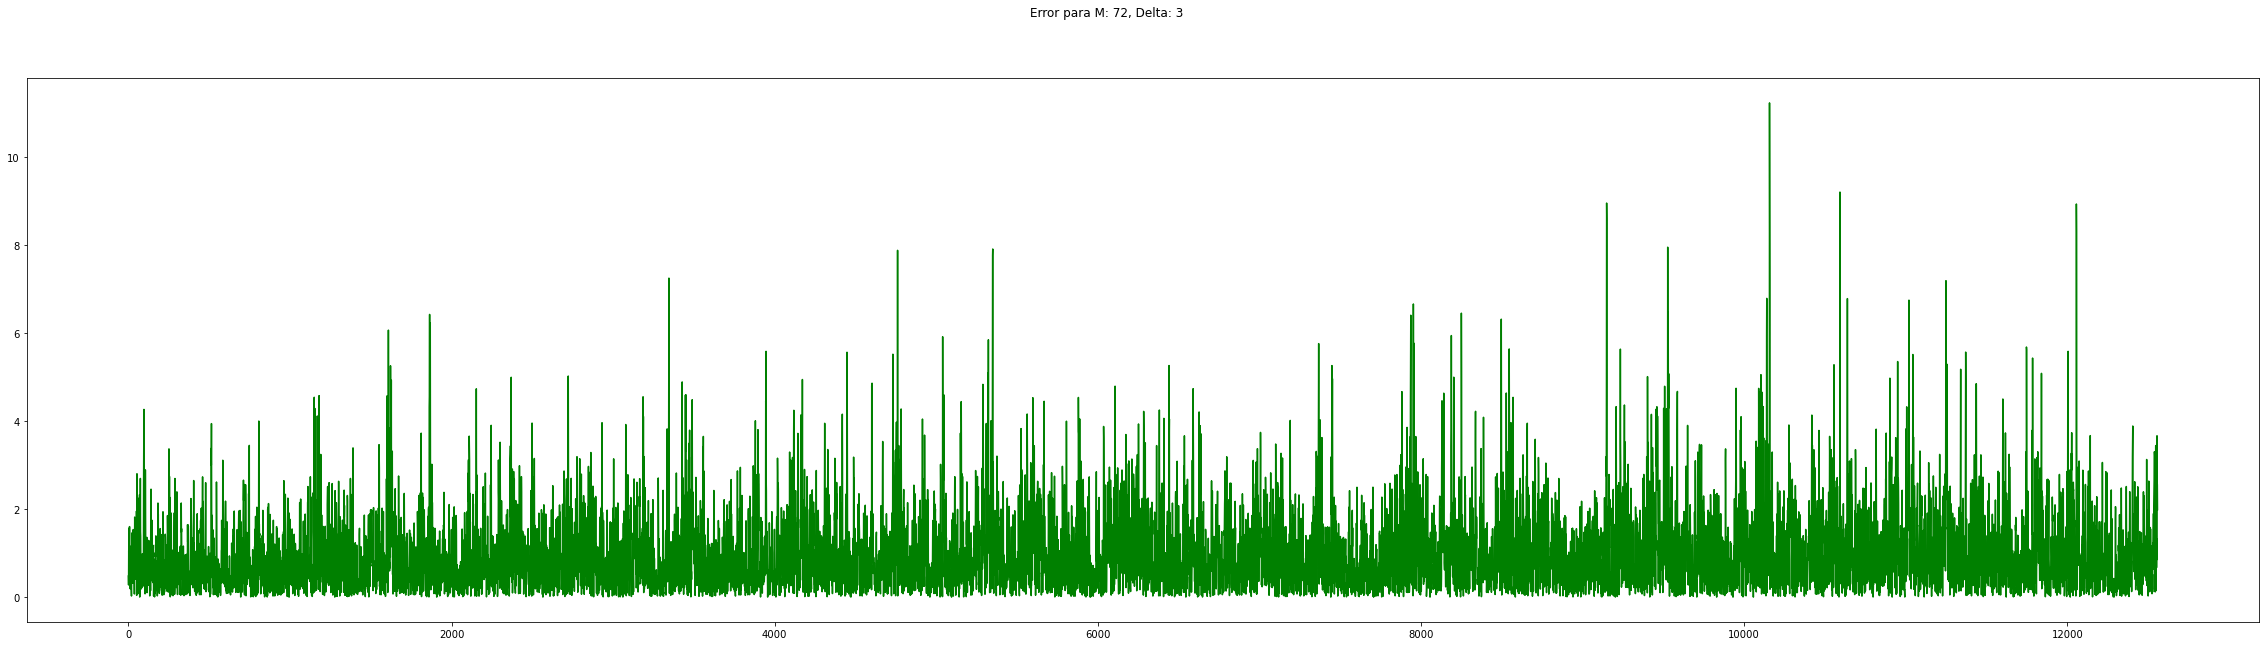

[0]	train-mae:6.95159	eval-mae:7.16321
[1]	train-mae:6.95159	eval-mae:7.16321
[2]	train-mae:6.95159	eval-mae:7.16321
[3]	train-mae:6.95159	eval-mae:7.16321
[4]	train-mae:6.95159	eval-mae:7.16321
[5]	train-mae:6.95159	eval-mae:7.16321
Max. Depth:  0 , ETA:  0.0 ,Best  mae :  7.16321
[0]	train-mae:6.27935	eval-mae:6.47891
[1]	train-mae:5.71761	eval-mae:5.89131
[2]	train-mae:5.26265	eval-mae:5.39815
[3]	train-mae:4.90293	eval-mae:4.99229
[4]	train-mae:4.62413	eval-mae:4.65953
[5]	train-mae:4.40615	eval-mae:4.38655
[6]	train-mae:4.23310	eval-mae:4.16068
[7]	train-mae:4.09788	eval-mae:3.97432
[8]	train-mae:3.99183	eval-mae:3.82138
[9]	train-mae:3.90749	eval-mae:3.69597
[10]	train-mae:3.84073	eval-mae:3.59162
[11]	train-mae:3.78859	eval-mae:3.50455
[12]	train-mae:3.74773	eval-mae:3.43288
[13]	train-mae:3.71681	eval-mae:3.37433
[14]	train-mae:3.69331	eval-mae:3.32695
[15]	train-mae:3.67598	eval-mae:3.28851
[16]	train-mae:3.66301	eval-mae:3.25793
[17]	train-mae:3.65375	eval-mae:3.23365
[18]	tr

[47]	train-mae:3.03623	eval-mae:2.58181
[48]	train-mae:3.03505	eval-mae:2.58220
[49]	train-mae:3.03301	eval-mae:2.57920
[50]	train-mae:3.03279	eval-mae:2.57915
[51]	train-mae:3.03215	eval-mae:2.58018
[52]	train-mae:3.03145	eval-mae:2.58012
[53]	train-mae:3.03106	eval-mae:2.58134
[54]	train-mae:3.02915	eval-mae:2.57812
[55]	train-mae:3.02884	eval-mae:2.57809
[56]	train-mae:3.02778	eval-mae:2.57824
[57]	train-mae:3.02734	eval-mae:2.57950
[58]	train-mae:3.02557	eval-mae:2.57682
[59]	train-mae:3.02493	eval-mae:2.57786
[60]	train-mae:3.02434	eval-mae:2.57818
[61]	train-mae:3.02399	eval-mae:2.57815
[62]	train-mae:3.02212	eval-mae:2.57575
[63]	train-mae:3.02177	eval-mae:2.57695
[64]	train-mae:3.02028	eval-mae:2.57423
[65]	train-mae:3.01965	eval-mae:2.57518
[66]	train-mae:3.01930	eval-mae:2.57516
[67]	train-mae:3.01834	eval-mae:2.57525
[68]	train-mae:3.01798	eval-mae:2.57643
[69]	train-mae:3.01647	eval-mae:2.57396
[70]	train-mae:3.01612	eval-mae:2.57395
[71]	train-mae:3.01562	eval-mae:2.57428


[6]	train-mae:3.07245	eval-mae:2.64471
[7]	train-mae:3.07280	eval-mae:2.63655
[8]	train-mae:3.04198	eval-mae:2.59910
[9]	train-mae:3.03818	eval-mae:2.61574
[10]	train-mae:3.03376	eval-mae:2.61583
[11]	train-mae:3.02848	eval-mae:2.62179
[12]	train-mae:3.02977	eval-mae:2.61962
[13]	train-mae:3.02033	eval-mae:2.62374
Max. Depth:  1 , ETA:  0.9 ,Best  mae :  2.599097
[0]	train-mae:6.95159	eval-mae:7.16321
[1]	train-mae:6.95159	eval-mae:7.16321
[2]	train-mae:6.95159	eval-mae:7.16321
[3]	train-mae:6.95159	eval-mae:7.16321
[4]	train-mae:6.95159	eval-mae:7.16321
Max. Depth:  2 , ETA:  0.0 ,Best  mae :  7.16321
[0]	train-mae:6.27168	eval-mae:6.46941
[1]	train-mae:5.68807	eval-mae:5.86102
[2]	train-mae:5.19618	eval-mae:5.33809
[3]	train-mae:4.78961	eval-mae:4.88746
[4]	train-mae:4.45892	eval-mae:4.50327
[5]	train-mae:4.18887	eval-mae:4.18066
[6]	train-mae:3.96918	eval-mae:3.90557
[7]	train-mae:3.78853	eval-mae:3.66960
[8]	train-mae:3.63976	eval-mae:3.47724
[9]	train-mae:3.51825	eval-mae:3.31559


[2]	train-mae:6.95159	eval-mae:7.16321
[3]	train-mae:6.95159	eval-mae:7.16321
[4]	train-mae:6.95159	eval-mae:7.16321
[5]	train-mae:6.95159	eval-mae:7.16321
Max. Depth:  3 , ETA:  0.0 ,Best  mae :  7.16321
[0]	train-mae:6.27113	eval-mae:6.46884
[1]	train-mae:5.68617	eval-mae:5.86274
[2]	train-mae:5.19113	eval-mae:5.34032
[3]	train-mae:4.78230	eval-mae:4.89318
[4]	train-mae:4.44915	eval-mae:4.51275
[5]	train-mae:4.17570	eval-mae:4.18784
[6]	train-mae:3.95032	eval-mae:3.91008
[7]	train-mae:3.76423	eval-mae:3.68289
[8]	train-mae:3.61195	eval-mae:3.49046
[9]	train-mae:3.48612	eval-mae:3.33179
[10]	train-mae:3.38006	eval-mae:3.19476
[11]	train-mae:3.29549	eval-mae:3.08619
[12]	train-mae:3.22322	eval-mae:2.99129
[13]	train-mae:3.16456	eval-mae:2.91450
[14]	train-mae:3.11878	eval-mae:2.85636
[15]	train-mae:3.07947	eval-mae:2.80391
[16]	train-mae:3.04655	eval-mae:2.76120
[17]	train-mae:3.01928	eval-mae:2.72507
[18]	train-mae:2.99749	eval-mae:2.70021
[19]	train-mae:2.97789	eval-mae:2.67648
[20]	

[13]	train-mae:3.09435	eval-mae:2.93664
[14]	train-mae:3.04225	eval-mae:2.87570
[15]	train-mae:3.00057	eval-mae:2.82546
[16]	train-mae:2.96522	eval-mae:2.78079
[17]	train-mae:2.93390	eval-mae:2.74678
[18]	train-mae:2.90966	eval-mae:2.72148
[19]	train-mae:2.88820	eval-mae:2.69695
[20]	train-mae:2.86885	eval-mae:2.67589
[21]	train-mae:2.85315	eval-mae:2.66361
[22]	train-mae:2.83901	eval-mae:2.65049
[23]	train-mae:2.82818	eval-mae:2.64213
[24]	train-mae:2.81885	eval-mae:2.63505
[25]	train-mae:2.80884	eval-mae:2.62673
[26]	train-mae:2.80150	eval-mae:2.62378
[27]	train-mae:2.79323	eval-mae:2.61639
[28]	train-mae:2.78897	eval-mae:2.61177
[29]	train-mae:2.78468	eval-mae:2.60986
[30]	train-mae:2.77882	eval-mae:2.60904
[31]	train-mae:2.77225	eval-mae:2.60734
[32]	train-mae:2.76664	eval-mae:2.60537
[33]	train-mae:2.76380	eval-mae:2.60358
[34]	train-mae:2.75987	eval-mae:2.60174
[35]	train-mae:2.75728	eval-mae:2.60034
[36]	train-mae:2.75333	eval-mae:2.59882
[37]	train-mae:2.75213	eval-mae:2.59900


[16]	train-mae:2.61436	eval-mae:2.62165
[17]	train-mae:2.60270	eval-mae:2.62391
[18]	train-mae:2.59729	eval-mae:2.62400
[19]	train-mae:2.58457	eval-mae:2.62160
[20]	train-mae:2.57276	eval-mae:2.62427
[21]	train-mae:2.56804	eval-mae:2.62265
[22]	train-mae:2.56580	eval-mae:2.62151
[23]	train-mae:2.55500	eval-mae:2.62273
[24]	train-mae:2.54873	eval-mae:2.62522
[25]	train-mae:2.54709	eval-mae:2.62495
[26]	train-mae:2.54111	eval-mae:2.62544
Max. Depth:  5 , ETA:  0.2 ,Best  mae :  2.621506
[0]	train-mae:5.01765	eval-mae:5.16608
[1]	train-mae:3.94873	eval-mae:3.98720
[2]	train-mae:3.37780	eval-mae:3.32704
[3]	train-mae:3.06243	eval-mae:2.98375
[4]	train-mae:2.89314	eval-mae:2.80699
[5]	train-mae:2.79943	eval-mae:2.71842
[6]	train-mae:2.73331	eval-mae:2.68335
[7]	train-mae:2.69376	eval-mae:2.65695
[8]	train-mae:2.66101	eval-mae:2.64422
[9]	train-mae:2.64281	eval-mae:2.64052
[10]	train-mae:2.61540	eval-mae:2.63994
[11]	train-mae:2.59631	eval-mae:2.64474
[12]	train-mae:2.58122	eval-mae:2.64378


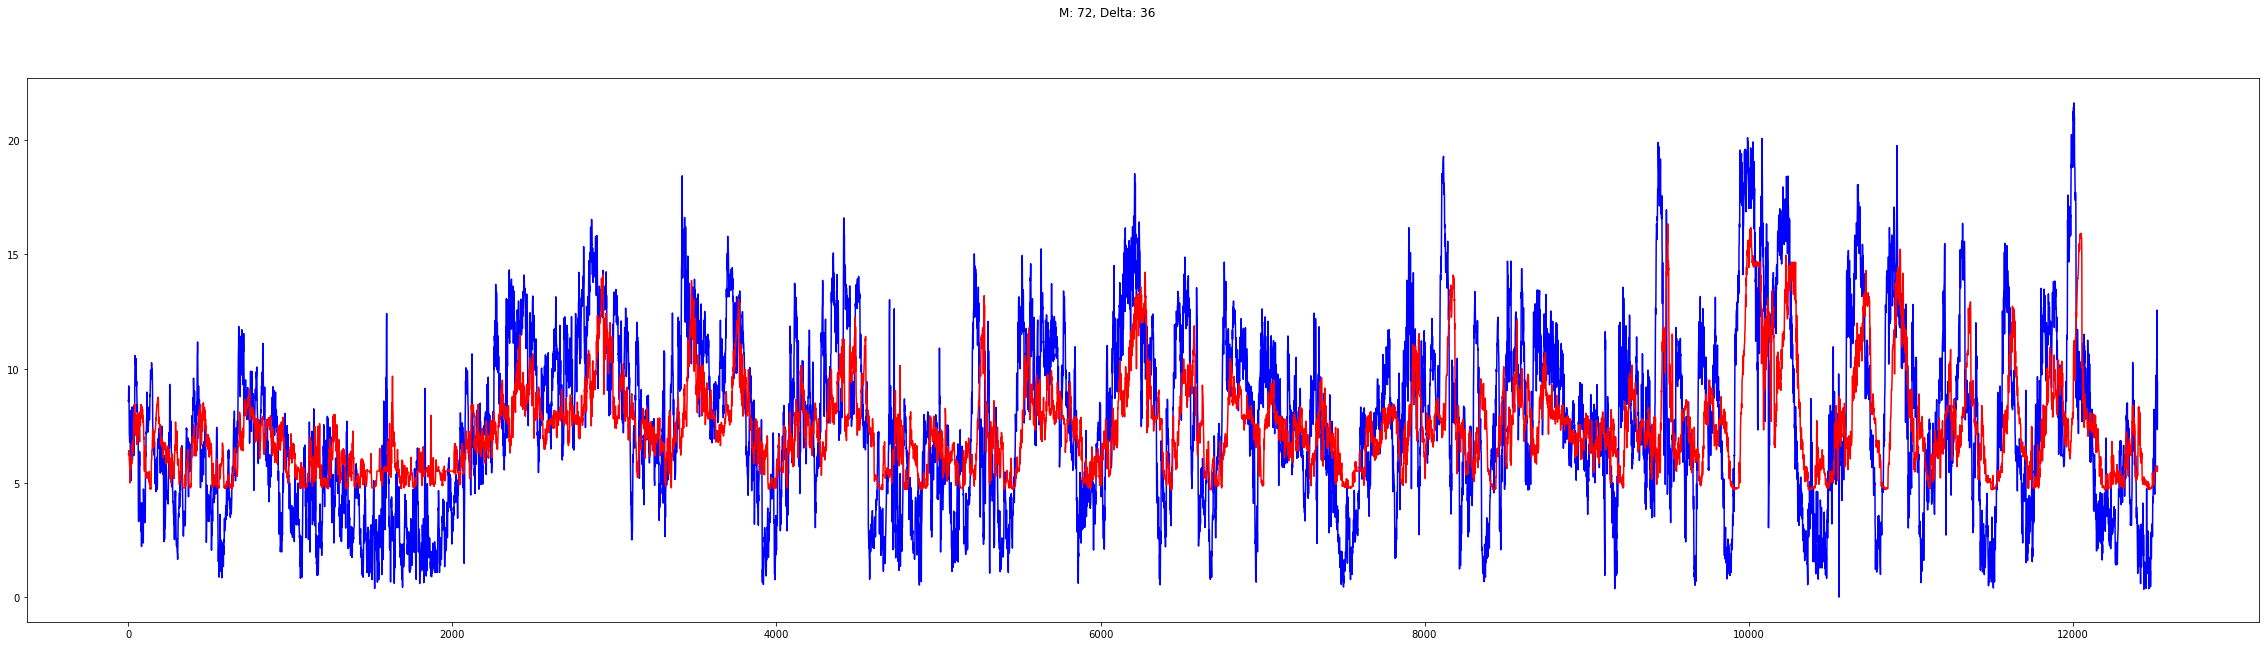

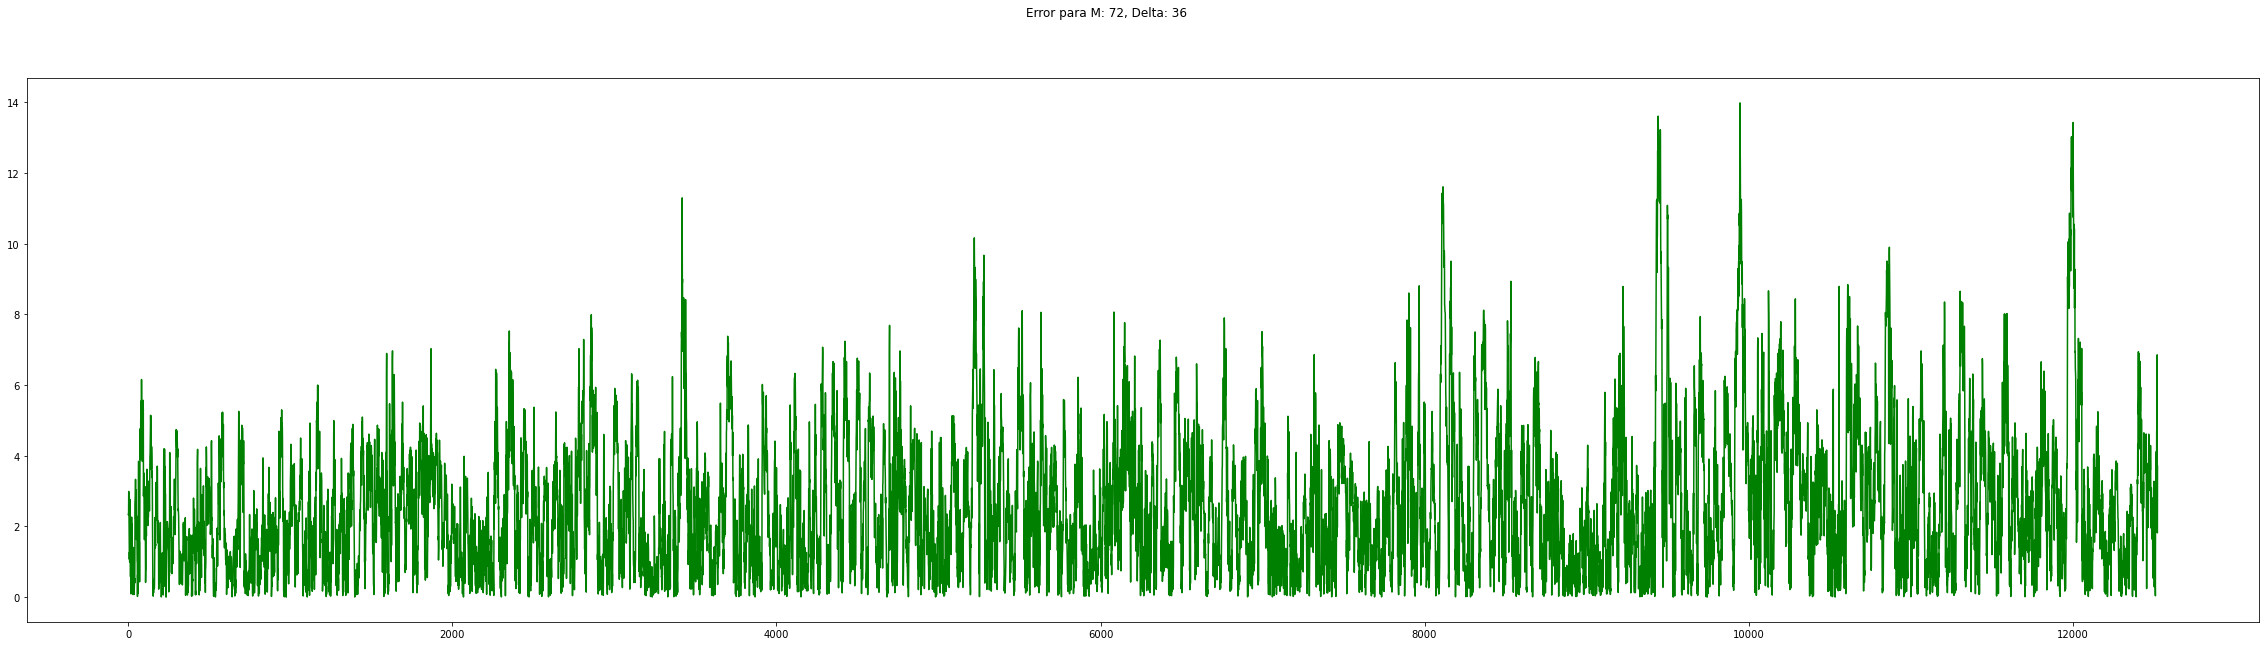

[0]	train-mae:6.94079	eval-mae:7.16450
[1]	train-mae:6.94079	eval-mae:7.16450
[2]	train-mae:6.94079	eval-mae:7.16450
[3]	train-mae:6.94079	eval-mae:7.16450
[4]	train-mae:6.94079	eval-mae:7.16450
Max. Depth:  0 , ETA:  0.0 ,Best  mae :  7.164501
[0]	train-mae:6.26962	eval-mae:6.48128
[1]	train-mae:5.70882	eval-mae:5.89461
[2]	train-mae:5.25463	eval-mae:5.40224
[3]	train-mae:4.89556	eval-mae:4.99705
[4]	train-mae:4.61732	eval-mae:4.66489
[5]	train-mae:4.39991	eval-mae:4.39245
[6]	train-mae:4.22738	eval-mae:4.16706
[7]	train-mae:4.09259	eval-mae:3.98113
[8]	train-mae:3.98697	eval-mae:3.82853
[9]	train-mae:3.90303	eval-mae:3.70345
[10]	train-mae:3.83660	eval-mae:3.59940
[11]	train-mae:3.78475	eval-mae:3.51257
[12]	train-mae:3.74418	eval-mae:3.44104
[13]	train-mae:3.71347	eval-mae:3.38259
[14]	train-mae:3.69017	eval-mae:3.33528
[15]	train-mae:3.67301	eval-mae:3.29684
[16]	train-mae:3.66023	eval-mae:3.26619
[17]	train-mae:3.65110	eval-mae:3.24181
[18]	train-mae:3.64499	eval-mae:3.22239
[19]	

[4]	train-mae:3.73391	eval-mae:3.50344
[5]	train-mae:3.61639	eval-mae:3.31849
[6]	train-mae:3.54027	eval-mae:3.16346
[7]	train-mae:3.50145	eval-mae:3.08133
[8]	train-mae:3.47394	eval-mae:3.00484
[9]	train-mae:3.46265	eval-mae:2.96501
[10]	train-mae:3.45783	eval-mae:2.94372
[11]	train-mae:3.45578	eval-mae:2.93223
[12]	train-mae:3.45152	eval-mae:2.90878
[13]	train-mae:3.45260	eval-mae:2.90605
[14]	train-mae:3.45355	eval-mae:2.89892
[15]	train-mae:3.45558	eval-mae:2.90094
[16]	train-mae:3.45318	eval-mae:2.88843
[17]	train-mae:3.45241	eval-mae:2.88750
[18]	train-mae:3.45400	eval-mae:2.89098
[19]	train-mae:3.45301	eval-mae:2.89081
[20]	train-mae:3.45025	eval-mae:2.88219
[21]	train-mae:3.45063	eval-mae:2.88433
[22]	train-mae:3.45028	eval-mae:2.88489
[23]	train-mae:3.44906	eval-mae:2.88496
[24]	train-mae:3.44792	eval-mae:2.88504
Max. Depth:  1 , ETA:  0.2 ,Best  mae :  2.882195
[0]	train-mae:5.07869	eval-mae:5.23088
[1]	train-mae:4.19122	eval-mae:4.17810
[2]	train-mae:3.77131	eval-mae:3.56527

[24]	train-mae:3.37312	eval-mae:2.88781
[25]	train-mae:3.36846	eval-mae:2.88353
[26]	train-mae:3.36488	eval-mae:2.88404
[27]	train-mae:3.36306	eval-mae:2.88563
[28]	train-mae:3.36155	eval-mae:2.88771
[29]	train-mae:3.35965	eval-mae:2.88790
[30]	train-mae:3.35513	eval-mae:2.88541
Max. Depth:  2 , ETA:  0.2 ,Best  mae :  2.883533
[0]	train-mae:5.06833	eval-mae:5.21212
[1]	train-mae:4.15707	eval-mae:4.11927
[2]	train-mae:3.74617	eval-mae:3.56207
[3]	train-mae:3.54819	eval-mae:3.24326
[4]	train-mae:3.46871	eval-mae:3.10006
[5]	train-mae:3.42392	eval-mae:2.99685
[6]	train-mae:3.41233	eval-mae:2.95996
[7]	train-mae:3.40578	eval-mae:2.92731
[8]	train-mae:3.39595	eval-mae:2.90821
[9]	train-mae:3.39642	eval-mae:2.90994
[10]	train-mae:3.39718	eval-mae:2.90948
[11]	train-mae:3.38909	eval-mae:2.90450
[12]	train-mae:3.38628	eval-mae:2.90554
[13]	train-mae:3.38385	eval-mae:2.90463
[14]	train-mae:3.37539	eval-mae:2.89595
[15]	train-mae:3.37397	eval-mae:2.89870
[16]	train-mae:3.37046	eval-mae:2.89913


[9]	train-mae:3.33024	eval-mae:2.91903
[10]	train-mae:3.31865	eval-mae:2.91241
[11]	train-mae:3.30470	eval-mae:2.90867
[12]	train-mae:3.30081	eval-mae:2.90886
[13]	train-mae:3.29681	eval-mae:2.90821
[14]	train-mae:3.28971	eval-mae:2.91114
[15]	train-mae:3.28568	eval-mae:2.91084
[16]	train-mae:3.28186	eval-mae:2.91055
[17]	train-mae:3.27090	eval-mae:2.91484
Max. Depth:  3 , ETA:  0.30000000000000004 ,Best  mae :  2.908211
[0]	train-mae:4.58304	eval-mae:4.69338
[1]	train-mae:3.75469	eval-mae:3.63758
[2]	train-mae:3.47187	eval-mae:3.19185
[3]	train-mae:3.38869	eval-mae:3.03380
[4]	train-mae:3.35946	eval-mae:2.96196
[5]	train-mae:3.34307	eval-mae:2.94040
[6]	train-mae:3.33966	eval-mae:2.93119
[7]	train-mae:3.32333	eval-mae:2.92348
[8]	train-mae:3.31861	eval-mae:2.92298
[9]	train-mae:3.30951	eval-mae:2.92204
[10]	train-mae:3.29630	eval-mae:2.91813
[11]	train-mae:3.28087	eval-mae:2.91822
[12]	train-mae:3.27198	eval-mae:2.91823
[13]	train-mae:3.26338	eval-mae:2.91804
[14]	train-mae:3.25925	ev

[14]	train-mae:3.11129	eval-mae:2.95164
Max. Depth:  4 , ETA:  0.4 ,Best  mae :  2.941496
[0]	train-mae:4.16643	eval-mae:4.21964
[1]	train-mae:3.48957	eval-mae:3.32080
[2]	train-mae:3.32506	eval-mae:3.05063
[3]	train-mae:3.26479	eval-mae:2.99182
[4]	train-mae:3.24263	eval-mae:2.95815
[5]	train-mae:3.23097	eval-mae:2.95663
[6]	train-mae:3.21926	eval-mae:2.95432
[7]	train-mae:3.19191	eval-mae:2.95069
[8]	train-mae:3.16304	eval-mae:2.94552
[9]	train-mae:3.15370	eval-mae:2.94603
[10]	train-mae:3.14028	eval-mae:2.95156
[11]	train-mae:3.11907	eval-mae:2.95834
[12]	train-mae:3.10383	eval-mae:2.95207
Max. Depth:  4 , ETA:  0.5 ,Best  mae :  2.945519
[0]	train-mae:3.84024	eval-mae:3.80274
[1]	train-mae:3.37630	eval-mae:3.11367
[2]	train-mae:3.29253	eval-mae:2.97977
[3]	train-mae:3.25257	eval-mae:2.98221
[4]	train-mae:3.24215	eval-mae:2.97333
[5]	train-mae:3.22799	eval-mae:2.97291
[6]	train-mae:3.18989	eval-mae:2.97999
[7]	train-mae:3.16655	eval-mae:2.97992
[8]	train-mae:3.14371	eval-mae:2.97627

[8]	train-mae:2.90847	eval-mae:3.01518
Max. Depth:  5 , ETA:  0.7000000000000001 ,Best  mae :  2.975588
[0]	train-mae:3.39321	eval-mae:3.19782
[1]	train-mae:3.23995	eval-mae:2.98103
[2]	train-mae:3.15872	eval-mae:3.02759
[3]	train-mae:3.11968	eval-mae:3.02457
[4]	train-mae:3.08567	eval-mae:3.03457
[5]	train-mae:3.03066	eval-mae:3.04930
Max. Depth:  5 , ETA:  0.8 ,Best  mae :  2.981034
[0]	train-mae:3.30974	eval-mae:3.02430
[1]	train-mae:3.21351	eval-mae:3.02045
[2]	train-mae:3.12965	eval-mae:3.06253
[3]	train-mae:3.08141	eval-mae:3.07052
[4]	train-mae:3.01720	eval-mae:3.09795
[5]	train-mae:2.94326	eval-mae:3.11170
[6]	train-mae:2.90982	eval-mae:3.13560
Max. Depth:  5 , ETA:  0.9 ,Best  mae :  3.020447
Best Max. Depth:  1 , Best ETA:  0.9 ,Best  mae :  2.862103
M:  72 , Delta:  72 ,Best  mae :  2.862103


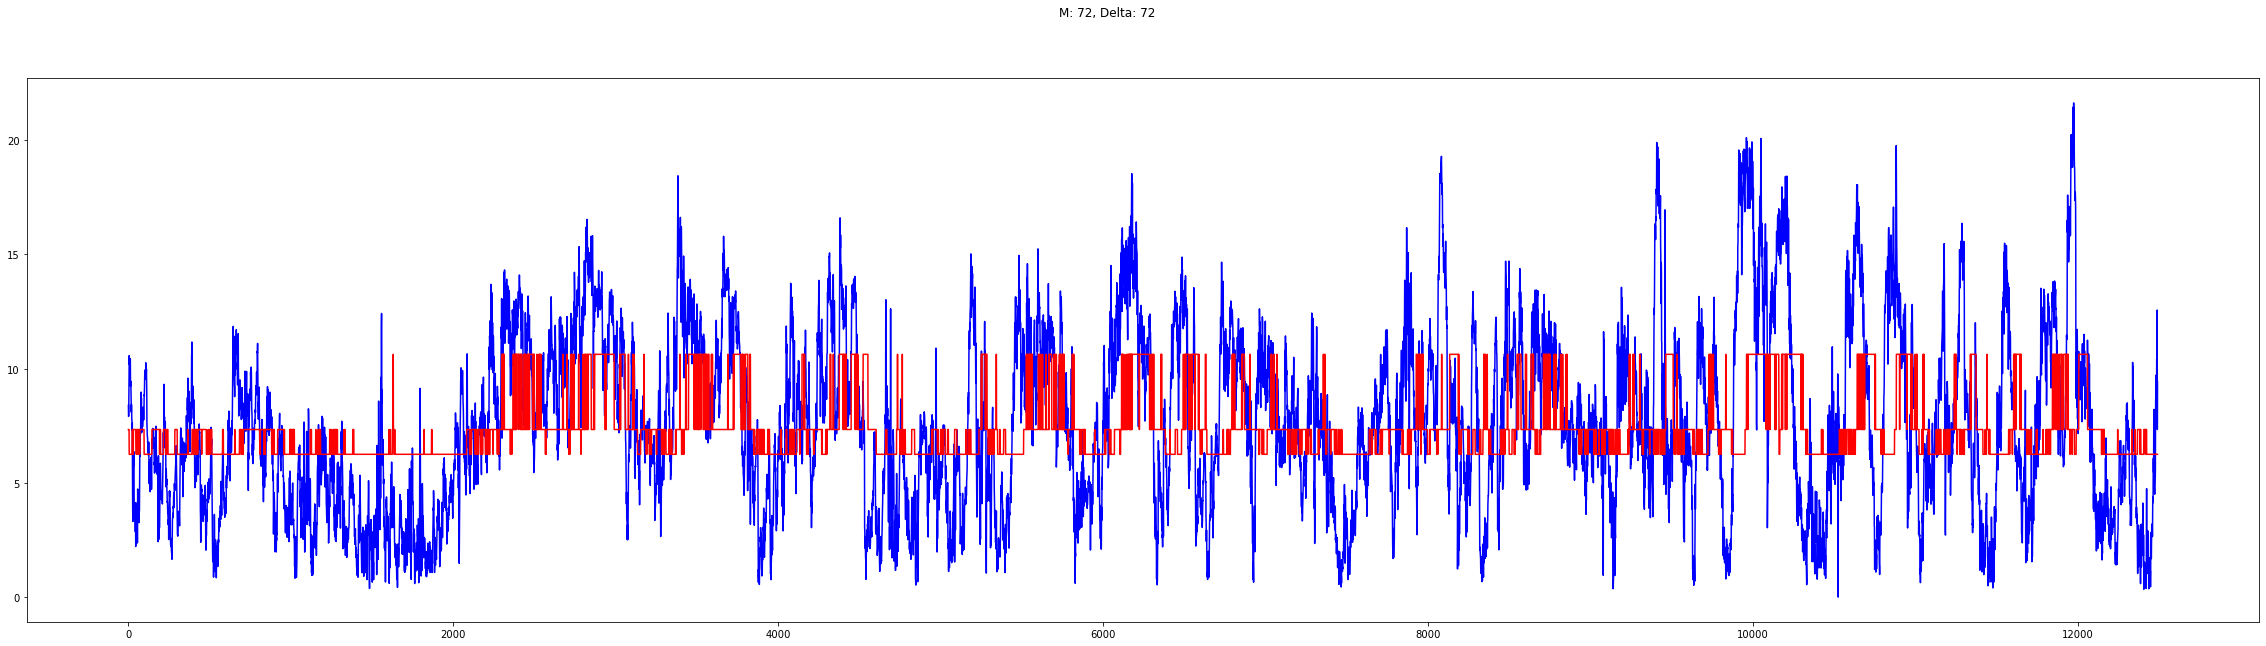

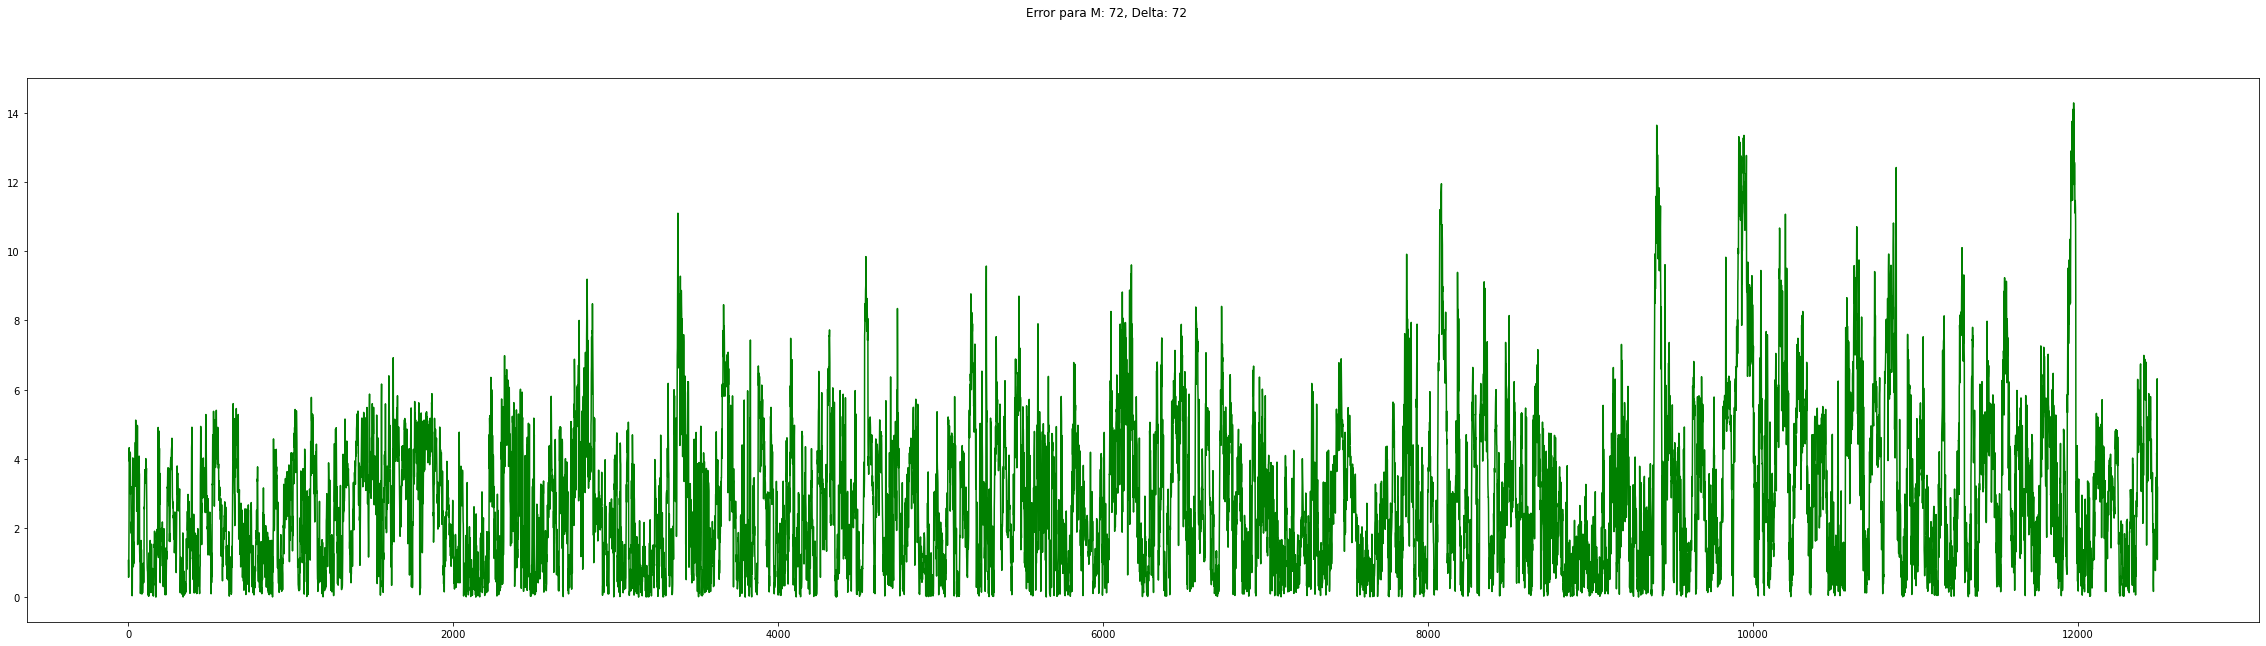

[0]	train-mae:6.94553	eval-mae:7.17557
[1]	train-mae:6.94553	eval-mae:7.17557
[2]	train-mae:6.94553	eval-mae:7.17557
[3]	train-mae:6.94553	eval-mae:7.17557
[4]	train-mae:6.94553	eval-mae:7.17557
Max. Depth:  0 , ETA:  0.0 ,Best  mae :  7.175573
[0]	train-mae:6.27407	eval-mae:6.49196
[1]	train-mae:5.71332	eval-mae:5.90516
[2]	train-mae:5.25955	eval-mae:5.41292
[3]	train-mae:4.90112	eval-mae:5.00785
[4]	train-mae:4.62373	eval-mae:4.67582
[5]	train-mae:4.40728	eval-mae:4.40301
[6]	train-mae:4.23563	eval-mae:4.17688
[7]	train-mae:4.10163	eval-mae:3.99006
[8]	train-mae:3.99654	eval-mae:3.83668
[9]	train-mae:3.91297	eval-mae:3.71093
[10]	train-mae:3.84684	eval-mae:3.60628
[11]	train-mae:3.79528	eval-mae:3.51893
[12]	train-mae:3.75495	eval-mae:3.44699
[13]	train-mae:3.72447	eval-mae:3.38817
[14]	train-mae:3.70136	eval-mae:3.34057
[15]	train-mae:3.68440	eval-mae:3.30191
[16]	train-mae:3.67176	eval-mae:3.27102
[17]	train-mae:3.66274	eval-mae:3.24641
[18]	train-mae:3.65672	eval-mae:3.22677
[19]	

[47]	train-mae:1.26829	eval-mae:1.08412
[48]	train-mae:1.26319	eval-mae:1.07990
[49]	train-mae:1.26017	eval-mae:1.07898
[50]	train-mae:1.25552	eval-mae:1.07581
[51]	train-mae:1.25246	eval-mae:1.07319
[52]	train-mae:1.25015	eval-mae:1.07253
[53]	train-mae:1.24608	eval-mae:1.06964
[54]	train-mae:1.24398	eval-mae:1.06930
[55]	train-mae:1.24079	eval-mae:1.06613
[56]	train-mae:1.23737	eval-mae:1.06353
[57]	train-mae:1.23577	eval-mae:1.06319
[58]	train-mae:1.23281	eval-mae:1.06114
[59]	train-mae:1.23136	eval-mae:1.06095
[60]	train-mae:1.22926	eval-mae:1.05910
[61]	train-mae:1.22851	eval-mae:1.05909
[62]	train-mae:1.22589	eval-mae:1.05752
[63]	train-mae:1.22460	eval-mae:1.05664
[64]	train-mae:1.22369	eval-mae:1.05652
[65]	train-mae:1.22142	eval-mae:1.05504
[66]	train-mae:1.22076	eval-mae:1.05504
[67]	train-mae:1.21902	eval-mae:1.05380
[68]	train-mae:1.21793	eval-mae:1.05361
[69]	train-mae:1.21616	eval-mae:1.05269
[70]	train-mae:1.21538	eval-mae:1.05263
[71]	train-mae:1.21481	eval-mae:1.05264


[68]	train-mae:1.22041	eval-mae:1.09264
Max. Depth:  1 , ETA:  0.30000000000000004 ,Best  mae :  1.091849
[0]	train-mae:4.32663	eval-mae:4.41717
[1]	train-mae:3.07070	eval-mae:3.04816
[2]	train-mae:2.22616	eval-mae:2.04087
[3]	train-mae:1.91500	eval-mae:1.73202
[4]	train-mae:1.63067	eval-mae:1.40373
[5]	train-mae:1.54412	eval-mae:1.34208
[6]	train-mae:1.44975	eval-mae:1.24981
[7]	train-mae:1.41599	eval-mae:1.23543
[8]	train-mae:1.37340	eval-mae:1.18987
[9]	train-mae:1.34475	eval-mae:1.16642
[10]	train-mae:1.33038	eval-mae:1.16064
[11]	train-mae:1.32126	eval-mae:1.15910
[12]	train-mae:1.30755	eval-mae:1.14787
[13]	train-mae:1.30239	eval-mae:1.14582
[14]	train-mae:1.29946	eval-mae:1.14584
[15]	train-mae:1.29252	eval-mae:1.14127
[16]	train-mae:1.28781	eval-mae:1.13904
[17]	train-mae:1.28740	eval-mae:1.13900
[18]	train-mae:1.28286	eval-mae:1.13670
[19]	train-mae:1.28122	eval-mae:1.13771
[20]	train-mae:1.28062	eval-mae:1.13754
[21]	train-mae:1.27937	eval-mae:1.13766
[22]	train-mae:1.27908	e

[21]	train-mae:1.31190	eval-mae:1.17664
[22]	train-mae:1.31110	eval-mae:1.17065
[23]	train-mae:1.30405	eval-mae:1.16683
[24]	train-mae:1.30345	eval-mae:1.16679
[25]	train-mae:1.30057	eval-mae:1.16808
[26]	train-mae:1.29590	eval-mae:1.16341
[27]	train-mae:1.29520	eval-mae:1.16191
[28]	train-mae:1.28768	eval-mae:1.15397
[29]	train-mae:1.28752	eval-mae:1.15346
[30]	train-mae:1.28110	eval-mae:1.14726
[31]	train-mae:1.28090	eval-mae:1.14294
[32]	train-mae:1.27608	eval-mae:1.14171
[33]	train-mae:1.27521	eval-mae:1.14146
[34]	train-mae:1.27537	eval-mae:1.14141
[35]	train-mae:1.27559	eval-mae:1.14147
[36]	train-mae:1.26952	eval-mae:1.13524
[37]	train-mae:1.26958	eval-mae:1.13228
[38]	train-mae:1.26673	eval-mae:1.13205
[39]	train-mae:1.26709	eval-mae:1.13241
[40]	train-mae:1.26176	eval-mae:1.12707
[41]	train-mae:1.26197	eval-mae:1.12420
[42]	train-mae:1.25883	eval-mae:1.12122
[43]	train-mae:1.25889	eval-mae:1.12092
[44]	train-mae:1.25492	eval-mae:1.11725
[45]	train-mae:1.25614	eval-mae:1.11770


[25]	train-mae:1.27279	eval-mae:1.13518
[26]	train-mae:1.27147	eval-mae:1.13479
[27]	train-mae:1.27198	eval-mae:1.13361
[28]	train-mae:1.26395	eval-mae:1.12767
[29]	train-mae:1.26453	eval-mae:1.12248
[30]	train-mae:1.26171	eval-mae:1.12306
[31]	train-mae:1.26113	eval-mae:1.12283
[32]	train-mae:1.25657	eval-mae:1.12134
[33]	train-mae:1.25876	eval-mae:1.12189
[34]	train-mae:1.25309	eval-mae:1.11777
[35]	train-mae:1.25168	eval-mae:1.11793
[36]	train-mae:1.24758	eval-mae:1.11748
[37]	train-mae:1.24825	eval-mae:1.11743
[38]	train-mae:1.24384	eval-mae:1.11310
[39]	train-mae:1.24514	eval-mae:1.11034
[40]	train-mae:1.23891	eval-mae:1.10373
[41]	train-mae:1.24005	eval-mae:1.10097
[42]	train-mae:1.23633	eval-mae:1.10067
[43]	train-mae:1.23848	eval-mae:1.10206
[44]	train-mae:1.23362	eval-mae:1.09887
[45]	train-mae:1.23322	eval-mae:1.09899
[46]	train-mae:1.23281	eval-mae:1.09897
[47]	train-mae:1.23235	eval-mae:1.09889
[48]	train-mae:1.23162	eval-mae:1.09892
Max. Depth:  1 , ETA:  0.9 ,Best  mae : 

[6]	train-mae:1.26174	eval-mae:1.13345
[7]	train-mae:1.24631	eval-mae:1.10878
[8]	train-mae:1.22992	eval-mae:1.09096
[9]	train-mae:1.22611	eval-mae:1.09174
[10]	train-mae:1.21556	eval-mae:1.07880
[11]	train-mae:1.21242	eval-mae:1.07900
[12]	train-mae:1.20930	eval-mae:1.08020
[13]	train-mae:1.20655	eval-mae:1.08197
[14]	train-mae:1.20306	eval-mae:1.07730
[15]	train-mae:1.20031	eval-mae:1.07864
[16]	train-mae:1.19731	eval-mae:1.07839
[17]	train-mae:1.19764	eval-mae:1.07924
[18]	train-mae:1.19467	eval-mae:1.07818
Max. Depth:  2 , ETA:  0.6000000000000001 ,Best  mae :  1.077296
[0]	train-mae:2.42627	eval-mae:2.41545
[1]	train-mae:1.50169	eval-mae:1.37853
[2]	train-mae:1.33949	eval-mae:1.21388
[3]	train-mae:1.31258	eval-mae:1.16847
[4]	train-mae:1.29092	eval-mae:1.15833
[5]	train-mae:1.28787	eval-mae:1.15810
[6]	train-mae:1.28315	eval-mae:1.15553
[7]	train-mae:1.26704	eval-mae:1.13080
[8]	train-mae:1.24633	eval-mae:1.11162
[9]	train-mae:1.24031	eval-mae:1.11202
[10]	train-mae:1.23273	eval-m

[12]	train-mae:1.17827	eval-mae:1.04721
[13]	train-mae:1.17284	eval-mae:1.04545
[14]	train-mae:1.17007	eval-mae:1.04329
[15]	train-mae:1.16589	eval-mae:1.04390
[16]	train-mae:1.16262	eval-mae:1.04329
[17]	train-mae:1.15880	eval-mae:1.04281
[18]	train-mae:1.15705	eval-mae:1.04234
[19]	train-mae:1.15348	eval-mae:1.04297
[20]	train-mae:1.14941	eval-mae:1.04382
[21]	train-mae:1.14777	eval-mae:1.04393
[22]	train-mae:1.14646	eval-mae:1.04382
[23]	train-mae:1.14375	eval-mae:1.04356
Max. Depth:  3 , ETA:  0.30000000000000004 ,Best  mae :  1.042339
[0]	train-mae:4.21640	eval-mae:4.34806
[1]	train-mae:2.67968	eval-mae:2.71294
[2]	train-mae:1.87073	eval-mae:1.81874
[3]	train-mae:1.48483	eval-mae:1.37749
[4]	train-mae:1.31688	eval-mae:1.18418
[5]	train-mae:1.24394	eval-mae:1.10657
[6]	train-mae:1.21075	eval-mae:1.07160
[7]	train-mae:1.19491	eval-mae:1.06129
[8]	train-mae:1.18772	eval-mae:1.05918
[9]	train-mae:1.18130	eval-mae:1.05570
[10]	train-mae:1.17717	eval-mae:1.05593
[11]	train-mae:1.17348	e

[9]	train-mae:1.16543	eval-mae:1.06658
[10]	train-mae:1.15094	eval-mae:1.05897
[11]	train-mae:1.14187	eval-mae:1.05347
[12]	train-mae:1.13207	eval-mae:1.05296
[13]	train-mae:1.12584	eval-mae:1.04989
[14]	train-mae:1.12205	eval-mae:1.04965
[15]	train-mae:1.11587	eval-mae:1.04883
[16]	train-mae:1.11010	eval-mae:1.04870
[17]	train-mae:1.10848	eval-mae:1.04886
[18]	train-mae:1.10501	eval-mae:1.04925
[19]	train-mae:1.10066	eval-mae:1.04946
[20]	train-mae:1.09691	eval-mae:1.05031
Max. Depth:  4 , ETA:  0.30000000000000004 ,Best  mae :  1.048698
[0]	train-mae:4.21054	eval-mae:4.34277
[1]	train-mae:2.66488	eval-mae:2.70338
[2]	train-mae:1.85176	eval-mae:1.80554
[3]	train-mae:1.46300	eval-mae:1.37485
[4]	train-mae:1.28748	eval-mae:1.18553
[5]	train-mae:1.20855	eval-mae:1.09940
[6]	train-mae:1.17275	eval-mae:1.06790
[7]	train-mae:1.15502	eval-mae:1.05373
[8]	train-mae:1.14435	eval-mae:1.04976
[9]	train-mae:1.13398	eval-mae:1.04998
[10]	train-mae:1.12714	eval-mae:1.05087
[11]	train-mae:1.12006	ev

[15]	train-mae:1.04744	eval-mae:1.05760
[16]	train-mae:1.03810	eval-mae:1.05834
[17]	train-mae:1.02915	eval-mae:1.05850
[18]	train-mae:1.02334	eval-mae:1.05832
Max. Depth:  5 , ETA:  0.30000000000000004 ,Best  mae :  1.05716
[0]	train-mae:4.20994	eval-mae:4.34504
[1]	train-mae:2.65808	eval-mae:2.70550
[2]	train-mae:1.83548	eval-mae:1.81251
[3]	train-mae:1.43572	eval-mae:1.37182
[4]	train-mae:1.24857	eval-mae:1.18259
[5]	train-mae:1.16412	eval-mae:1.10597
[6]	train-mae:1.12294	eval-mae:1.07279
[7]	train-mae:1.09948	eval-mae:1.06218
[8]	train-mae:1.08491	eval-mae:1.05530
[9]	train-mae:1.06778	eval-mae:1.05668
[10]	train-mae:1.05691	eval-mae:1.05858
[11]	train-mae:1.04456	eval-mae:1.06021
[12]	train-mae:1.03916	eval-mae:1.06057
Max. Depth:  5 , ETA:  0.4 ,Best  mae :  1.055304
[0]	train-mae:3.55078	eval-mae:3.65308
[1]	train-mae:2.02211	eval-mae:2.01031
[2]	train-mae:1.42852	eval-mae:1.35626
[3]	train-mae:1.21799	eval-mae:1.13942
[4]	train-mae:1.14176	eval-mae:1.08054
[5]	train-mae:1.1085

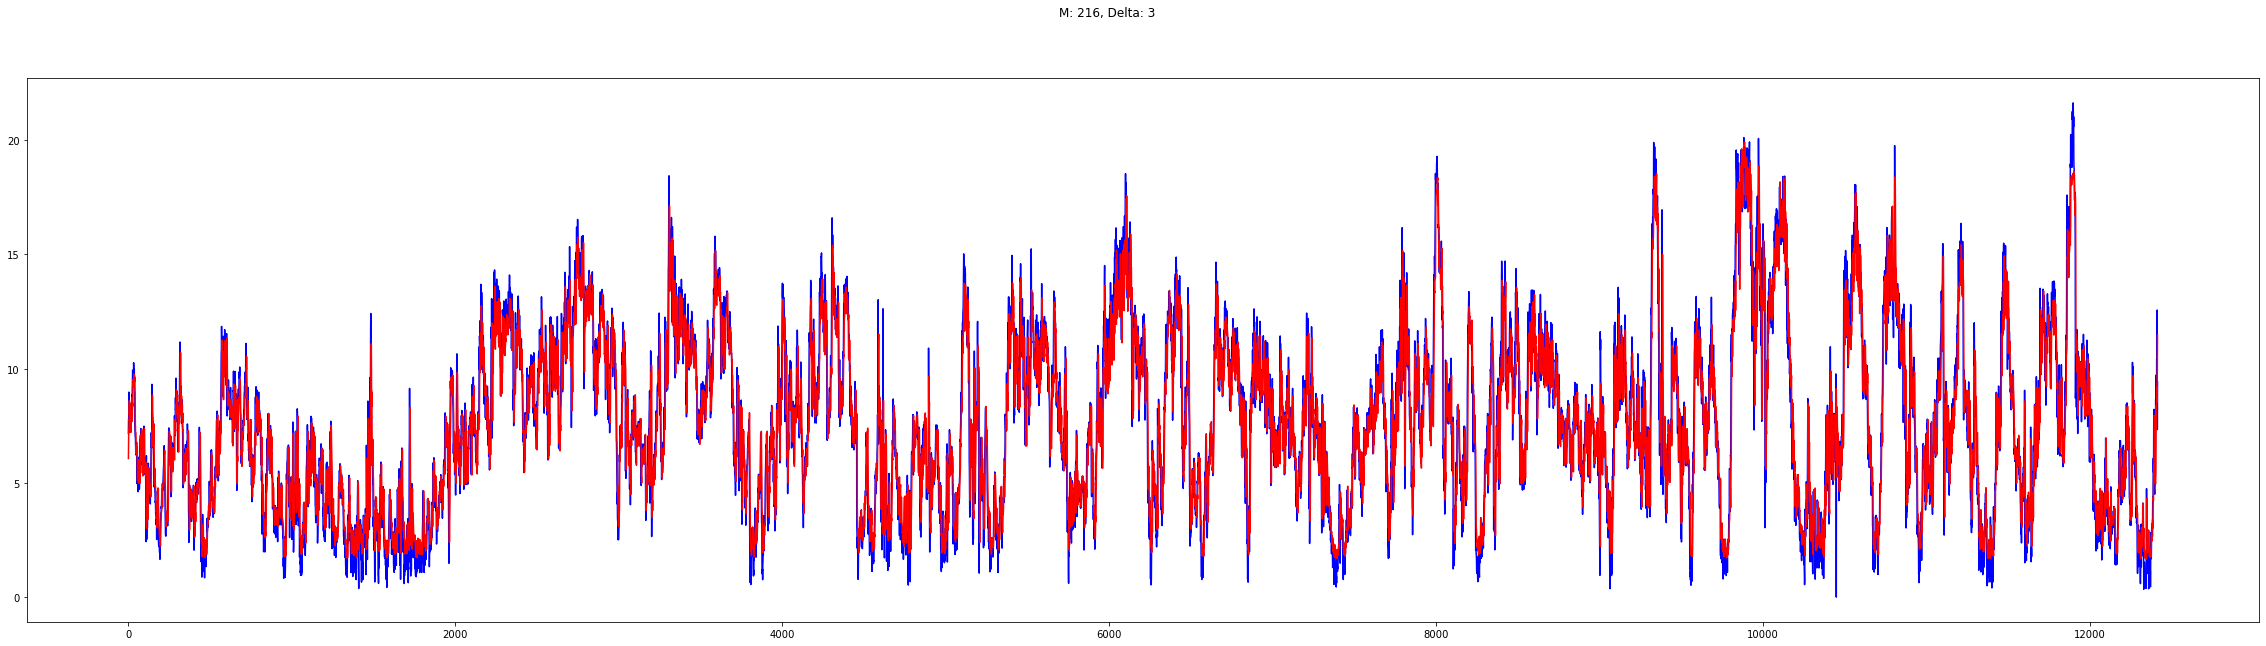

[0]	train-mae:6.94865	eval-mae:7.17347
[1]	train-mae:6.94865	eval-mae:7.17347
[2]	train-mae:6.94865	eval-mae:7.17347
[3]	train-mae:6.94865	eval-mae:7.17347
[4]	train-mae:6.94865	eval-mae:7.17347
[5]	train-mae:6.94865	eval-mae:7.17347
Max. Depth:  0 , ETA:  0.0 ,Best  mae :  7.173474
[0]	train-mae:6.27695	eval-mae:6.48959
[1]	train-mae:5.71615	eval-mae:5.90265
[2]	train-mae:5.26244	eval-mae:5.41043
[3]	train-mae:4.90409	eval-mae:5.00553
[4]	train-mae:4.62682	eval-mae:4.67375
[5]	train-mae:4.41050	eval-mae:4.40127
[6]	train-mae:4.23904	eval-mae:4.17550
[7]	train-mae:4.10527	eval-mae:3.98906
[8]	train-mae:4.00039	eval-mae:3.83610
[9]	train-mae:3.91699	eval-mae:3.71075
[10]	train-mae:3.85100	eval-mae:3.60648
[11]	train-mae:3.79959	eval-mae:3.51951
[12]	train-mae:3.75938	eval-mae:3.44795
[13]	train-mae:3.72900	eval-mae:3.38950
[14]	train-mae:3.70600	eval-mae:3.34225
[15]	train-mae:3.68915	eval-mae:3.30393
[16]	train-mae:3.67659	eval-mae:3.27336
[17]	train-mae:3.66764	eval-mae:3.24904
[18]	t

[46]	train-mae:3.03397	eval-mae:2.57246
[47]	train-mae:3.03263	eval-mae:2.57343
[48]	train-mae:3.03044	eval-mae:2.57336
[49]	train-mae:3.02952	eval-mae:2.57358
[50]	train-mae:3.02819	eval-mae:2.57443
[51]	train-mae:3.02675	eval-mae:2.57535
Max. Depth:  1 , ETA:  0.1 ,Best  mae :  2.572459
[0]	train-mae:5.63671	eval-mae:5.83811
[1]	train-mae:4.72964	eval-mae:4.82559
[2]	train-mae:4.16522	eval-mae:4.14773
[3]	train-mae:3.78438	eval-mae:3.62545
[4]	train-mae:3.54542	eval-mae:3.31392
[5]	train-mae:3.39265	eval-mae:3.10294
[6]	train-mae:3.27432	eval-mae:2.91498
[7]	train-mae:3.21147	eval-mae:2.83285
[8]	train-mae:3.15706	eval-mae:2.74162
[9]	train-mae:3.13106	eval-mae:2.70443
[10]	train-mae:3.10545	eval-mae:2.66033
[11]	train-mae:3.09248	eval-mae:2.64687
[12]	train-mae:3.08355	eval-mae:2.62798
[13]	train-mae:3.07085	eval-mae:2.60539
[14]	train-mae:3.06578	eval-mae:2.60319
[15]	train-mae:3.05994	eval-mae:2.60111
[16]	train-mae:3.05638	eval-mae:2.59527
[17]	train-mae:3.05291	eval-mae:2.59021


[28]	train-mae:2.96612	eval-mae:2.58782
[29]	train-mae:2.96116	eval-mae:2.58676
[30]	train-mae:2.95781	eval-mae:2.58724
[31]	train-mae:2.95103	eval-mae:2.58264
[32]	train-mae:2.94753	eval-mae:2.58297
[33]	train-mae:2.94456	eval-mae:2.58128
[34]	train-mae:2.93913	eval-mae:2.57684
[35]	train-mae:2.93617	eval-mae:2.57591
[36]	train-mae:2.93074	eval-mae:2.57182
[37]	train-mae:2.92848	eval-mae:2.57133
[38]	train-mae:2.92389	eval-mae:2.56784
[39]	train-mae:2.92112	eval-mae:2.56899
[40]	train-mae:2.91875	eval-mae:2.57085
[41]	train-mae:2.91587	eval-mae:2.56927
[42]	train-mae:2.91117	eval-mae:2.56737
[43]	train-mae:2.90867	eval-mae:2.56797
[44]	train-mae:2.90472	eval-mae:2.56405
[45]	train-mae:2.90046	eval-mae:2.55998
[46]	train-mae:2.89909	eval-mae:2.56016
[47]	train-mae:2.89727	eval-mae:2.55935
[48]	train-mae:2.89511	eval-mae:2.55977
[49]	train-mae:2.89174	eval-mae:2.55726
[50]	train-mae:2.88955	eval-mae:2.55755
[51]	train-mae:2.88690	eval-mae:2.55635
[52]	train-mae:2.88389	eval-mae:2.55676


[19]	train-mae:2.92313	eval-mae:2.67353
[20]	train-mae:2.90349	eval-mae:2.65283
[21]	train-mae:2.88670	eval-mae:2.63580
[22]	train-mae:2.87465	eval-mae:2.62798
[23]	train-mae:2.86180	eval-mae:2.61801
[24]	train-mae:2.84854	eval-mae:2.60574
[25]	train-mae:2.83899	eval-mae:2.60267
[26]	train-mae:2.82775	eval-mae:2.59160
[27]	train-mae:2.82078	eval-mae:2.58816
[28]	train-mae:2.81204	eval-mae:2.58725
[29]	train-mae:2.80284	eval-mae:2.58213
[30]	train-mae:2.79510	eval-mae:2.58096
[31]	train-mae:2.78735	eval-mae:2.57615
[32]	train-mae:2.78115	eval-mae:2.57490
[33]	train-mae:2.77574	eval-mae:2.57448
[34]	train-mae:2.76948	eval-mae:2.57145
[35]	train-mae:2.76328	eval-mae:2.57108
[36]	train-mae:2.76062	eval-mae:2.57048
[37]	train-mae:2.75362	eval-mae:2.56756
[38]	train-mae:2.74991	eval-mae:2.56790
[39]	train-mae:2.74350	eval-mae:2.56871
[40]	train-mae:2.73738	eval-mae:2.56678
[41]	train-mae:2.73138	eval-mae:2.56353
[42]	train-mae:2.72798	eval-mae:2.56405
[43]	train-mae:2.72578	eval-mae:2.56412


[28]	train-mae:2.62034	eval-mae:2.62599
[29]	train-mae:2.61135	eval-mae:2.62108
[30]	train-mae:2.60068	eval-mae:2.61684
[31]	train-mae:2.58777	eval-mae:2.61215
[32]	train-mae:2.58033	eval-mae:2.61106
[33]	train-mae:2.56972	eval-mae:2.60829
[34]	train-mae:2.56477	eval-mae:2.60705
[35]	train-mae:2.55441	eval-mae:2.60477
[36]	train-mae:2.54368	eval-mae:2.60105
[37]	train-mae:2.53441	eval-mae:2.59969
[38]	train-mae:2.52791	eval-mae:2.60052
[39]	train-mae:2.51856	eval-mae:2.59656
[40]	train-mae:2.51149	eval-mae:2.59669
[41]	train-mae:2.50571	eval-mae:2.59421
[42]	train-mae:2.49596	eval-mae:2.59559
[43]	train-mae:2.49189	eval-mae:2.59624
[44]	train-mae:2.48223	eval-mae:2.59517
[45]	train-mae:2.47147	eval-mae:2.59387
[46]	train-mae:2.46421	eval-mae:2.59274
[47]	train-mae:2.46099	eval-mae:2.59303
[48]	train-mae:2.45244	eval-mae:2.59054
[49]	train-mae:2.44496	eval-mae:2.58799
[50]	train-mae:2.43859	eval-mae:2.58665
[51]	train-mae:2.43196	eval-mae:2.58673
[52]	train-mae:2.42937	eval-mae:2.58755


[2]	train-mae:4.01651	eval-mae:4.13998
[3]	train-mae:3.56836	eval-mae:3.64101
[4]	train-mae:3.24853	eval-mae:3.29359
[5]	train-mae:3.02409	eval-mae:3.07171
[6]	train-mae:2.86427	eval-mae:2.93383
[7]	train-mae:2.74294	eval-mae:2.84189
[8]	train-mae:2.65498	eval-mae:2.78242
[9]	train-mae:2.58749	eval-mae:2.74266
[10]	train-mae:2.53416	eval-mae:2.71382
[11]	train-mae:2.49229	eval-mae:2.68393
[12]	train-mae:2.45852	eval-mae:2.67528
[13]	train-mae:2.42113	eval-mae:2.67195
[14]	train-mae:2.38775	eval-mae:2.66193
[15]	train-mae:2.35588	eval-mae:2.66368
[16]	train-mae:2.33022	eval-mae:2.66298
[17]	train-mae:2.30099	eval-mae:2.65798
[18]	train-mae:2.26707	eval-mae:2.65434
[19]	train-mae:2.25347	eval-mae:2.65179
[20]	train-mae:2.23196	eval-mae:2.65171
[21]	train-mae:2.20798	eval-mae:2.65434
[22]	train-mae:2.19607	eval-mae:2.65278
[23]	train-mae:2.18387	eval-mae:2.65087
[24]	train-mae:2.16524	eval-mae:2.65388
[25]	train-mae:2.14450	eval-mae:2.65588
[26]	train-mae:2.13405	eval-mae:2.65727
[27]	tra

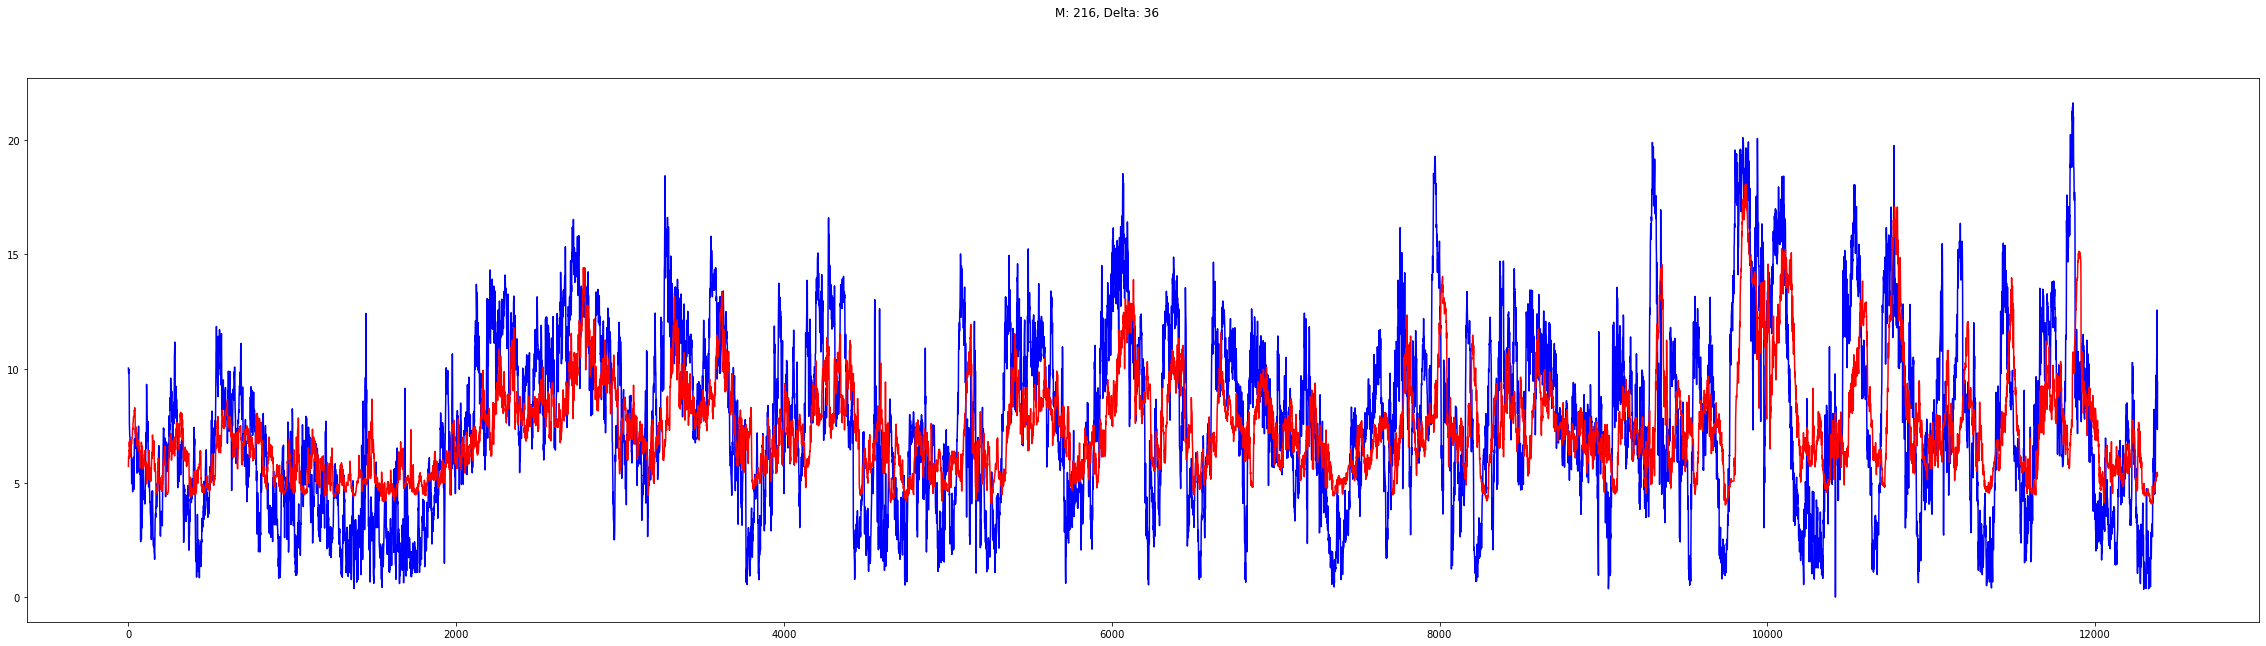

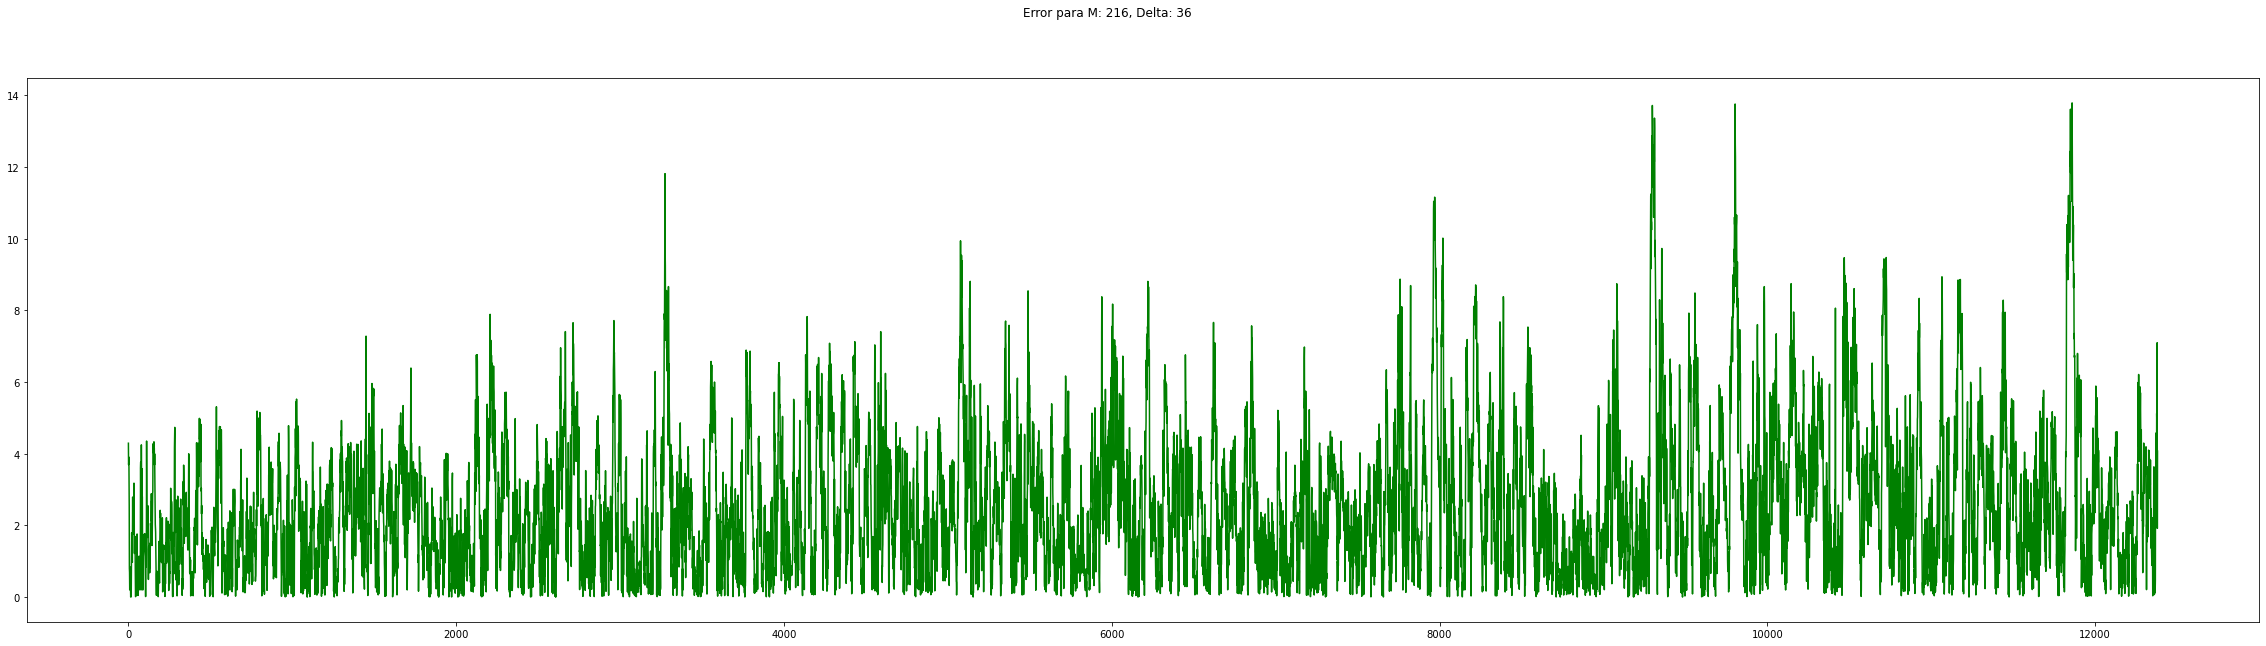

[0]	train-mae:6.95209	eval-mae:7.17652
[1]	train-mae:6.95209	eval-mae:7.17652
[2]	train-mae:6.95209	eval-mae:7.17652
[3]	train-mae:6.95209	eval-mae:7.17652
[4]	train-mae:6.95209	eval-mae:7.17652
Max. Depth:  0 , ETA:  0.0 ,Best  mae :  7.176525
[0]	train-mae:6.28014	eval-mae:6.49234
[1]	train-mae:5.71929	eval-mae:5.90525
[2]	train-mae:5.26576	eval-mae:5.41305
[3]	train-mae:4.90777	eval-mae:5.00832
[4]	train-mae:4.63101	eval-mae:4.67683
[5]	train-mae:4.41519	eval-mae:4.40470
[6]	train-mae:4.24426	eval-mae:4.17932
[7]	train-mae:4.11106	eval-mae:3.99331
[8]	train-mae:4.00674	eval-mae:3.84077
[9]	train-mae:3.92388	eval-mae:3.71576
[10]	train-mae:3.85836	eval-mae:3.61173
[11]	train-mae:3.80731	eval-mae:3.52497
[12]	train-mae:3.76738	eval-mae:3.45348
[13]	train-mae:3.73723	eval-mae:3.39509
[14]	train-mae:3.71439	eval-mae:3.34789
[15]	train-mae:3.69763	eval-mae:3.30956
[16]	train-mae:3.68514	eval-mae:3.27896
[17]	train-mae:3.67624	eval-mae:3.25460
[18]	train-mae:3.67031	eval-mae:3.23519
[19]	

[45]	train-mae:3.42118	eval-mae:2.88957
[46]	train-mae:3.42036	eval-mae:2.88941
[47]	train-mae:3.42023	eval-mae:2.89053
[48]	train-mae:3.41968	eval-mae:2.89079
[49]	train-mae:3.41840	eval-mae:2.89023
[50]	train-mae:3.41857	eval-mae:2.89239
[51]	train-mae:3.41633	eval-mae:2.88737
[52]	train-mae:3.41577	eval-mae:2.88682
[53]	train-mae:3.41553	eval-mae:2.88670
[54]	train-mae:3.41464	eval-mae:2.88647
[55]	train-mae:3.41325	eval-mae:2.88681
[56]	train-mae:3.41232	eval-mae:2.88673
[57]	train-mae:3.41139	eval-mae:2.88672
[58]	train-mae:3.40979	eval-mae:2.88253
[59]	train-mae:3.40942	eval-mae:2.88419
[60]	train-mae:3.40837	eval-mae:2.88530
[61]	train-mae:3.40751	eval-mae:2.88521
[62]	train-mae:3.40670	eval-mae:2.88461
Max. Depth:  1 , ETA:  0.1 ,Best  mae :  2.88253
[0]	train-mae:5.64874	eval-mae:5.84251
[1]	train-mae:4.79530	eval-mae:4.91323
[2]	train-mae:4.27254	eval-mae:4.25599
[3]	train-mae:3.95394	eval-mae:3.83197
[4]	train-mae:3.75091	eval-mae:3.50868
[5]	train-mae:3.62704	eval-mae:3.308

[13]	train-mae:3.33682	eval-mae:2.92700
[14]	train-mae:3.33254	eval-mae:2.92332
[15]	train-mae:3.32397	eval-mae:2.92178
[16]	train-mae:3.31713	eval-mae:2.91198
[17]	train-mae:3.31371	eval-mae:2.91222
[18]	train-mae:3.30714	eval-mae:2.91585
[19]	train-mae:3.30416	eval-mae:2.91565
[20]	train-mae:3.29680	eval-mae:2.91309
[21]	train-mae:3.29128	eval-mae:2.91693
Max. Depth:  2 , ETA:  0.2 ,Best  mae :  2.911984
[0]	train-mae:5.07781	eval-mae:5.20643
[1]	train-mae:4.16754	eval-mae:4.16734
[2]	train-mae:3.74088	eval-mae:3.58354
[3]	train-mae:3.54715	eval-mae:3.27618
[4]	train-mae:3.44543	eval-mae:3.09729
[5]	train-mae:3.39683	eval-mae:3.01414
[6]	train-mae:3.37332	eval-mae:2.97450
[7]	train-mae:3.35578	eval-mae:2.93651
[8]	train-mae:3.34421	eval-mae:2.92359
[9]	train-mae:3.33412	eval-mae:2.92477
[10]	train-mae:3.32825	eval-mae:2.92365
[11]	train-mae:3.31824	eval-mae:2.91971
[12]	train-mae:3.30671	eval-mae:2.91074
[13]	train-mae:3.29911	eval-mae:2.89871
[14]	train-mae:3.29430	eval-mae:2.90214


[1]	train-mae:3.51613	eval-mae:3.32989
[2]	train-mae:3.29158	eval-mae:3.04747
[3]	train-mae:3.24722	eval-mae:2.99889
[4]	train-mae:3.20733	eval-mae:2.96219
[5]	train-mae:3.18575	eval-mae:2.96375
[6]	train-mae:3.16175	eval-mae:2.96890
[7]	train-mae:3.12796	eval-mae:2.96865
[8]	train-mae:3.09538	eval-mae:2.96317
Max. Depth:  3 , ETA:  0.5 ,Best  mae :  2.962193
[0]	train-mae:3.87272	eval-mae:3.73747
[1]	train-mae:3.41012	eval-mae:3.13870
[2]	train-mae:3.29038	eval-mae:2.99800
[3]	train-mae:3.25964	eval-mae:2.99533
[4]	train-mae:3.23721	eval-mae:2.97454
[5]	train-mae:3.19587	eval-mae:2.99310
[6]	train-mae:3.16475	eval-mae:3.02272
[7]	train-mae:3.13789	eval-mae:3.03950
[8]	train-mae:3.10460	eval-mae:3.04178
Max. Depth:  3 , ETA:  0.6000000000000001 ,Best  mae :  2.974543
[0]	train-mae:3.62970	eval-mae:3.38981
[1]	train-mae:3.35545	eval-mae:3.03500
[2]	train-mae:3.25503	eval-mae:2.97701
[3]	train-mae:3.22105	eval-mae:2.97889
[4]	train-mae:3.19818	eval-mae:3.00060
[5]	train-mae:3.15544	eval-

[14]	train-mae:3.12798	eval-mae:3.24634
[15]	train-mae:3.08422	eval-mae:3.20484
[16]	train-mae:3.03988	eval-mae:3.16744
[17]	train-mae:2.99684	eval-mae:3.13214
[18]	train-mae:2.96083	eval-mae:3.10686
[19]	train-mae:2.93564	eval-mae:3.09225
[20]	train-mae:2.90578	eval-mae:3.07539
[21]	train-mae:2.87796	eval-mae:3.06347
[22]	train-mae:2.85202	eval-mae:3.04986
[23]	train-mae:2.82599	eval-mae:3.04245
[24]	train-mae:2.80950	eval-mae:3.03872
[25]	train-mae:2.79071	eval-mae:3.03028
[26]	train-mae:2.76977	eval-mae:3.02539
[27]	train-mae:2.75118	eval-mae:3.01938
[28]	train-mae:2.74096	eval-mae:3.01723
[29]	train-mae:2.72587	eval-mae:3.01600
[30]	train-mae:2.70806	eval-mae:3.01295
[31]	train-mae:2.69374	eval-mae:3.01104
[32]	train-mae:2.68418	eval-mae:3.00972
[33]	train-mae:2.66886	eval-mae:3.01038
[34]	train-mae:2.65870	eval-mae:3.01032
[35]	train-mae:2.63624	eval-mae:3.00851
[36]	train-mae:2.62700	eval-mae:3.00872
[37]	train-mae:2.61448	eval-mae:3.00814
[38]	train-mae:2.59346	eval-mae:3.01037


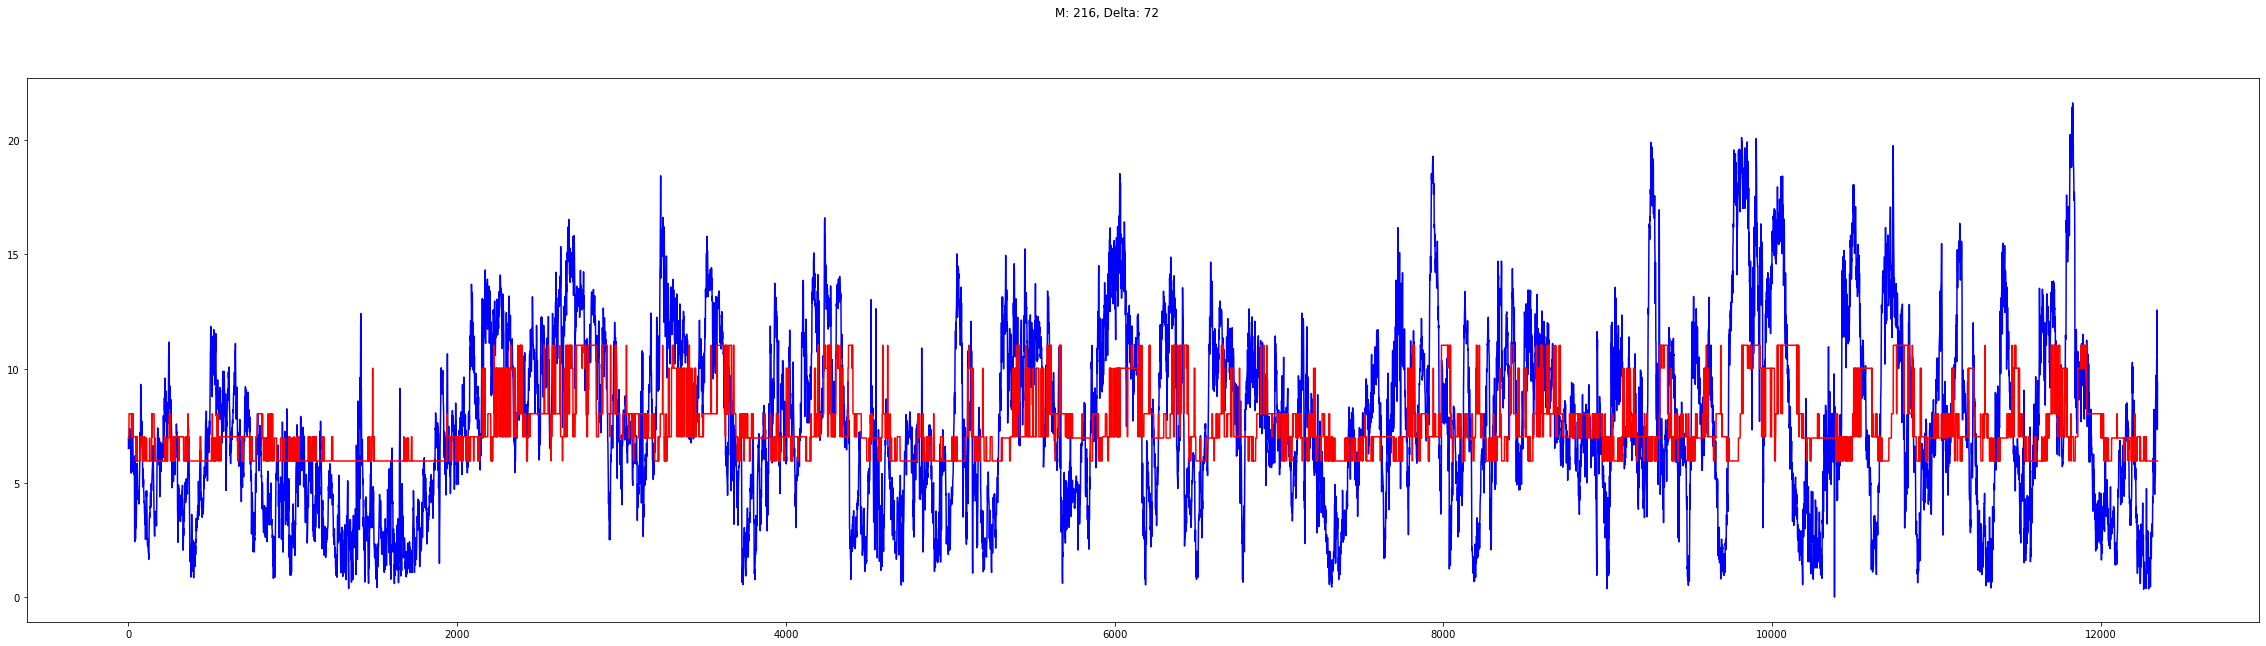

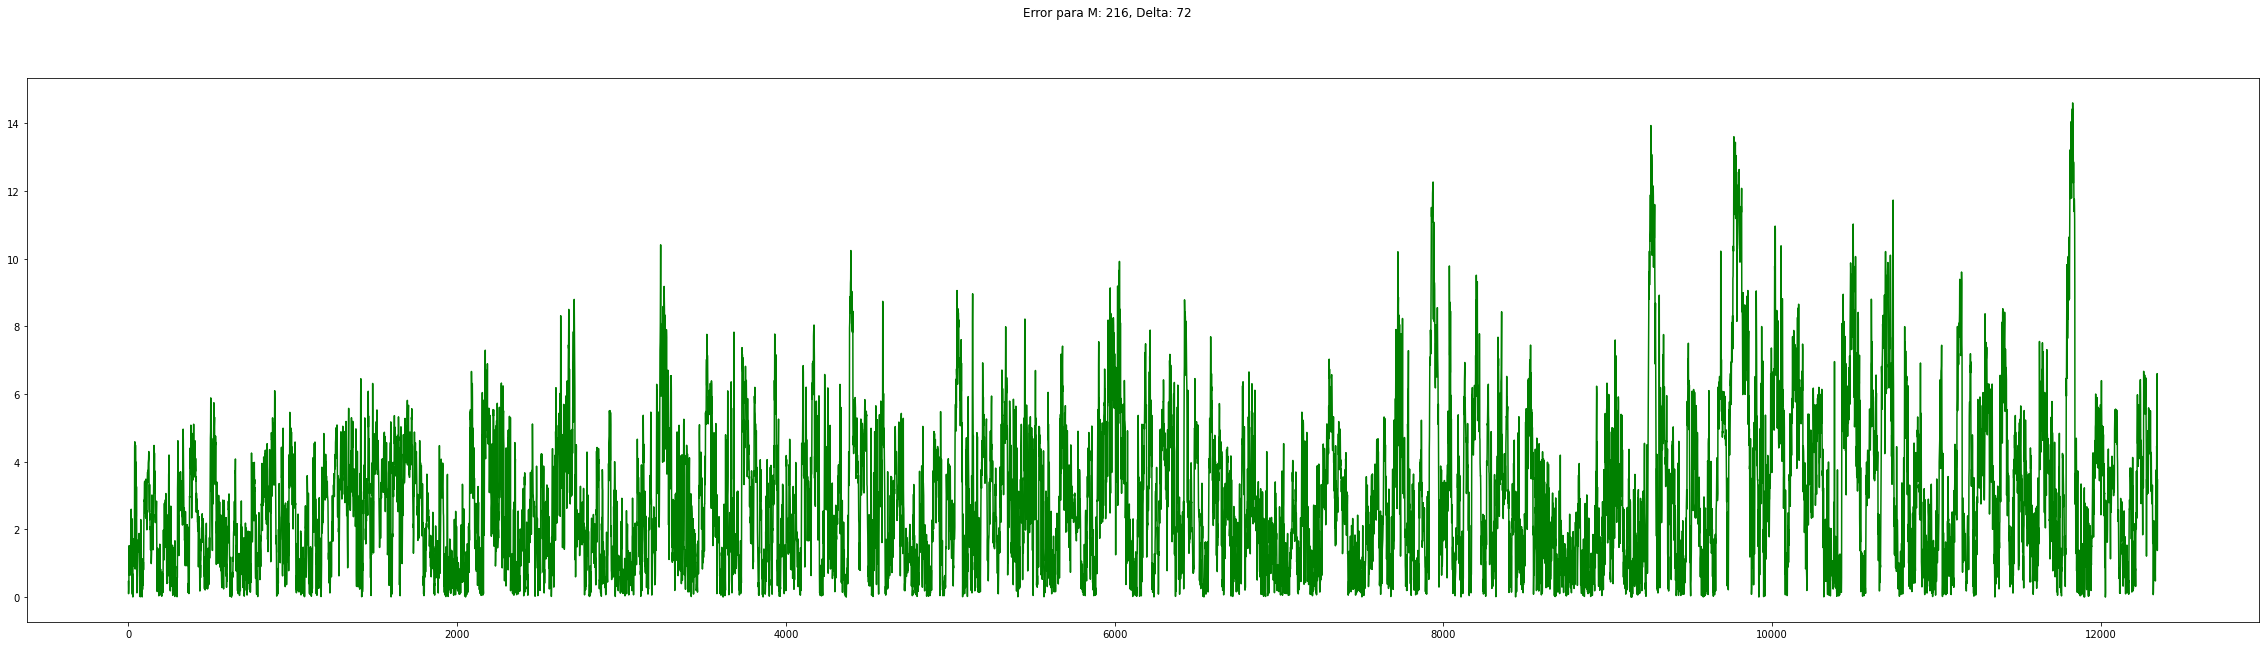

array([1.388195, 3.247134, 3.623968, 1.393238, 3.249331, 3.640263,
       1.033011, 2.57005 , 2.862103, 1.036075, 2.544733, 2.875445])

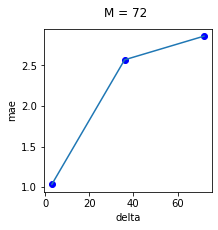

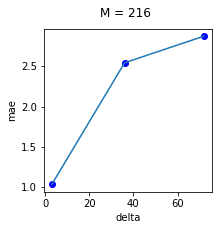

In [42]:
results = xgboost_results(time_params, alg_params, eval_metrics, X)

results